# Select wildfire burn area predictors, fit a linear model, & make predictons 

**This analysis shows how predictions vary depending between** 
- 1) All candidate variables are available for lasso regression
- 2) Each variable is withheld from the regression fitting process. A sort of leave-one-out for model features. 
- 3) Each year of wildfire and weather data are withheld from the regression fitting process. 
    - combined, 1-3 comprehensively show how sensitive regression results are to regression setup. 
    - This will be done using the Lasso (L1 Norm), which will be implemented using [scikit-learn](https://scikit-learn.org/stable/) [lassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)
    - - All predictor features and burn area time series are detrended prior to regression, which helps aviod a [spurious](https://www.svds.com/avoiding-common-mistakes-with-time-series/) relationship between the two. 
    
- 4) These linear models will then be used to predict future burn area driven by environmental features from CMIP5 models. 

## Table of Contents 
- [Experimental setup and EDA](#setup-EDA)
- [Legacy Relaxo Regression Fitting](#legacy-relaxo)
- **New work post initial rejection from Earth's Future**
- [Leave features out analysis](#leave-features-out)
- [Years left out fits](#year-left-out-fits)
- [CMIP5 data setup](#CMIP5-setup)
- [Future Burn area projections](#burn-area-projections)



In [1]:
%matplotlib inline
import numpy as np
from netCDF4 import Dataset
import os
import matplotlib.pyplot as plt
import time
import pandas as pd
import model_dictionary as md # Modules I have written 
from sklearn import preprocessing # For scaling data 
import met_spread_utils as utils # Script full of methods required for this analysis. 
from shapely.geometry import Polygon, Point
import geopandas
import pickle
from scipy import signal, stats
from matplotlib.patches import Patch # For making custom legends 
from matplotlib.lines import Line2D
import seaborn as sns

## Experiment setup & EDA <a class="anchor" id="setup-EDA"></a>

In [2]:
transformation = "log10"
cutoff_percentile = 0 # keep the predictors, not doing double relaxo anymore. 
experiment = "one_last_ride_" + str(cutoff_percentile) +"_transofromation_"+ transformation 
print(experiment)

one_last_ride_0_transofromation_log10


### List the environmental variables to be used to explain historical variance in fire 
- This work used to have 'plant_centric' and 'atmospheric_centric' predictors. These cells are legacy and not used in any publications

In [3]:
# The months of burn area to be analyzed (predicted) using the predictors listed above
# and converted to seasonal means. 
burn_area_season = [6, 7, 8]

In [4]:
# Set important paths
CMIP5_dir = os.path.join("..", "Data", "CMIP5", "r1i1p1_rcp_COMMON_GRID")
era_dir   = os.path.join("..", "Data", "ERA-INTERIM", "merged_t_COMMON_GRID")
fire_file = os.path.join("..", "Data","Fire", "MTBS", "bailys_division_acres_burned.csv")

Create or set a directory relevent to these experimental settings. The Directory will be a self contained location that holds all results associated with this notebook
- Data generated (correlations) as well structures arrays
- Figures associated with regressions and analysis
- This will make a self contained area so that I know what code made what data and what figures go with those.

In [5]:
save_dir_base = os.path.join("..", "Data", "Fire_Analysis", experiment)

if not os.path.isdir(save_dir_base) : 
    os.mkdir(save_dir_base)

New version of the ideas we want to implement no longer require separation of variables by type. Will be leaving variables out one at a time. 

In [6]:
# all variables for prediction ---era interim names---. These variables will be used for lasso_all
predictors = ["tp", "si10", "RH", "mrlsl.integrated", "VPD"]
# these will be the run that has all variables BUT temperature. -- CMIP5 names --
plant_vars = ['pr', 'sfcWind', 'hurs', 'mrlsl.integrated', "VPD"] 
# This will be the temperature only run. OLS? Not sure how relaxo will treat 
# this one. -- CMIP5 names --
atmos_vars = ['tas']

category_dictionary = {"all" : (plant_vars + atmos_vars), 
                       "plant_vars" : plant_vars,
                       "atmos_vars" : atmos_vars
                      }

with open(os.path.join(save_dir_base,"category_dictionary.obj"), 'wb') as fp :
    pickle.dump(category_dictionary, fp)

### Load the Baileys divisions used to subset ecoregions in this analysis 
- Note: Marine Regime Mountains division goes along the coast of Alaska, but the burn area has been exluded there, so exlude in plotting here and later in meteorology. 
- **NOTE:** Our thoughtful reviewer wants us to consider hacking apart California regions. I do not think this is worth the effort. We will instead remind the readers that climate model grid cells are huge. 
- NOTE: If you get annoying "b -no missing" error below, reinstall pyproj

In [7]:
# Western US divisions to be included in this analysis 
desired_divisions = ["Temperate Steppe Regime Mountains", 
                     "Marine Regime Mountains", 
                     #'Marine Division', # No burn area! So will exclude
                     "Mediterranean Regime Mountains", # includes southern coastal Alaska sections
                     #"Mediterranean Division",
                     #'Temperate Desert Division',
                     #"Tropical/Subtropical Steppe Division",
                     #'Tropical/Subtropical Desert Division',
                     #'Tropical/Subtropical Regime Mountains',
                     #'Temperate Desert Regime Mountains',
                    ]

**NOTE:** The code below is not working on laptop, conda issue related to pyproj. Will not bother with with plotting in this cell for now, as fixing these library conflicts could have unintended consequences. Need to export Imac conda environment and activate locally if possible. 

### Get the desired burn area data for the chosen divisions

In [8]:
# Read in burn area, in acres
fire_df = pd.read_csv(fire_file)

# subset by the desired divisions
division_mask = fire_df.columns.isin(desired_divisions)
print("--------------------------------")
print("Divisions used in this analysis:")
print("--------------------------------")

fire_df_subset = fire_df.loc[:,np.array(division_mask)].copy()

# MTBS data start Jan 1984, are monthly, and end in 2017. Make
# a time array date_range that matches this. 
time_mtbs = pd.date_range("1984-01-01", periods=len(fire_df), freq="M")

# Make the monthly time series the row index for the division fire data 
fire_df_subset.index = time_mtbs.copy()

fire_df = fire_df_subset.copy()
divisions = np.array(fire_df.columns)
del(fire_df_subset)
print(divisions)

--------------------------------
Divisions used in this analysis:
--------------------------------
['Marine Regime Mountains' 'Temperate Steppe Regime Mountains'
 'Mediterranean Regime Mountains']


### Show a timeseries of division burn area

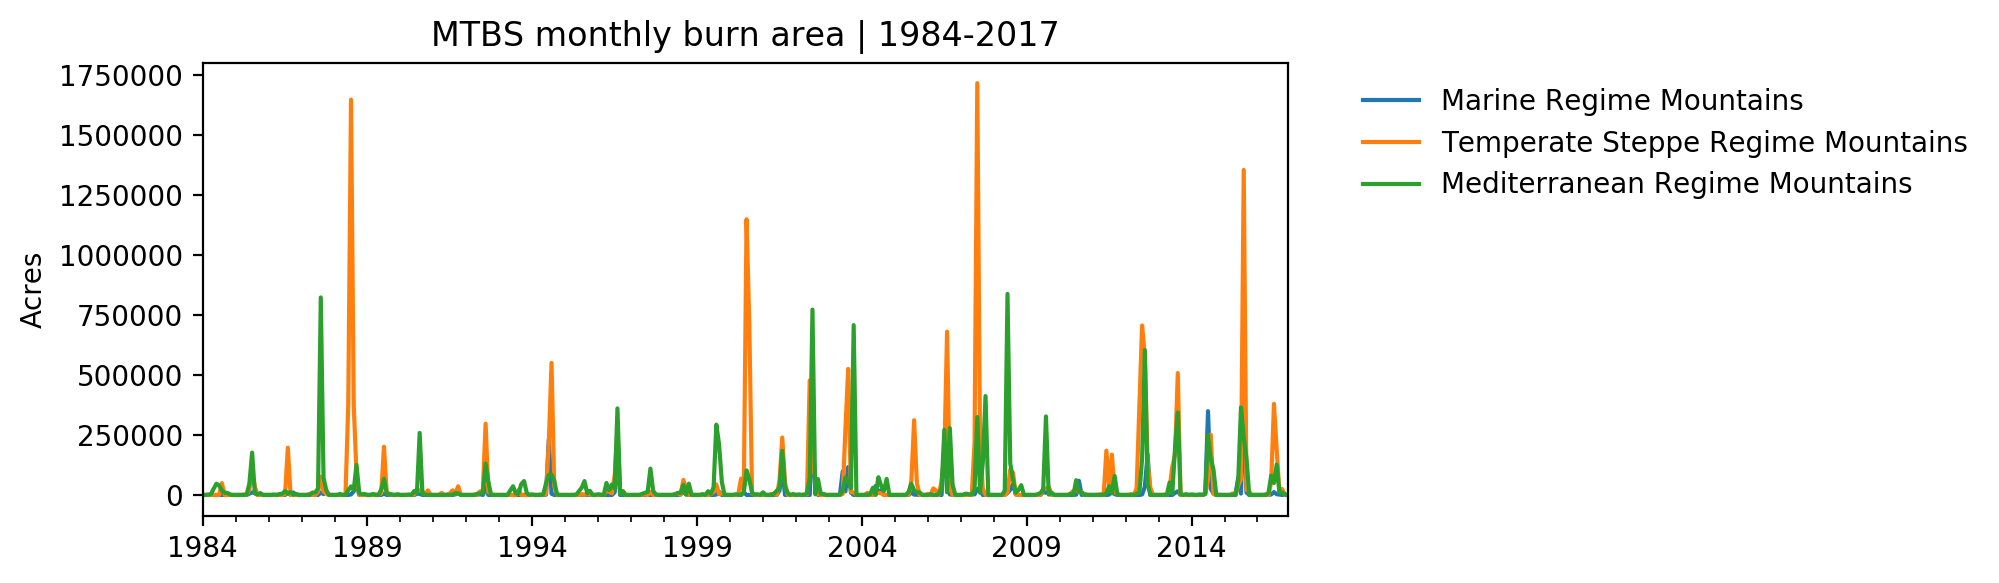

In [9]:
# Show the disolved divisions 
f, ax = plt.subplots(1, figsize=(7, 3), dpi=200)
#plt.plot(time_mtbs, BA)
ax1 = fire_df.plot(ax=ax)
plt.title("MTBS monthly burn area | 1984-2017")
plt.ylabel("Acres")

# handle the legend
leg = ax1.get_legend()
leg.set_bbox_to_anchor((0.15, 1, 1.5, 0.0))
leg.set_frame_on(False)

plt.show()

### Bring in the western_US region to bring along for analysis
- This will allow large scale patterns to be observed
- Provide sanity checks on units
- Allow large area sigma in variables to be computed.
- Calculate burn area in region as sum of each ecoregion burn areas for each month. 

In [10]:
divisions = np.append(divisions, "western_US")
divisions

array(['Marine Regime Mountains', 'Temperate Steppe Regime Mountains',
       'Mediterranean Regime Mountains', 'western_US'], dtype=object)

In [11]:
western_US_burn_area = fire_df.sum(axis=1).copy()
fire_df["western_US"] = western_US_burn_area

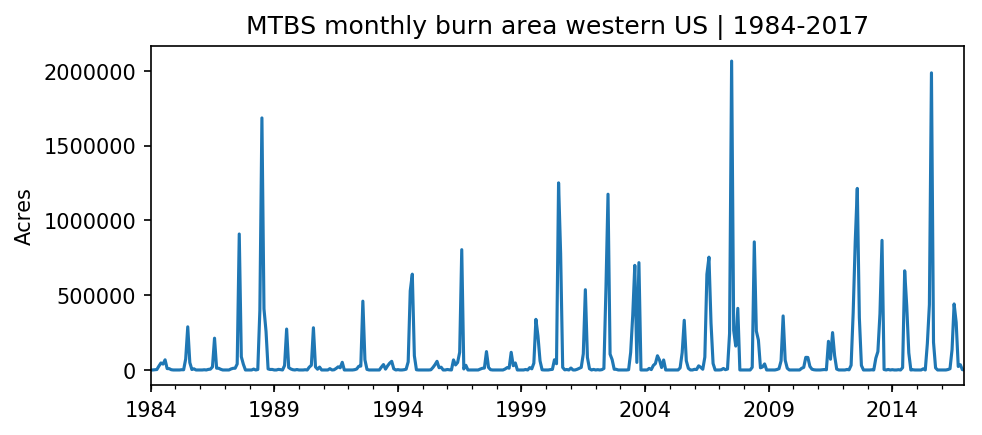

In [12]:
f, ax = plt.subplots(1, figsize=(7, 3), dpi=150)
ax1 = western_US_burn_area.plot(ax=ax)
plt.title("MTBS monthly burn area western US | 1984-2017")
plt.ylabel("Acres")
plt.show()

# Get Bailey's region corrosponding meteorology grids
- We make the assumption that the burn area in the baily's regions mapped above is driven my meteorology over the same spatial region. ERA-interim met (for training) and CMIP5 (for future projections) have been gridded to a common grid and I have figured out what grid boxes overlap what Bailey's divisions. 
- The following code gets masks for each bailey's division within the desired_divisions array. This allows us to subset the gridded meteorology for only the grid boxes that overlap the spatial area of interest. The spatial overlaps and mask creation was done with Python/create_ecoregion_overlap_masks.ipynb

In [13]:
# I need to know what met grid cells to keep with these divisions. Find which ones overlap. 
grid_division_masks_file = os.path.join("..", "Data", "LandCover", "bailys_division_masks_common_grid.nc")
nc = Dataset(grid_division_masks_file, 'r')

grid_lat = nc.variables['lat'][:].data
grid_lon = nc.variables['lon'][:].data

# Leave the file open

Function for getting era_nc_vals. Will be moved out of notebook when development is complete

In [14]:
def get_era_nc_variable(var, spatial_mask, spatialMean=False, startYear=1983):
    """
    # TODO: Move to utils
    This function will be for loading a particular nc file, which will be spatially subset.
    The data loaded are from the merged_t_COMMON_GRID directory. These data have been
    regridded from thier native resolution using cdo remapbil. 
    
    TODO: Add "endyear" as an argument in addition to "startyear" as new MTBS fire data is 
    TODO: going to require going further back in time to train the model. 
    
    Parameters
    ----------
        var : str, The variable (and file name) of the ECMWF era-interim data to be 
              loaded. 
        spatial_mask : numpy array, where equal to 0 are locations to keep data for and 
                       where equal to 1 (True) are grid points to mask (ignore data). 
        spatialMean : Boolean, if False (default) a spatial mean of the era-interim data
                      is not taken and the data are returned on a t,lon,lat grid. 
                  
    Return
    ------
        valsCut : The chosen "var" as a ndarray(t, lat, lon) or if spatialMean = True
                  ndarray(t). 
        t_monCut : pd.date_range describing the t axis of valsCut. 
        lonCut : longitude ndarray
        latCut : latitude ndarray
    
    """
    
    # Create link to the monthly file
    dataDir = os.path.join("..", "Data", "ERA-INTERIM", "merged_t_COMMON_GRID")
    f = var + "_1983-2017.nc" 
    loadFile = os.path.join(dataDir, f)
    
    # Check to see if the file exists! 
    if(not os.path.isfile(loadFile)):
        raise ValueError(f + " File does not exist")
    
    # Load the nc data
    nc = Dataset(loadFile)
    vals = nc.variables[var][:]
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    
    # Create a new array, where each time slice will be a masked version 
    # of the data loaded from the nc file 
    vals_masked = np.ma.empty(shape=vals.shape)
    
    # Pandas handling of time so all models have the exact same origin and such. 
    t = nc.variables["time"]
    if(len(t) == 420):
        # Convert to pandas time array, on the assumption t[0]=startYear-01-01 the data
        # being monthly. Defualt files are 1983-2017.  
        t_mon = pd.date_range(str(startYear)+"-01-01", periods=len(t), freq="M")
    else:
        # there should always be 420 months in these data (35 years of data times 12)
        raise ValueError('Error in number of months for file: '+ f + " 420 expected.")
        
    # Now subset the data based on the passed spatial_mask
    for i in range(len(t)) : 
        vals_masked[i,:,:] = np.ma.masked_array(vals[i,:,:], mask=spatial_mask, copy=True)
    
    # take a spatial mean? 
    if spatialMean:
        # Masked entries are ignored
        vals_masked = np.ma.mean(vals_masked, axis=(1,2))
    
    return vals_masked, t_mon, lon, lat

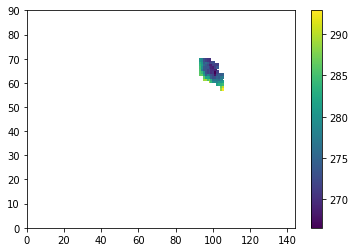

In [15]:
# Demonstrate that the masked array masks data outside of area of interst
t2m, t, lon, lat = get_era_nc_variable('t2m', nc.variables["western_US"][:]==0)
plt.pcolor(t2m[0,:,:])
plt.colorbar()
plt.show()

### Load desired ERA-Interim reanalysis
- Load each variable, take the spatial mean for the spatial_masks shown above and place in a dataframe where each row is a month and each column is a variable, each cell is a monthly mean value for the area. 

In [15]:
def get_division_era_variables(predictors, spatial_mask) : 
    """
    This script employs get_era_nc_variable() and loads the desired predictors 
    for a given ecoregion (division). The spatial mask needs to be passed. The
    spatial me of the data for a given division is taken when using this method
    because it returns a dataframe where the columns are the predictors and the 
    rows are the spatially average monthly-mean values. 
    
    Parameters
    ----------
        predictors : list, the era-interim variables to load. 
        spatial_mask : numpy.ndarray containing True and False values only. Values
                       are true for grid boxes not desired (to be used as masked) 
                       and values are False for the area with data to be averaged
                       spatially. 
    
    return
    ------
        A pd.DataFrame where the columns are the predictors and the 
        rows are the spatially average monthly-mean values. 
        
    """

    predictorDict = {}

    for var in predictors :

        predictorDict[var], t, lon, lat = get_era_nc_variable(var, spatial_mask, spatialMean=True)

    # Features used to estimate the target function    
    X_monthly = pd.DataFrame(predictorDict, index=t)
    
    return X_monthly 

In [16]:
print(predictors)

['tp', 'si10', 'RH', 'mrlsl.integrated', 'VPD']


In [17]:
print(divisions)

['Marine Regime Mountains' 'Temperate Steppe Regime Mountains'
 'Mediterranean Regime Mountains' 'western_US']


In [18]:
# Show the nc variable names, there are a lot... 
print([i for i in nc.variables.keys()])

['lon', 'lon_bnds', 'lat', 'lat_bnds', 'Hot Continental Division', 'Hot Continental Regime Mountains', 'Marine Division', 'Marine Regime Mountains', 'Mediterranean Division', 'Mediterranean Regime Mountains', 'Prairie Division', 'Rainforest Regime Mountains', 'Savanna Division', 'Savanna Regime Mountains', 'Subarctic Division', 'Subarctic Regime Mountains', 'Subtropical Division', 'Subtropical Regime Mountains', 'Temperate Desert Division', 'Temperate Desert Regime Mountains', 'Temperate Steppe Division', 'Temperate Steppe Regime Mountains', 'Tropical Subtropical Desert Division', 'Tropical Subtropical Regime Mountains', 'Tropical Subtropical Steppe Division', 'Tundra Division', 'Tundra Regime Mountains', 'Warm Continental Division', 'Warm Continental Regime Mountains', 'western_US']


Marine Regime Mountains
[False  True]


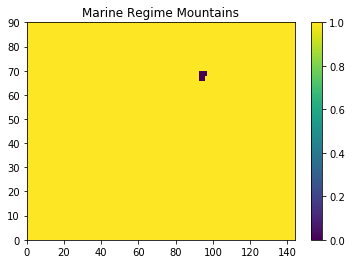

Temperate Steppe Regime Mountains
[False  True]


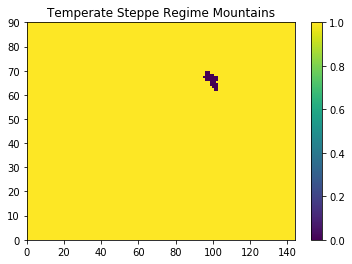

Mediterranean Regime Mountains
[False  True]


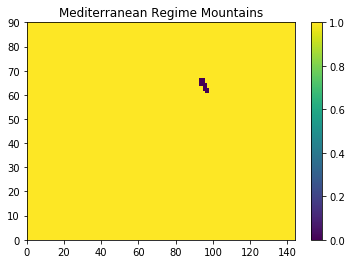

western_US
[False  True]


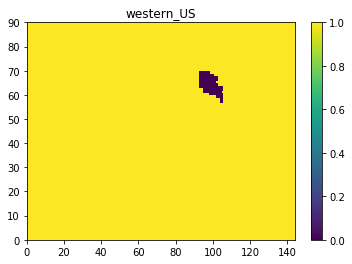

In [19]:
# Dictionary to store monthly values for predictors (era data)
X_monthly_dict = {}

for div in divisions : 
    
    # Remove forbiden charactors 
    division_key = div.replace("/", " ")
    #print(division_key)
    # NOTE: The division masks are stored such that 1 means in division, 0 means not.
    # NOTE: np.ma masking requires a true or 1 for values to mask, i.e. ignore, so 
    # NOTE: the data from the nc file for divisions is flipped when getting division 
    # NOTE: data 
    print(division_key)
    div_mask = nc.variables[division_key][:].data == 0
    
    print(np.unique(div_mask))
    
    # Sanity check the masks
    plt.figure()
    plt.pcolor(np.array(div_mask, dtype=int) )
    plt.colorbar()
    plt.title(str(division_key) )
    plt.show()
    
    X_monthly_dict[div] = get_division_era_variables(predictors, div_mask)
    #print(np.sum(X_monthly_dict[div].tp))
    
nc.close()

### Change units of some ERA-Interim data to match CMIP5 output
Extensive notes can be found on these conversions in the file Python/make_era_and_CMIP5_units_identical.ipynb


#### Convert units on fields that need it 

In [20]:
print(predictors)

['tp', 'si10', 'RH', 'mrlsl.integrated', 'VPD']


In [21]:
for div in divisions : 
    
    # Get a regions met values to change units for 
    X_monthly = X_monthly_dict[div]
    
    tp = utils.m_to_mass_flux( np.array(X_monthly["tp"].copy()) )
    #e = utils.e_to_mass_flux( np.array(X_monthly["e"].copy()) ) 
    
    # Replace columns with updated versions
    X_monthly.loc[:, "tp"] = tp
    #X_monthly.loc[:, "e"] = e 
    
    # Finally, make the names of the era-interim variables match the names
    # in --CMIP5 output--. After this step, the units and names should match. 
    # t2m tp si10 RH slhf VPD mrso e
    X_monthly.rename(columns={"t2m":"tas","tp":"pr","si10":"sfcWind","RH":"hurs", 
                              "mrlsl.integrated":"mrlsl.integrated", "e":"evspsbl"}, 
                     inplace=True)
    
    # Place back in dictionary 
    X_monthly_dict[div] = X_monthly
    #print(X_monthly.columns)

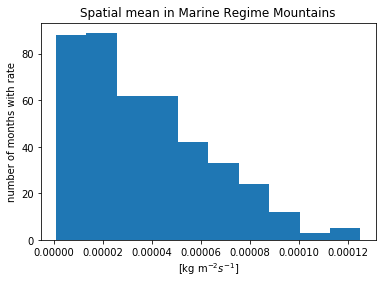

In [22]:
plt.figure()
plt.hist(X_monthly_dict['Marine Regime Mountains'].pr)
plt.xlabel("[kg m$^{-2}s^{-1}$]")
plt.title("Spatial mean in Marine Regime Mountains")
plt.ylabel("number of months with rate")
plt.show()

In [23]:
print(divisions)

['Marine Regime Mountains' 'Temperate Steppe Regime Mountains'
 'Mediterranean Regime Mountains' 'western_US']


### Setup forecasting summer burn area using seasonal (varying t-lag) predictors and calculating summer burn area
- NOTE: Reviewer made a comment about the word 'anticedent' usually refering to the previous year, so change that in the writing. 

#### Seasons to aggregate features
- summer (6,7,8)
- spring (3,4,5)
- winter (11,12,1,2) 

TODO: 
- Other previous years seasons? 

In [24]:
def make_monthly_seasonal(X_monthly, time_mtbs, inspect=False) :
    """
    Makes monthly met predictors seasonal by taking monthly predictors (features) 
    to means of seasons, winter=[11,12,1,2], spring=[3,4,5], summer=[6,7,8]. For 
    winter predictor, the months 11 and 12 will come from the previous year, so 
    when making predictors for a row (year) 2013, the months to be averaged are
    Nov 2012, Dec 2012, Jan 2013, Jan 2014. This is all meant to forecast burn area
    occurring in the months 6,7,8 (summer). 
    NOTE: When using this to convert CMIP5 monthly predictors to seasonal, because 
    NOTE: the time_mtbs argument will be cmip time, the first years (1984) _winter
    NOTE: features will be an average of Jan 1984 and Feb 1984, since there is no 
    NOTE: data for the previous year. All other year winter predictors are normal.
    
    Parameters
    ----------
        X_monthly : pd.DataFrame object with shape [months x features] where the index
                    is a datetimes.DatetimeIndex
        time_mtbs : datetimes.DatetimeIndex that matches either monthly burn area series
                    (for era-interim data) or the X_montly.index (for cmip data).
        inspect : When True, the masked time array used for each years seasonal predictors
                  will be printed. 
                  
    return
    ------
        pd.DataFrame : A dataframe [year x seasonal_feature] where each feature in the 
                       X_monthly pd.DataFrame has been expanded to var_winter, var_spring
                       var_summer. 
    """
        
    # Create summer burn area time series
    fire_years  = np.sort(np.unique(time_mtbs.year))
    nYears      = len(fire_years)

    # ERA data starts one year before the burn area data 
    era_time = X_monthly.index.copy()
    era_year = era_time.year
    era_month = pd.Series(era_time.month)

    # Create season masks (first month last month of season). Each season gets its own 
    # column in the features DataFrame.
    # NOTE: Make sure to not use months after wildfires in a given year, e.g. 
    # NOTE: December, unless set to the year before # Make sure to not use months 
    # NOTE: after wildfires in a given year, e.g. December, unless set to the year before 
    seasons = {"winter":[11,12,1,2], 
               "spring":[3,4,5], 
               "summer":[6,7,8]}

    # Make a dictionary to store predictors for each variable for each season 
    # of interest. 
    variables = np.array( X_monthly.columns.copy() )
    
    # To store predictor information 
    predictor_dict = {} 

    for pre in variables :
        for s in seasons.keys() :
            predictor_name = pre + "_" + s 
            predictor_dict[predictor_name] = np.zeros(nYears)

    # Loop through each year, assigning desired season predictor value 
    # within each year 
    for i in range(nYears):
        
        if inspect :
            print(fire_years[i])
        
        # Loop through seasons, within a year
        for s in seasons.keys():
            
            if inspect : 
                print(s)

            if s == 'winter' : 
                
                prev_year_mask = (fire_years[i]-1) == era_year
                m1 = era_month.isin([11,12])
                tChuchk1 = prev_year_mask & m1
                
                this_year_mask = fire_years[i] == era_year
                m2 = era_month.isin([1,2])
                tChuchk2 = this_year_mask & m2
                # Want an array than combines the True locations, "or" in other
                # words 
                tChunk = tChuchk1 | tChuchk2
                
                if inspect :
                    print(era_time[tChunk])
                
            else :
                
                # The non-winter predicors months fall into the same year as fire activity
                year_mask = fire_years[i] == era_year
                
                # Mask the months that fall into the current season of interest
                month_mask = era_month.isin(seasons[s])

                # combine to make a single mask
                tChunk = month_mask & year_mask 
                
                if inspect :
                    print(era_time[tChunk])

            # For each predictor variable, loop through taking relevant stat
            for pre in variables:
                k = pre + "_" + s
                predictor_dict[k][i] = np.mean(X_monthly.loc[era_time[tChunk], pre].copy())
    
    # Return a DataFrame of era data as desired seasonal features 
    return pd.DataFrame(predictor_dict, index=fire_years)

### Make monthly era data into seasonal means for each division 

In [25]:
X_seasonal_dict = {}
for div in divisions : 
    X_seasonal_dict[div] = make_monthly_seasonal(X_monthly=X_monthly_dict[div], time_mtbs=time_mtbs)
    
# these data need to be saved
with open(os.path.join(save_dir_base, "ERA_features_dict.obj"), 'wb') as fp :
    pickle.dump(X_seasonal_dict, fp)

### Make monthly burn area data into target season burn area totals 
https://stackoverflow.com/questions/38792122/how-to-group-and-count-rows-by-month-and-year-using-pandas

In [26]:
# Subset rows to burn_area_season, then 
df_= fire_df[fire_df.index.month.isin(burn_area_season)].copy()
# Aggregated by season is the target function, y, so start calling it y. 
y_seanonal_df = df_.groupby(df_.index.year).agg('sum').copy()
del(df_)

In [28]:
y_seanonal_df.head()

Marine Regime Mountains  Temperate Steppe Regime Mountains  \
1984                        0                              49397   
1985                    24869                             156596   
1986                    11087                             201099   
1987                    11903                              88488   
1988                    17386                            2396621   

      Mediterranean Regime Mountains  western_US  
1984                          104754      154151  
1985                          230031      411496  
1986                           26435      238621  
1987                          860073      960464  
1988                           77565     2491572

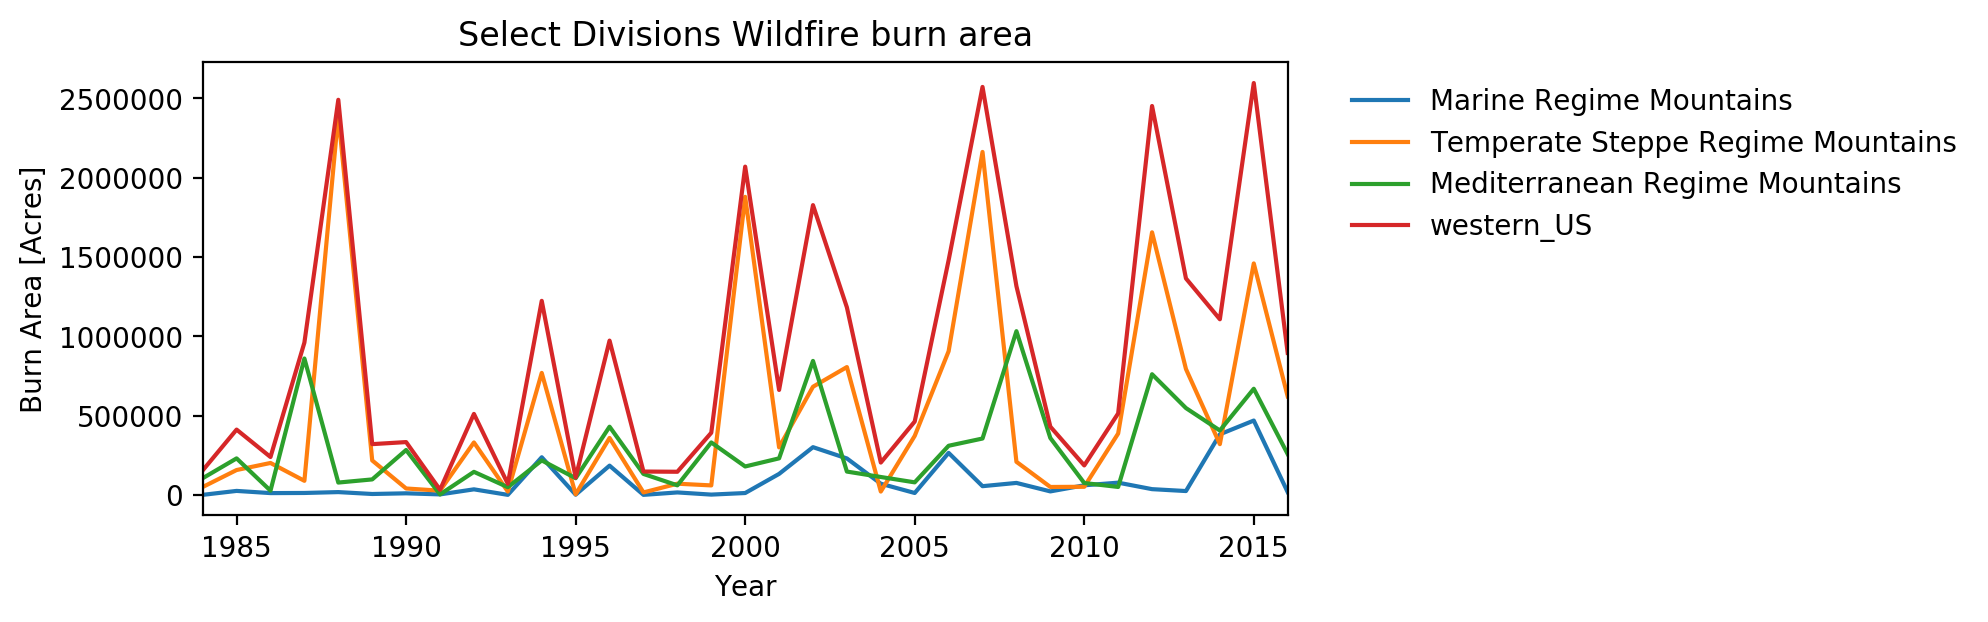

In [27]:
f, ax = plt.subplots(1, figsize=(7, 3), dpi=200)
y_seanonal_df.plot(ax=ax)
plt.title("Select Divisions Wildfire burn area")
plt.ylabel("Burn Area [Acres]")
plt.xlabel("Year")
plt.legend()

# handle the legend
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.14, 1, 1.5, 0.0))
leg.set_frame_on(False)

plt.show()

## Standardize and detrend the predictors (features) for seasonal burn area variability analysis
- The mean and standard deviation of the features needs to be saved in order for bias correcting CMIP5 output later. 
- These data need to be detrended before regression. 
- Sets up forecasting year to year variability without interference on long term trends, a different analysis
- **NOTE:** Pandas.DataFrame.std() uses ddof=1 by default, while numpy uses ddof=0 by defualt. Make sure you are consistent otherwise the way data standard deviation is expressed will change throughout use. 

- Make sure variables align, values are sensible, etc. I am now worried that changes observed, in terms of sigma, are too high and don't make sense?

In [28]:
# Dictionary to store DataFrames of the standardized features
Z_dict = {}

feature_names = X_seasonal_dict[list(X_seasonal_dict.keys())[0]].columns

# Argument, detrend the data? Consequences down the pipeline as far as it goes. 
detrend = True

# Make DataFrames where the means and std of feature data can be saved 
# [division x feature]
X_mean_df = pd.DataFrame(np.nan, index = X_seasonal_dict.keys(),
                         columns = feature_names)
# [division x feature]
X_std_df = pd.DataFrame(np.nan, index = X_seasonal_dict.keys(),
                        columns = feature_names)
# [division x feature]
era_feature_slope = pd.DataFrame(np.nan, index = X_seasonal_dict.keys(),
                                 columns = feature_names)
era_feature_slope_pvalue = pd.DataFrame(np.nan, index = X_seasonal_dict.keys(),
                                        columns = feature_names)

for i in divisions : 
    
    # Get the features for a division
    X = X_seasonal_dict[i]
    x = X.index.values # for getting linear regression, units with years
    
    # Calculate and store in correct location, means and std
    # NOTE: detrending does not change the mean 
    X_mean_df.loc[i, X.mean().index] = X.mean().copy()
    
    if detrend :
        
        for feature in X.columns : 
            
            # Regression on the feature
            xi = X.loc[:, feature].values 
            lm = stats.linregress(x, xi)
            era_feature_slope.loc[i, feature] = lm.slope
            era_feature_slope_pvalue.loc[i, feature] = lm.pvalue
        
        # Create a temporary df to save desired features of
        # pd DataFrame, while they are converted to an array
        # for detrending using scipy.signal 
        df_temp = pd.DataFrame(np.nan, columns=X.columns.values, index=X.index.values)
             
        # Make a de-trended version of these data
        X_detrended     = signal.detrend(X.values, axis=0)
        X_detrended_std = np.std(X_detrended, axis=0)
        
        # Standardize the X feature data and store in Z_dict
        X_std_df.loc[i, X.columns.values] = X_detrended_std
        
        Z_detrended = ( X_detrended / X_detrended_std )
        #print(Z_detrended.std(axis=0))
        
        df_temp.iloc[:,:] = Z_detrended
        Z_dict[i] = df_temp
                
    else :
        
        # Standardize the X feature data and store in Z_dict
        X_std_df.loc[i, X.std().index] = X.std(ddof=0).copy()
        Z_dict[i] = ( (X-X.mean()) / X.std(ddof=0) ).copy()
    
# Save these mean and std values, they are needed for projections
X_mean_df.to_csv(os.path.join(save_dir_base, "feature_means.csv"))
X_std_df.to_csv(os.path.join(save_dir_base, "feature_std.csv"))

# Save the slopes and their pvalues, this could be handy later
era_feature_slope.to_csv(os.path.join(save_dir_base, "feature_slopes.csv"))
era_feature_slope_pvalue.to_csv(os.path.join(save_dir_base, "feature_slopes_pvalues.csv"))

In [29]:
Z_dict['Marine Regime Mountains'].columns

Index(['pr_winter', 'pr_spring', 'pr_summer', 'sfcWind_winter',
       'sfcWind_spring', 'sfcWind_summer', 'hurs_winter', 'hurs_spring',
       'hurs_summer', 'mrlsl.integrated_winter', 'mrlsl.integrated_spring',
       'mrlsl.integrated_summer', 'VPD_winter', 'VPD_spring', 'VPD_summer'],
      dtype='object')

In [30]:
X.loc[:, feature].dtype

dtype('float64')

### Implement a custom cross validation scheme that minimizes leave one out sample error
- Alpha varies how harsh the model is, the bigger alpha, the more predictors are eliminated. When alpha = 0 Lasso is the same as OLS regression. And with this many features, it will FOR SURE be overfit. 
- Below the slope of wildfire burn area, as well as slope alpha, are saved.
- The Lasso is fit to 1) all variables available at once, 2) atmos-centric variables only, 3) plant-centric variables only. The results for all three are saved, including the trained regressions themselves. 
- TODO: Evaluate and come up with some metric for stability. 


````Python 
for year_left_out in range(1984:2016) :
    Xs = X[!year_left_out, ]
    
    leave_one_out_model = LassoCV()

 Calculate mean error for this alpha
````

**Post Review addition** 
- We want to show how much model coefs change as we fit different models. We do this for year left out, now lets do this for leaving feature (i.e. environmental variable) out of the fitting. 

````Python 
for var_left_out in all_features :
    Xs = X[:, all_but_var_left_out]
    
    leave_one_out_model = LassoCV()
    # Record coefs, predictions, etc

````

In [31]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LassoCV, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import warnings # For all kinds of converge issues

In [32]:
def plot_all_relationships(Y, X, ecoregion) : 
    """
    Scatterplot the burn area data against all features. One axis per
    feature, and each feature season is a different color.
    
    Parameters
    ----------
        Y : The variable we are trying to predict
        X : The matrix (dataframe) of features used to predict Y. Show
            scatter relationship. 
            
    """
    eco_write = ecoregion.replace(" ","_").replace("/"," ")
    scatter_fig = os.path.join(save_dir_base, eco_write + "_Z_vs_burn_area.png")
    
    n_features = X.shape[1]
    feature_names = X.columns
    
    fig = plt.figure(figsize=(10,15), dpi=200)
    
    panel = 0
    for feature in feature_names :
        panel += 1
        ax = plt.subplot(8, 3, panel)    
        x = X.loc[:, feature ]
        r = np.round(np.corrcoef(x, Y)[0][1], 4)
        
        plt.scatter(x, Y.values, label="r=%f" % r)
        plt.title(feature)
        plt.legend()
        plt.xlabel("")
        plt.gca().axes.get_yaxis().set_visible(False)
    
    fig.suptitle(ecoregion +" burn area vs feature", fontsize=14)
    plt.subplots_adjust(hspace=0.4)
    plt.savefig(fname=scatter_fig, format='png')
    plt.close()
    

def show_model_skill(y_orig, z, y, model, var_type, fname, div, transformation="log10") :
    """
    Predict historical values using optimal alphas.
    plots the following:
        1) model coeficients
        2) y vs. y_hat time series
        3) y vs. y_hat 1:1
        4) model residuals
        
        # TODO: Make into a class. 
        
    Parameters
    ----------
        y : the target values as an array
        Z : the features used to predict the target as a pd.DataFrame
        model : from LassoCV or similar, to be sumarized
        fname : image save location
    
    """
    
    years = np.array(z.index)
    
    # Make prediction
    y_hat = model.predict(z)
    
    # Setup figure 
    fig = plt.figure(dpi=200, figsize=(22, 13))
    
    #fig.suptitle(div + " " + var_type  + " regression summary", fontsize=16)
    
    #########################################################
    # Show the target function that we are trying to predict 
    #########################################################
    plt.subplot(2, 3, 1)
    plt.plot(years, y_orig, "-o", label="MTBS")
    plt.axhline(y=0, linestyle="--", color="k")
    plt.legend()
    plt.title("Unaltered MTBS burn area")
    
    ##########################################
    # Plot distribution before log10 transformation
    ##########################################
    #if transformation == 'log10' : 
    #    transformed = 10**y
    #    xlabel = "10^(detrended( log_{10}(y ))"
    #else :
    #    transformed = y
    #    xlabel = "detrended y"
    #    
    #plt.subplot(2, 4, 2)
    #plt.hist( y )
    #plt.xlabel(xlabel)
    #plt.ylabel("count")
    #plt.title("Distribution of the detrended target")
    
    ########################################
    # Plot distribution 
    ########################################
    #plt.subplot(2, 4, 3)
    #plt.hist( y )
    #if transformation == 'log10' : 
    #    plt.xlabel("detrended( log10(y) )")
    #else :
    #    plt.xlabel("detrended y ")
        
    #plt.ylabel("count")
    #plt.title("Distribution of the detrended target")
    
    ##########################################
    # Show the coeficients for the model_best
    ##########################################
    plt.subplot(2, 3, 2)

    plt.bar(z.columns.values, model.coef_)
    plt.axhline(y=0, c="k", linestyle="--")
    plt.xticks(rotation='vertical')
    plt.xlabel("Feature")
    plt.ylabel("Coefficients")
    plt.title("Feature coefs for least square error model, $\\alpha$=" + str(np.round(model.alpha_, 4)))
    #plt.xticks(rotation=45)

    ########################################
    # Plot obs and modeled values for both
    ########################################
    r2 = np.round(metrics.r2_score(y_true=y, y_pred=y_hat),4)
    plt.subplot(2, 3, 3)
    plt.plot(years, y, '-o', label="transformed observation")
    plt.plot(years, y_hat, '--o', label="model")
    plt.ylabel("log$_{10}$(acres burned)")
    plt.legend()
    plt.title("Time series & mode | R$^{2}$=" + str(r2))

    ########################################
    # Show the MSE path across alphas 
    ########################################
    plt.subplot(2, 3, 4)
    plt.plot(model.alphas_, np.mean(model.mse_path_, axis=1), label="MSE across folds")
    plt.xlabel(r"$\alpha$")
    plt.ylabel("Mean MSE of folds")
    plt.axvline(model.alpha_, color="k", linestyle="--", label="selected $\alpha$")
    plt.title("RMS path across " + r"$\alpha$")
    
    ########################################
    # Plot observations vs. modeled values
    ########################################
    x1 = np.linspace( np.min([y, y_hat]), np.max([y, y_hat]) )
    r = np.round(np.corrcoef(y, y_hat)[0][1], 3)

    plt.subplot(2, 3, 5)
    plt.plot(x1, x1, color="k", linestyle=":", label="1:1")
    plt.scatter(y, y_hat, c=years)
    plt.xlabel("Observation")
    plt.ylabel("Predicted")
    plt.title("Observation vs. predicted values | r="+str(r))
    plt.colorbar()

    ########################################
    # Plot residuals 
    ########################################
    zero = np.zeros(len(years))
    
    plt.subplot(2, 3, 6)
    plt.scatter(years, y-y_hat)#, c=years)
    plt.plot(years, zero, color="k", linestyle=":")
    if transformation == 'log10' : 
        plt.ylabel("log$_{10}$(acres burned)")
    else :
        plt.ylabel("acres burned")
        
    plt.title("Model residuals")
    
    # overall styling
    plt.subplots_adjust(hspace=0.8, wspace=0.3)
    plt.savefig(fname=fname, format='png')
    plt.close()
    
def separate_predictors(atmos_vars, plant_vars, x) : 
    """
    Separates predictor DataFame (x) into plant and atmos centric predictos 
    based on the lists atmos_vars and plant_vars. 
    """
    # Clean up the symbols for precise str.contains statements 
    atmos_vars_str = str(atmos_vars).replace("'","").replace(" ","").replace(",","|").replace("[","").replace("]","|").replace("pr","pr_")[:-1]
    plant_vars_str = str(plant_vars).replace("'","").replace(" ","").replace(",","|").replace("[","").replace("]","|").replace("pr","pr_")[:-1]
    # make masks
    atmos_mask = np.array(pd.Series(x.columns).str.contains(atmos_vars_str))
    plant_mask = np.array(pd.Series(x.columns).str.contains(plant_vars_str))
    
    x_atmos = x.iloc[:, atmos_mask].copy()
    x_plant = x.iloc[:, plant_mask].copy()

    return x_atmos, x_plant


def get_OLS_score(Z, y) : 
    """
    Gets r-squared score for a target using a matrix of features. 
    """
    linear_model = LinearRegression()
    _ = linear_model.fit(Z, y)
    score = linear_model.score(Z, y)
    return score

### Setup the DataFrames that will save the key results
- to save for plotting and analysis purposes elsewhere. 

**Will need a dataframe of the type**

regression_model_coef 

|variable left out | var_1 coef | ... | var_n coef |
|---|---|---|---|
|var_1             | nan        | some_value | some_value| 
|...               | some_value | nan        | some_value| 
|var_n| some_value| some_value  | nan|

Remember, new publication work does not include the 'atmos' and 'plant' partitioning

In [33]:
# Create a dataframe for a summary of results from multiple linear
# models 
results_df = pd.DataFrame(
    data=np.nan,
    columns=["division", "OLS_r2", 'lasso_r2', 'lasso_alpha',
            'atmos_r2', 'atmos_alpha', 'plant_r2','plant_alpha'],
    index=divisions
)

# Store the one thing we know so far.. 
results_df.division = divisions

# Create a place to store coeficients in a dataframe [division x feature]
predictors = X_seasonal_dict[list(X_seasonal_dict.keys())[0]].columns.values
lasso_all_coefs = pd.DataFrame(0, index=divisions, columns=predictors)

# Make plant- and atmos-centric specific coef storage containers 
plant_col_mask = []
atmos_col_mask = []
for p in predictors : 
    # Only plant predictors go into this one
    if pd.Series(p.split("_")[0]).isin(plant_vars)[0] :
        plant_col_mask.append(True)
    else :
        plant_col_mask.append(False)
        
    # And only atmos ones here
    if pd.Series(p.split("_")[0]).isin(atmos_vars)[0] :
        atmos_col_mask.append(True)
    else:
        atmos_col_mask.append(False)
        
plant_col_mask = np.array(plant_col_mask)
atmos_col_mask = np.array(atmos_col_mask)

lasso_atmos_coefs = pd.DataFrame(0, index=divisions, columns=predictors[atmos_col_mask])
lasso_plant_coefs = pd.DataFrame(0, index=divisions, columns=predictors[plant_col_mask])

# Create a dataframe to save information about the trends in burn area
df_slopes = pd.DataFrame(np.nan, index=divisions, columns=["slope", "pvalue"])

## Legacy Relaxo Regression Fitting <a class="anchor" id="legacy-relaxo"></a>

In [34]:
class relaxo() :
    """
    Custom implementation of the double lasso. The idea is to use lasso twice. 
    First time through use it explicitly for variable selection (what features
    have coef values not equal to zero) and then again for linear regression
    fitting regularization. The second use only uses features that had non-zero
    coefs on X% of external loop leave-one-out iterations. 
    
    TODO: Return R-squared on the test set for the alpha value with the lowest 
    TODO: mean-square-error 

    """
    
    def __init__(self, X, y) : 
        """
        Parameters
        ----------
            y : pd.Series, these are the data to predict.  
            X : These are the features used to predict y. The goal
                of this class is to eliminate the not so useful features
                in X, to make better predictions on y. 
                transformation : transformation of y. 
        """
        self.X = X
        self.y = y        
        self.feature_names = X.columns.values 
    
    def subset_features(self, max_iter = 100000, tol = 0.001, normalize=False, inspect=False) : 
        """
        First layer of lasso regression to be used for variable selection. We keep 
        track of what features are selected to have non-zero coefs where the 
        lassoCV is fit to each year left out of the data, a bit like external 
        cross validation. 

        Parameters
        ----------
            max_iter, tol, normalize : see LassoCV() 

        """
        
        y = np.array(self.y) # needs to be np.array for maths
        X = self.X           # will be made a np.array later

        if type(X) is pd.DataFrame : 

            example_labels = X.index.values
            n_examples = X.shape[0]
            n_features = X.shape[1]
            feature_names = X.columns
            
        # Handle the type of the data 
        #if type(X) is np.ndarray :
        #    n_examples = X.shape[0]
        #    n_features = X.shape[1]
        #    example_labels = np.linspace(1, n_examples, n_examples)
        #    feature_names  = np.linspace(1, n_features, n_features)

        else :

            raise TypeError("X type: '" + str( type(X) ) + "' is not accepted. \
            pd.Dataframe expected at this time. ")
            
        # X needs to be a np.array for the rest of this method
        X = np.array(X)
            
        if inspect :
            print(n_examples)
            print(example_labels)
            print(feature_names)
            print(n_features)
        
        # save the LassoCV alpha value for each year left out
        outer_alphas = [] 

        # Keeps track of each time a coef had a non-zero coef
        coef_counter = pd.DataFrame(0, index=[1], columns=feature_names)
        
        # for a given year left out of outside loop, what was the coef,
        # consisency will be interesting. 
        coef_values = pd.DataFrame(0, index=example_labels, columns=feature_names)
        
        # Outer loop, exclude every example once. The example iterator is what is
        # left out. 
        warnings.filterwarnings('ignore')
        count = 0
        for example in example_labels : 
            
            if inspect :
                print("leaving out: " + str(example))
                print(examples_to_keep)
            
            examples_to_keep = example_labels != example
            X_year_out       = X[examples_to_keep, :]
            y_year_out       = y[examples_to_keep]
            
            # Fit the data using leave one out 
            m = LassoCV(cv=LeaveOneOut(), normalize=normalize, tol=tol, max_iter=max_iter)
            m.fit(X_year_out, y_year_out)
            
            # TODO: Make predictions on year left out? 

            # Store fit information
            outer_alphas.append(m.alpha_)
            coef_values.loc[example, :] = m.coef_
            coef_counter.loc[1, (np.abs(m.coef_) > 0) ] += 1
            
            # progress bar
            if inspect : 
                count += 1
                print("percent completed: %f" %(100.*count/len(example_labels)))
            
        # Turn warnings back on
        warnings.filterwarnings('default')
        
        # Store these dataframes
        self.coef_counter = coef_counter
        self.coef_values  = coef_values
        self.outer_alphas = outer_alphas

        return coef_values, coef_counter, outer_alphas 

    def second_lasso(self, cutoff_percentile=0, max_iter = 100000, 
                     tol = 0.001, normalize=False) : 
        """
        Implements LassoCV() with leave-one-out to 
        find the final model. This uses the subset 
        of X values that were determined to be useful
        with the external nest
            Parameters
            ----------
                cutoff_percentile : Percentile to which to cuttoff a feature. If a feature
                                    was not selected in more than cutoff_percentile of the 
                                    external loops of subset_features() then do not include
                                    it for fitting here. When exactly zero, no feature selection
                                    is performed and all of X variables are used. 
                max_iter : see LassoCV()
                tol : see LassoCV()
                normalize: see LassoCV(), set to false because our data are centered
                           by design. 
                           
            return 
            ------
                lasso_model : The Lasso model fit using the columns of X specified as True
                              by the original_features_kept_mask. 
                X : pd.DataFrame, the dataframe used for the second fit. 
                original_features_kept_mask : Logical, the features (columbns) used (where True) 
                                     for this lasso.  
        """
        
        y = self.y
        if cutoff_percentile == 0 :
            # DO NOT subset X at all. 
            X = self.X
            print("X is not being subset")
            self.cutoff = 0
            original_features_kept_mask = np.array([True]*X.shape[1])
            
        else :
            # Subset using the specified percentile
            X_all = self.X 
             
            cutoff = np.percentile(self.coef_counter.loc[1, :].values, cutoff_percentile)
            self.cutoff = cutoff 
            original_features_kept_mask = np.array(self.coef_counter.loc[1, :].values >= cutoff)
            X = X_all.loc[:, original_features_kept_mask].copy()
            
        self.X_second_lasso = X
            
        # Store the cutoff percentile 
        self.cutoff_percentile = cutoff_percentile
        
        lasso_model = LassoCV(cv=LeaveOneOut(), normalize=normalize, tol=tol, max_iter=max_iter)
        lasso_model.fit(X.values, y)
        
        # Make this model available externally
        self.lasso_model = lasso_model 
        self.original_features_kept_mask = original_features_kept_mask
        
        # TODO: translate these coefs back to original data locaitons (columns)
        return lasso_model, X, original_features_kept_mask
    
    def plot_subset_stats(self, include_second = False, cutoff_percentile=50) :
        """
        Visualizes the results of the feature selection performed by subset_features.
        
        Parameters
        ----------
            include_second : Logical, whether to plot the results of the second lasso or not. 
            cutoff_percentile : The percentile by which features are excluded from the 
                                second use of lasso. The figures in this method visualize
                                where the percentile falls along the metadata associated 
                                with the external loop. Overidden when inclide_seconf is True. 
            
        """
        
        counts = self.coef_counter.loc[1, :].values
        
        if include_second : 
            cutoff  = self.cutoff
            cutoff_percentile = self.cutoff_percentile
        else :
            cutoff = np.percentile(counts, cutoff_percentile)
        
        n_loops = self.coef_values.shape[0]
        
        fig = plt.figure(dpi=300, figsize=(15,12))
        
        # Feature occurrence hist ----------
        ax1 = plt.subplot(231)
        h=plt.hist(counts)
        ax1.axvline(cutoff, c="r", label="cutoff for second lasso to see")
        plt.xlabel("Number of times a feature was used")
        plt.ylabel("Count for frequency")
        plt.legend()
 
        # Feature occurrence barplot ----------
        bar_colors = np.array(["C0"]*self.coef_counter.shape[1])
        if include_second :
            # Translate lasso_model non-zero coef features back
            # to full dimension of features that were used. 
            m1 = self.original_features_kept_mask 
            m2 = np.where(m1)[0][self.lasso_model.coef_!=0]
            bar_colors[m2] = "r"
        
        ax2=plt.subplot(232)
        self.coef_counter.loc[1, :].plot.bar(ax=ax2, color=bar_colors)
        ax2.axhline(cutoff, c="r")
        plt.title("feature selected out out of %i" %n_loops)
        
        # feature mean coef vs. feature occurrence scatter ----------
        ax3=plt.subplot(233)
        mean_coef_value  = np.abs(self.coef_values.mean() )
        used_count = self.coef_counter.loc[1, :] 
        plt.scatter( mean_coef_value, used_count, c = bar_colors)
        plt.xlabel("mean coef outside loop")
        plt.ylabel("count used outside loop")
        plt.title("feature mean coef vs times used")
        plt.axhline(cutoff, c="r")
        
        legend_elements = [Line2D([0], [0], marker='o', color='w', 
                                  label='original feature', markerfacecolor='C0', markersize=15),
                           Line2D([0], [0], marker='o', color='w', 
                                  label='selected by second lasso', markerfacecolor='r', markersize=15)
                          ]
        
        ax3.legend(handles=legend_elements, loc='best')
        
        # alpha distribution ----------
        ax4=plt.subplot(234)
        h2=plt.hist(self.outer_alphas)
        if include_second :
            plt.axvline(self.lasso_model.alpha_ , c="purple", label="second lasso selected alpha")
            plt.legend()
        plt.xlabel("LassoCV(leaveOneout).alpha_")
        plt.ylabel("occurrence over external loop")
        
        plt.subplots_adjust(hspace=0.9, wspace=0.3)
        
        # heat map of the coeficients from external loop ----------
        ax5 = plt.subplot(235)
        with sns.plotting_context("poster") :
            
            sns.heatmap(self.coef_values, center=0, cmap="bwr", ax=ax5)
            ax5.set(xlabel="", ylabel="year left out", title="Regression Coeficients")

### RELAXO IMPLEMENTATION 

````Python 
X # [years x features]
y # yearly burn area
for year_left_out in 1983 to 2016 : 
    
    X_subset = X with year_left_out 
    
    # leave-one-out cross validation over an array of alpha values
    model = lassoCV(X_subset, y, cv=LeaveOneOut)  
    
# sort features from selected the fewest to most times by
# the loop above. Keep the features that were selected more
# that the middle value of this array. Call this X_good_features

# leave-one-out cross validation over an array of alpha values
final_model = lassoCV(X_good_features, y, cv=LeaveOneOut)  

# Done! 

````

In [35]:
# Parameters # defaults 
max_iter = 100000 # 1000
tol      = 0.001 #0.0001

# When zero, the results of this section should not change but that needs to be confirmed. 
print("cutoff_percentile used: %f" % cutoff_percentile)
# The type of transformation to take on the burn area data 
print("Taking transformation: " + transformation)

# Create storage dictionaries 
div_lasso_list = {}    # A dictionary to store the trained regressions associated with divisions 
div_relax_list = {}    # A dictionary to store the trained relaxo. More information that just the lasso_model. 
div_lasso_targets = {} # save what was fitted
div_ylog10 = {}        # Save the log10 values before detrending 
div_BA_original = {}   # Save the orignal burn area values

years = y_seanonal_df.index.values

#divGo = [divisions[7]]

for div in divisions : #divGo : # 
    
    div_lasso_list[div] = {}
    div_relax_list[div] = {}
    
    print("Training " + div)
    ##########################################################################
    # Handle transformations of the target (burn area)
    ##########################################################################
    y_original = y_seanonal_df.loc[:, div].copy()
    
    if transformation == "log10" :
        # We replace 0 values with 1 so that taking the base 10 logarithm is valid
        y_original.loc[y_original==0] = 1.
        y_log = np.log10(y_original.values)
        y_log_detrend = signal.detrend(y_log)
        y = y_log_detrend.copy()
        
        div_ylog10[div] = y_log
        
    elif transformation == "none" : 
        # Do not alter the burn area, aside from taking the
        # autoregression (slope) away.
        y_detrend = signal.detrend(y_original)
        y = y_detrend.copy()
        
    else :
        raise ValueError("tansformation not reconized. Choose valid transformation.")
        
    # Get the detrended normalized features for prediction
    Z = Z_dict[div]    
        
    # Plot the relationship between the burn area in this region and 
    # all standardized features. 
    plot_all_relationships(Y=y_original, X=Z, ecoregion=div)
    
    # Save important components of the transformations above
    div_lasso_targets[div] = y
    div_BA_original[div] = y_original
        
    # Save the stats on the burn area trends
    linear_model = stats.linregress(years, y_original.values)
    df_slopes.loc[div, "slope"] = linear_model.slope
    df_slopes.loc[div, "pvalue"] = linear_model.pvalue
        
    # Save OLS score
    results_df.loc[div, 'OLS_r2'] = get_OLS_score(Z.values, y) 
    
    #################################################################################
    # Fit a Lasso model using LOO 
    # - We set normalize= False since our predictors are already normalized
    #lasso_model = LassoCV(cv=LeaveOneOut(), normalize=False, tol=tol, max_iter=max_iter)
    #lasso_model.fit(Z.values, y)
    print("    Working on lasso_all")
    relax_all = relaxo(X=Z, y=y)
    _, _, _ = relax_all.subset_features(inspect=False)
    lasso_model, Z_subset, _ = relax_all.second_lasso(cutoff_percentile=cutoff_percentile)
    
    # Save desired output 
    results_df.loc[div, 'lasso_alpha']= lasso_model.alpha_
    results_df.loc[div, 'lasso_r2'] = lasso_model.score(Z_subset, y)
    lasso_all_coefs.loc[div, Z_subset.columns] = lasso_model.coef_
        
    # Save a plot of these results. 
    fname = os.path.join(save_dir_base, div.replace("/"," ").replace(" ","_") + "_all.png")
    show_model_skill(y_original, Z_subset, y, lasso_model, "all vars", fname, div, transformation)
    # Show nested results summary 
    fname = os.path.join(save_dir_base, div.replace("/"," ").replace(" ","_") + "_all_nest_summary.png")
    relax_all.plot_subset_stats(include_second=True)
    plt.savefig(fname)
    plt.close()
    
    # Save the trained classifier
    # TODO: the names of the columns need to be saved!!!!
    div_lasso_list[div]["lasso_all"] = lasso_model
    div_relax_list[div]["lasso_all"] = relax_all
        
#warnings.filterwarnings('default')

print("Done training all divisions!")

# Save the trained classifiers 
# TODO: Best practice would be to save the features and target these
# TODO: were trained on. 
with open(os.path.join(save_dir_base, "trained_regressions.obj"), 'wb') as fp :
    pickle.dump(div_lasso_list, fp)
    
with open(os.path.join(save_dir_base, "relaxo_regressions.obj"), 'wb') as fp :
    pickle.dump(div_relax_list, fp)
    
if transformation == 'log10' : 
    with open(os.path.join(save_dir_base, "div_log10_burn_area_dict.obj"), 'wb') as fp :
        pickle.dump(div_ylog10, fp)
    
with open(os.path.join(save_dir_base, "div_original_burn_area_dict.obj"), 'wb') as fp :
    pickle.dump(div_BA_original, fp)

cutoff_percentile used: 0.000000
Taking transformation: log10
Training Marine Regime Mountains
    Working on lasso_all
X is not being subset
Training Temperate Steppe Regime Mountains
    Working on lasso_all
X is not being subset
Training Mediterranean Regime Mountains
    Working on lasso_all
X is not being subset
Training western_US
    Working on lasso_all
X is not being subset
Done training all divisions!


In [36]:
with open(os.path.join(save_dir_base, "div_log10_burn_area_dict.obj"), 'wb') as fp :
    pickle.dump(div_ylog10, fp)

- There is some .iloc trickery occuring below to account for for the fact that I do not have a geometry for western_US and even if I did it would not make sense to save in the same geodataframe since it would overwrite all the rest in plotting. 

In [37]:
results_df

division  \
Marine Regime Mountains                      Marine Regime Mountains   
Temperate Steppe Regime Mountains  Temperate Steppe Regime Mountains   
Mediterranean Regime Mountains        Mediterranean Regime Mountains   
western_US                                                western_US   

                                     OLS_r2  lasso_r2  lasso_alpha  atmos_r2  \
Marine Regime Mountains            0.726474  0.701684     0.040654       NaN   
Temperate Steppe Regime Mountains  0.850033  0.785677     0.032109       NaN   
Mediterranean Regime Mountains     0.709740  0.556632     0.032748       NaN   
western_US                         0.789988  0.727230     0.018367       NaN   

                                   atmos_alpha  plant_r2  plant_alpha  
Marine Regime Mountains                    NaN       NaN          NaN  
Temperate Steppe Regime Mountains          NaN       NaN          NaN  
Mediterranean Regime Mountains             NaN       NaN          NaN  
western_US                                 NaN       NaN          NaN

In [38]:
# save the results_df, Lots of commented out stuff here, 
# that is because the geopandas stuff is not working on the laptop, so best
# to leave it this way for now. 
# NOTE: western_US division appended as bottom row. We do not want to write these.
# NOTE: Hense, the :-1 row call to be written. 
#results_df.to_file(filename=os.path.join(save_dir_base, 'results_geo_df'))
# NOTE: index subsetting for excluding western_US (last row) and geometrcy (first column)
#results_df_ = pd.DataFrame(results_df.iloc[:-1,1:].copy())
results_df.to_csv(os.path.join(save_dir_base, 'results_df.csv'))

In [39]:
# Save the coef DataFrames as well.
lasso_all_coefs.to_csv( os.path.join(save_dir_base, 'lasso_all_coefs.csv') )



# New work post first paper rejection <a class="anchor" id="new-work-post-rejection"></a>

## Lasso regression leaving features out <a class="anchor" id="leave-features-out"></a>
With the aim of better estimating the uncertainty in the coeficients. 

In [40]:
print(predictors)

['pr_winter' 'pr_spring' 'pr_summer' 'sfcWind_winter' 'sfcWind_spring'
 'sfcWind_summer' 'hurs_winter' 'hurs_spring' 'hurs_summer'
 'mrlsl.integrated_winter' 'mrlsl.integrated_spring'
 'mrlsl.integrated_summer' 'VPD_winter' 'VPD_spring' 'VPD_summer']


Figure out the o.g. predictors without the appended _season information so that we can easily exclude a base predictor one at a time. In principle, there is no reason you could not just leave out any one variable including season at a time. This would just make the discussion more challenging. 

In [41]:
# Get predictors names without seasons 
no_season_features = [i.replace("_winter","").replace("_spring","").replace("_summer","") for i in predictors ]
# Keep original order, get unique by getting every third
no_season_features = np.array(no_season_features[0::3])
print("The no feature seasons to leave out", no_season_features)

The no feature seasons to leave out ['pr' 'sfcWind' 'hurs' 'mrlsl.integrated' 'VPD']


In [42]:
no_season_features = np.append("None", no_season_features)

In [43]:
# Loop through divisions 
#    Loop through each predictor left out. 
#       Train models 

feature_left_out_ceof_dict = {}
feature_left_out_Rs_dict = {}
feature_left_out_model = {}
features_used_by_model = {}

for div in divisions : 
    
    # For each div, each feature left out gets its own fit model 
    feature_left_out_model[div] = {}
    features_used_by_model[div] = {}

    print("Finding coef unc for {} :".format(div))

    ##########################################################################
    # Handle transformations of the target (burn area)
    ##########################################################################
    y_original = y_seanonal_df.loc[:, div].copy()

    if transformation == "log10" :
        # We replace 0 values with 1 so that taking the base 10 logarithm is valid
        y_original.loc[y_original==0] = 1.
        y_log = np.log10(y_original.values)
        y_log_detrend = signal.detrend(y_log)
        y = y_log_detrend.copy()

        #div_ylog10[div] = y_log

    elif transformation == "none" : 
        # Do not alter the burn area, aside from taking the
        # autoregression (slope) away.
        y_detrend = signal.detrend(y_original)
        y = y_detrend.copy()

    else :
        raise ValueError("tansformation not reconized. Choose valid transformation.")

    ##########################################################################
    # Get the features for the div 
    ##########################################################################
    Z = Z_dict[div]

    # (features (no season) x features)
    feature_left_out_ceofs = pd.DataFrame(data=np.nan, columns=predictors, 
                                          index=no_season_features)
    
    # Save regression R-squared information 
    feature_left_out_Rs = pd.DataFrame(data=np.nan, columns=["R-squared"],
                                       index=no_season_features)

    for feature_left_out in no_season_features :
        print("Training with {} left out".format(feature_left_out))

        # Get rid of seasonal part of Z column names because pr is in spring
        # and this screws things up 
        Z_features = np.array([j.split("_")[0] for j in Z.columns.values])
        # Find the columns to keep
        features_used_columns = [i for i,item in enumerate(Z_features) if feature_left_out not in item]
        # Find which row (feature left out) we need to save coefs to.
        features_not_used_index = np.where(feature_left_out==no_season_features)[0][0]

        # Use this subset of data for fitting the lassoCV 
        Z_subset = Z.iloc[:, features_used_columns]

        # Fit the model and such 
        # ----
        m = LassoCV(cv=LeaveOneOut(), normalize=False, tol=tol, max_iter=max_iter)
        _ = m.fit(X=Z_subset.values, y=y)
        # Save the model 
        feature_left_out_model[div][feature_left_out] = m
        features_used_by_model[div][feature_left_out] = Z_subset.columns.values

        feature_left_out_ceofs.iloc[features_not_used_index, features_used_columns] = m.coef_ 
        
        # Get the r-squared value of the fit model 
        feature_left_out_Rs.iloc[features_not_used_index, 0] = m.score(X=Z_subset.values, y=y)

    feature_left_out_ceof_dict[div] = feature_left_out_ceofs.copy()
    feature_left_out_Rs_dict[div] = feature_left_out_Rs.copy()

Finding coef unc for Marine Regime Mountains :
Training with None left out
Training with pr left out
Training with sfcWind left out
Training with hurs left out
Training with mrlsl.integrated left out
Training with VPD left out
Finding coef unc for Temperate Steppe Regime Mountains :
Training with None left out
Training with pr left out
Training with sfcWind left out
Training with hurs left out
Training with mrlsl.integrated left out
Training with VPD left out
Finding coef unc for Mediterranean Regime Mountains :
Training with None left out
Training with pr left out
Training with sfcWind left out
Training with hurs left out
Training with mrlsl.integrated left out
Training with VPD left out
Finding coef unc for western_US :
Training with None left out
Training with pr left out
Training with sfcWind left out
Training with hurs left out
Training with mrlsl.integrated left out
Training with VPD left out


In [44]:
feature_left_out_Rs_dict

{'Marine Regime Mountains':                   R-squared
 None               0.701684
 pr                 0.667734
 sfcWind            0.629941
 hurs               0.701672
 mrlsl.integrated   0.518814
 VPD                0.690736,
 'Temperate Steppe Regime Mountains':                   R-squared
 None               0.785677
 pr                 0.804696
 sfcWind            0.805941
 hurs               0.724950
 mrlsl.integrated   0.730972
 VPD                0.760440,
 'Mediterranean Regime Mountains':                   R-squared
 None               0.556632
 pr                 0.556634
 sfcWind            0.408432
 hurs               0.471064
 mrlsl.integrated   0.545747
 VPD                0.549443,
 'western_US':                   R-squared
 None               0.727230
 pr                 0.729310
 sfcWind            0.555112
 hurs               0.642109
 mrlsl.integrated   0.684910
 VPD                0.722884}

In [46]:
feature_left_out_ceof_dict['Marine Regime Mountains']

pr_winter  pr_spring  pr_summer  sfcWind_winter  \
None               0.000000  -0.156666  -0.506959        0.243322   
pr                      NaN        NaN        NaN        0.436984   
sfcWind            0.000000  -0.244588  -0.557758             NaN   
hurs               0.000000  -0.158031  -0.507831        0.242819   
mrlsl.integrated  -0.172252  -0.443961  -0.490009        0.000000   
VPD                0.000000  -0.144508  -0.537310        0.273265   

                  sfcWind_spring  sfcWind_summer  hurs_winter  hurs_spring  \
None                   -0.036675        0.186987     0.000000     0.000000   
pr                     -0.092388        0.163906     0.036739    -0.000000   
sfcWind                      NaN             NaN    -0.000000     0.000000   
hurs                   -0.036473        0.186709          NaN          NaN   
mrlsl.integrated       -0.000000        0.062802    -0.005181    -0.000000   
VPD                    -0.000000        0.163348    -0.000000     0.109936   

                  hurs_summer  mrlsl.integrated_winter  \
None                -0.000000                -0.472050   
pr                  -0.371665                -0.646165   
sfcWind             -0.016472                -0.312073   
hurs                      NaN                -0.471882   
mrlsl.integrated    -0.106045                      NaN   
VPD                 -0.000000                -0.465342   

                  mrlsl.integrated_spring  mrlsl.integrated_summer  \
None                            -0.225731                -0.394515   
pr                              -0.164539                -0.385970   
sfcWind                         -0.189846                -0.217139   
hurs                            -0.225792                -0.393190   
mrlsl.integrated                      NaN                      NaN   
VPD                             -0.274126                -0.370358   

                  VPD_winter  VPD_spring  VPD_summer  
None                     0.0   -0.168754    0.000000  
pr                      -0.0   -0.282970    0.144245  
sfcWind                  0.0   -0.065146    0.000000  
hurs                     0.0   -0.168679    0.000000  
mrlsl.integrated         0.0   -0.000000    0.000000  
VPD                      NaN         NaN         NaN

### Save the variable-left-out models 

In [47]:
with open(os.path.join(save_dir_base, "feature_left_out_models_dict.obj"), 'wb') as fp :
    pickle.dump(feature_left_out_model, fp)
    
with open(os.path.join(save_dir_base, "features_used_by_features_left_out_models_dict.obj"), 'wb') as fp :
    pickle.dump(features_used_by_model, fp)
    
with open(os.path.join(save_dir_base, "feature_left_out_ceof_dict_dict.obj"), 'wb') as fp :
    pickle.dump(feature_left_out_ceof_dict, fp)

# Plot the variable-left-out model coeficients for all divisions

In [54]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from matplotlib.colors import ListedColormap

In [ ]:
div_color_dict = {
    'Temperate Steppe Regime Mountains' : sns.color_palette("Set2", n_colors=8)[7],
    'Marine Regime Mountains' : sns.color_palette("Set2", n_colors=8)[0],
    'Mediterranean Regime Mountains' : sns.color_palette("Set2", n_colors=8)[4]
}

In [145]:
rocky_color = sns.color_palette("Set2", n_colors=8)[7]
pnw_color = sns.color_palette("Set2", n_colors=8)[0]
cal_color = sns.color_palette("Set2", n_colors=8)[4]

Temperate Steppe Regime Mountains
Marine Regime Mountains
Mediterranean Regime Mountains


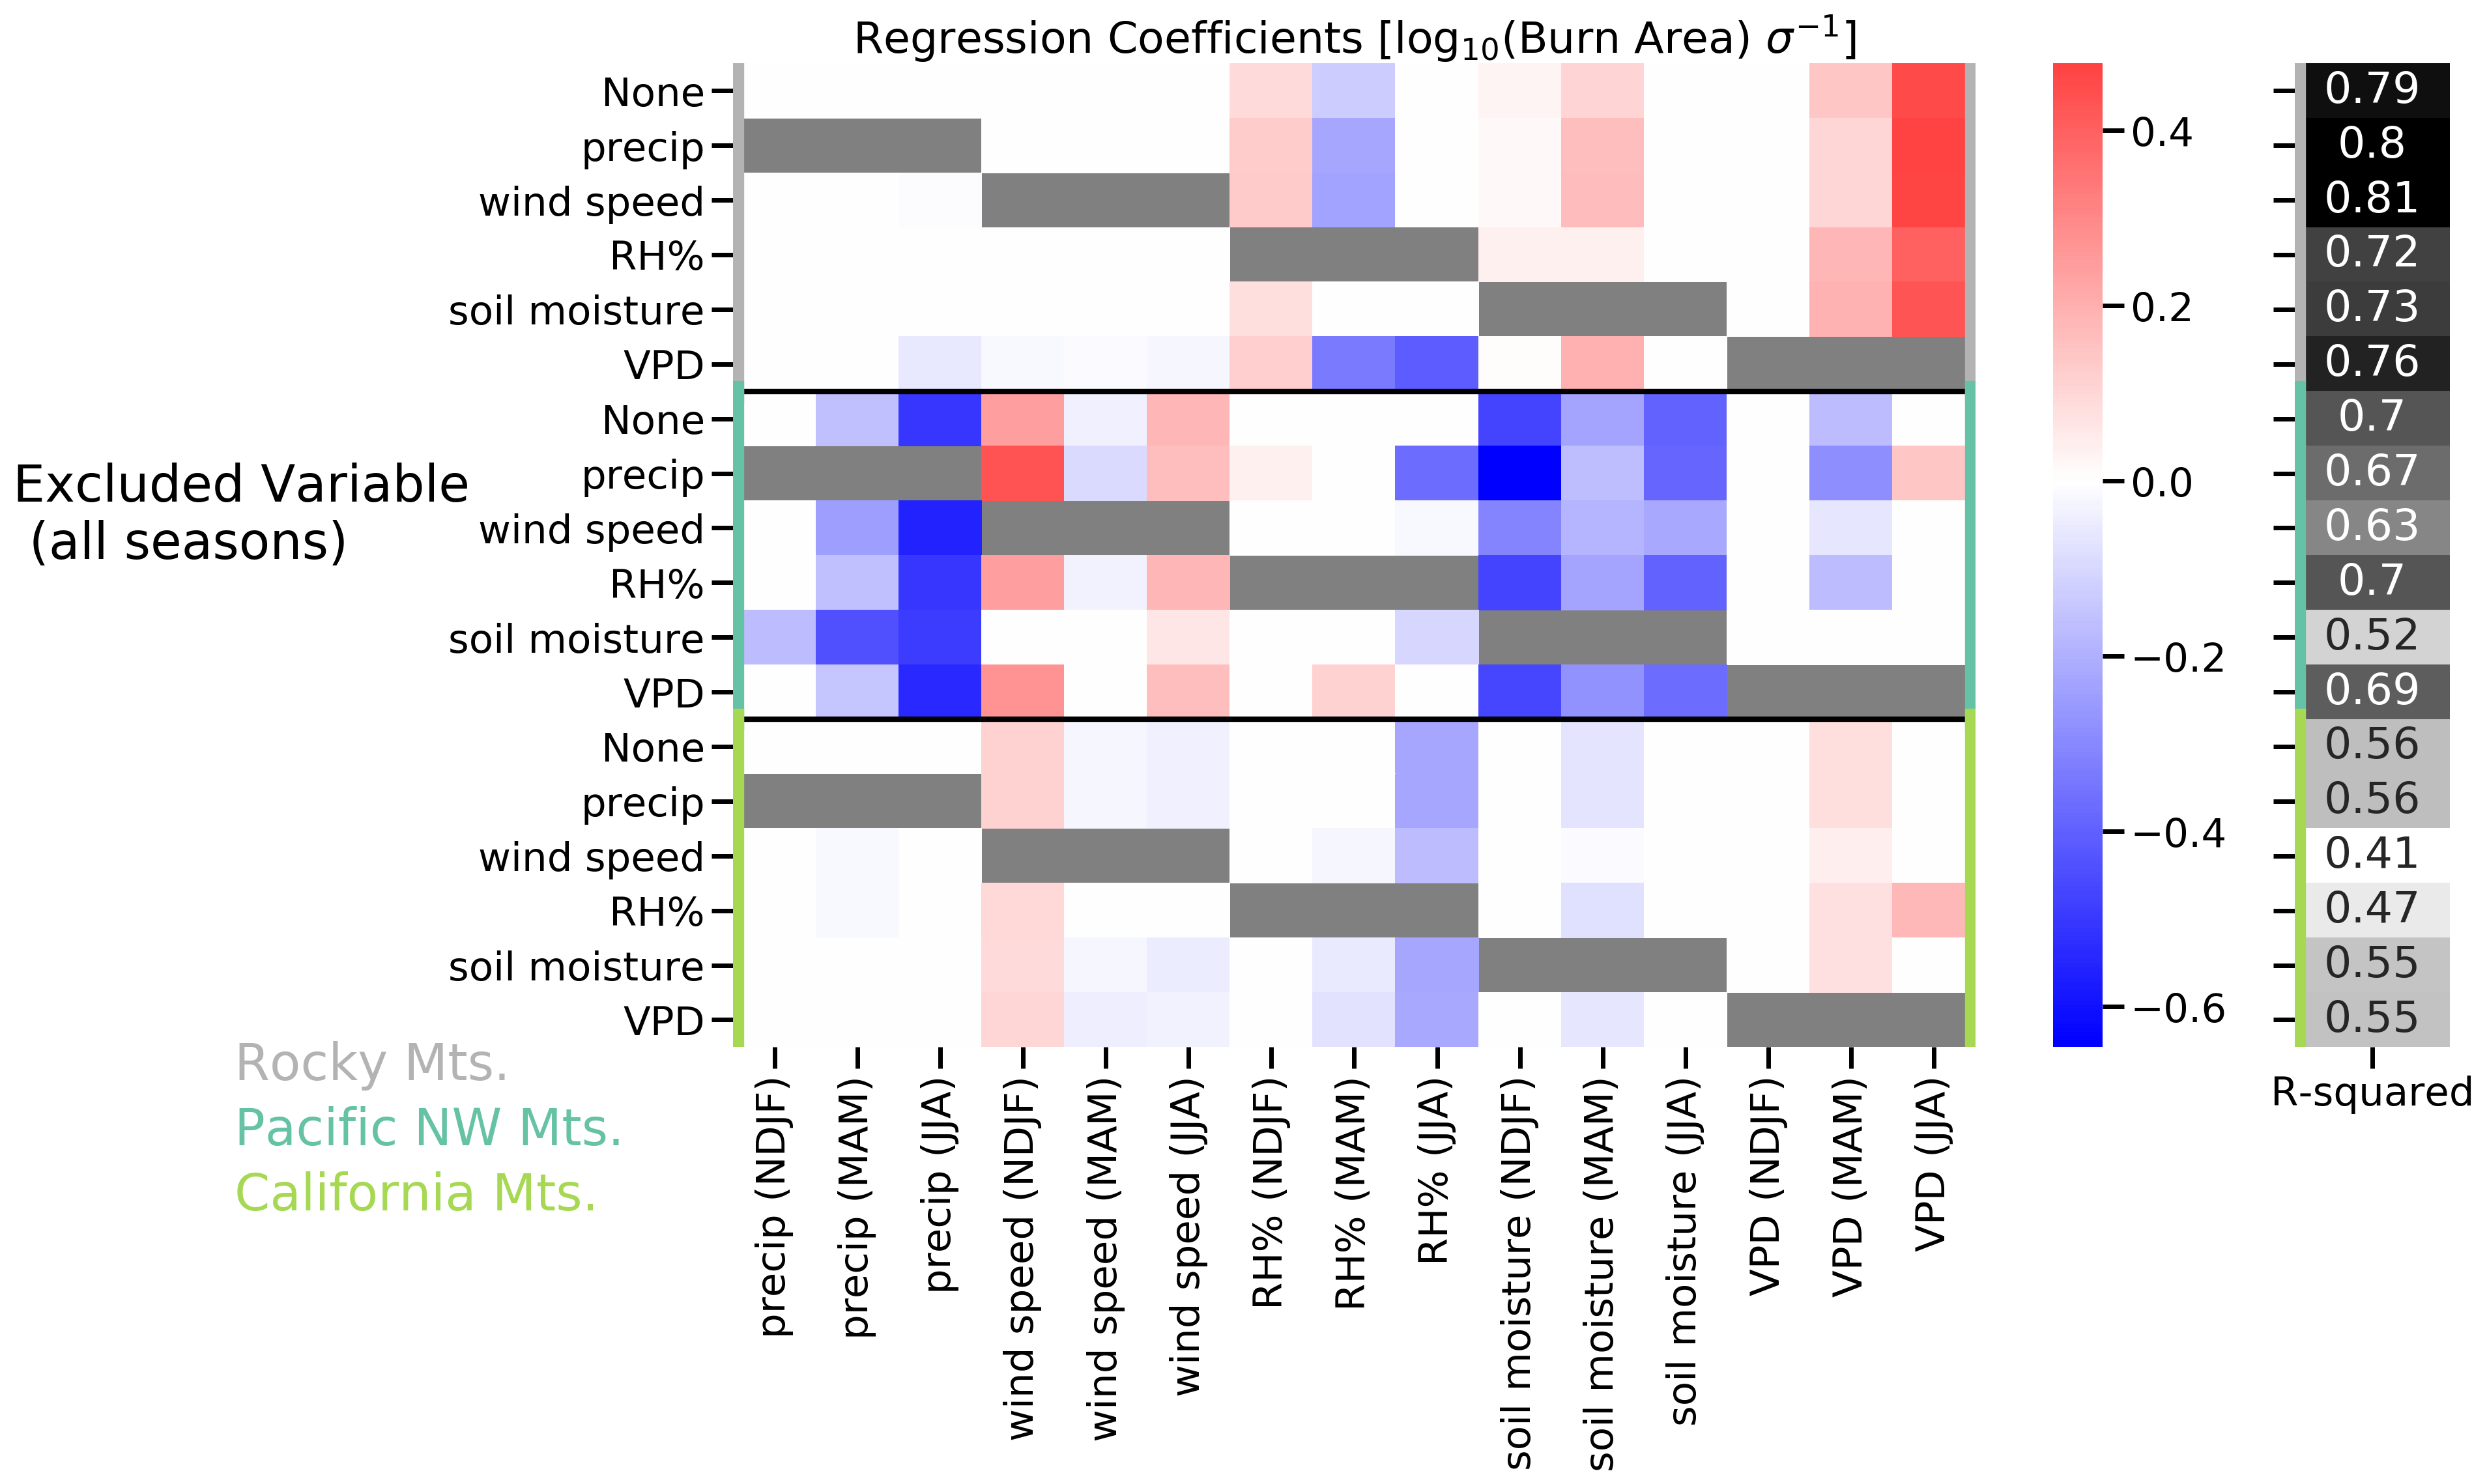

In [146]:
coef_df_list = []
coef_div_names = []
Rs_df_list = []

# Crazy indexing to get regions in desired order 
for k in divisions[:-1][[1, 0, 2]] : 
    print(k)
    coef_df_list.append(feature_left_out_ceof_dict[k])
    coef_div_names.append(k)
    Rs_df_list.append(feature_left_out_Rs_dict[k])
    
# Contact lists to make nice DataFrames of the information    
all_divs_ceofs = pd.concat(coef_df_list)
all_divs_Rs = pd.concat(Rs_df_list)

# Change the variable names to nice versions for plotting 
xticklabels = all_divs_ceofs.columns.str.replace("_", " ").str.replace("winter", "(NDJF)").str.replace("summer", "(JJA)")\
.str.replace("hurs", "RH%").str.replace("spring", "(MAM)").str.replace('mrlsl.integrated', "soil moisture")\
.str.replace("sfcWind", "wind speed").str.replace("pr", "precip")

yticklabels = all_divs_ceofs.index.str.replace("pr", "precip").str.replace("sfcWind", "wind speed")\
.str.replace('mrlsl.integrated', "soil moisture").str.replace('hurs', "RH%")

with sns.plotting_context("poster") :

    # TODO: Show r-squared on this plot 
    #xticklabels = ndf.loc[lasso_all_coefs.columns.values, "nice_name"]
    #f, ax = plt.subplots(figsize=(15, 10), dpi=200)
    f, (ax,ax2) = plt.subplots(ncols=2, figsize=(17, 10), dpi=200)
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[10, 1]) 
    ax = plt.subplot(gs[0])
    
    f.subplots_adjust(wspace=0.01)

    sns.heatmap(all_divs_ceofs, cbar=True,
                center=0, cmap="bwr", ax=ax,
                xticklabels=xticklabels, yticklabels=yticklabels)
    
    # Set a background color 
    ax.set_facecolor('gray')
    ax.set(xlabel="", ylabel="", 
            title="Regression Coefficients [log$_{10}$(Burn Area) $\\sigma^{-1}$]")
    #f.text(x=0.78, y=.05, s="log$_{10}$(Burn Area) $\\sigma^{-1}$")
    f.text(s="Excluded Variable\n (all seasons)", rotation=0, fontsize=28,
           x=-0.2, y=0.5, color='k')
    
    # Label the different regions being plotted 
    ax.axhline(y=6, linewidth=3, color="k", linestyle="-")
    ax.axvline(x=15, ymin=2/3, ymax=1, linewidth=12, color=rocky_color, linestyle="-")
    ax.axvline(x=0, ymin=2/3, ymax=1, linewidth=12, color=rocky_color, linestyle="-")
    
    ax.axhline(y=12, linewidth=3, color="k", linestyle="-")
    ax.axvline(x=15, ymin=1/3, ymax=2/3, linewidth=12, color=pnw_color, linestyle="-")
    ax.axvline(x=0, ymin=1/3, ymax=2/3, linewidth=12, color=pnw_color, linestyle="-")
     
    #ax.axhline(y=17.9, linewidth=10, color="k", linestyle="-")
    ax.axvline(x=15, ymin=0, ymax=1/3, linewidth=12, color=cal_color, linestyle="-")
    ax.axvline(x=0, ymin=0, ymax=1/3, linewidth=12, color=cal_color, linestyle="-")
    
    f.text(x=-0.1, y=.1,  s="Rocky Mts.", color=rocky_color, fontsize=28)
    f.text(x=-0.1, y=.05, s="Pacific NW Mts.", color=pnw_color, fontsize=28)
    f.text(x=-0.1, y=.00, s="California Mts.", color=cal_color, fontsize=28)
    
    # R-squared values side-by-side 
    ax2 = plt.subplot(gs[1])
    r = sns.heatmap(all_divs_Rs, ax=ax2, cbar=False,
                    annot=True, cmap='Greys')# ListedColormap(['gray'])
    r.set(yticklabels=[])
    
    ax2.axvline(x=0, ymin=2/3, ymax=1, linewidth=12, color=rocky_color, linestyle="-")
    ax2.axvline(x=0, ymin=1/3, ymax=2/3, linewidth=12, color=pnw_color, linestyle="-")
    ax2.axvline(x=0, ymin=0, ymax=1/3, linewidth=12, color=cal_color, linestyle="-")
    
    plt.savefig(os.path.join(save_dir_base, "feature_left_out_heatmap_rs.png"), 
                bbox_inches='tight')    

    plt.show()

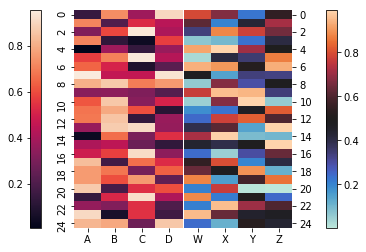

In [96]:
df =  pd.DataFrame(np.random.rand(25,4), columns=list("ABCD"))
df2 = pd.DataFrame(np.random.rand(25,4), columns=list("WXYZ"))

fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)
sns.heatmap(df, cmap="rocket", ax=ax, cbar=False)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(df2, cmap="icefire", ax=ax2, cbar=False)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.2)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
plt.show()

Run the original code without orders changed in case there are forgotton downsteam dependencies on that structure. 

Marine Regime Mountains
Temperate Steppe Regime Mountains
Mediterranean Regime Mountains


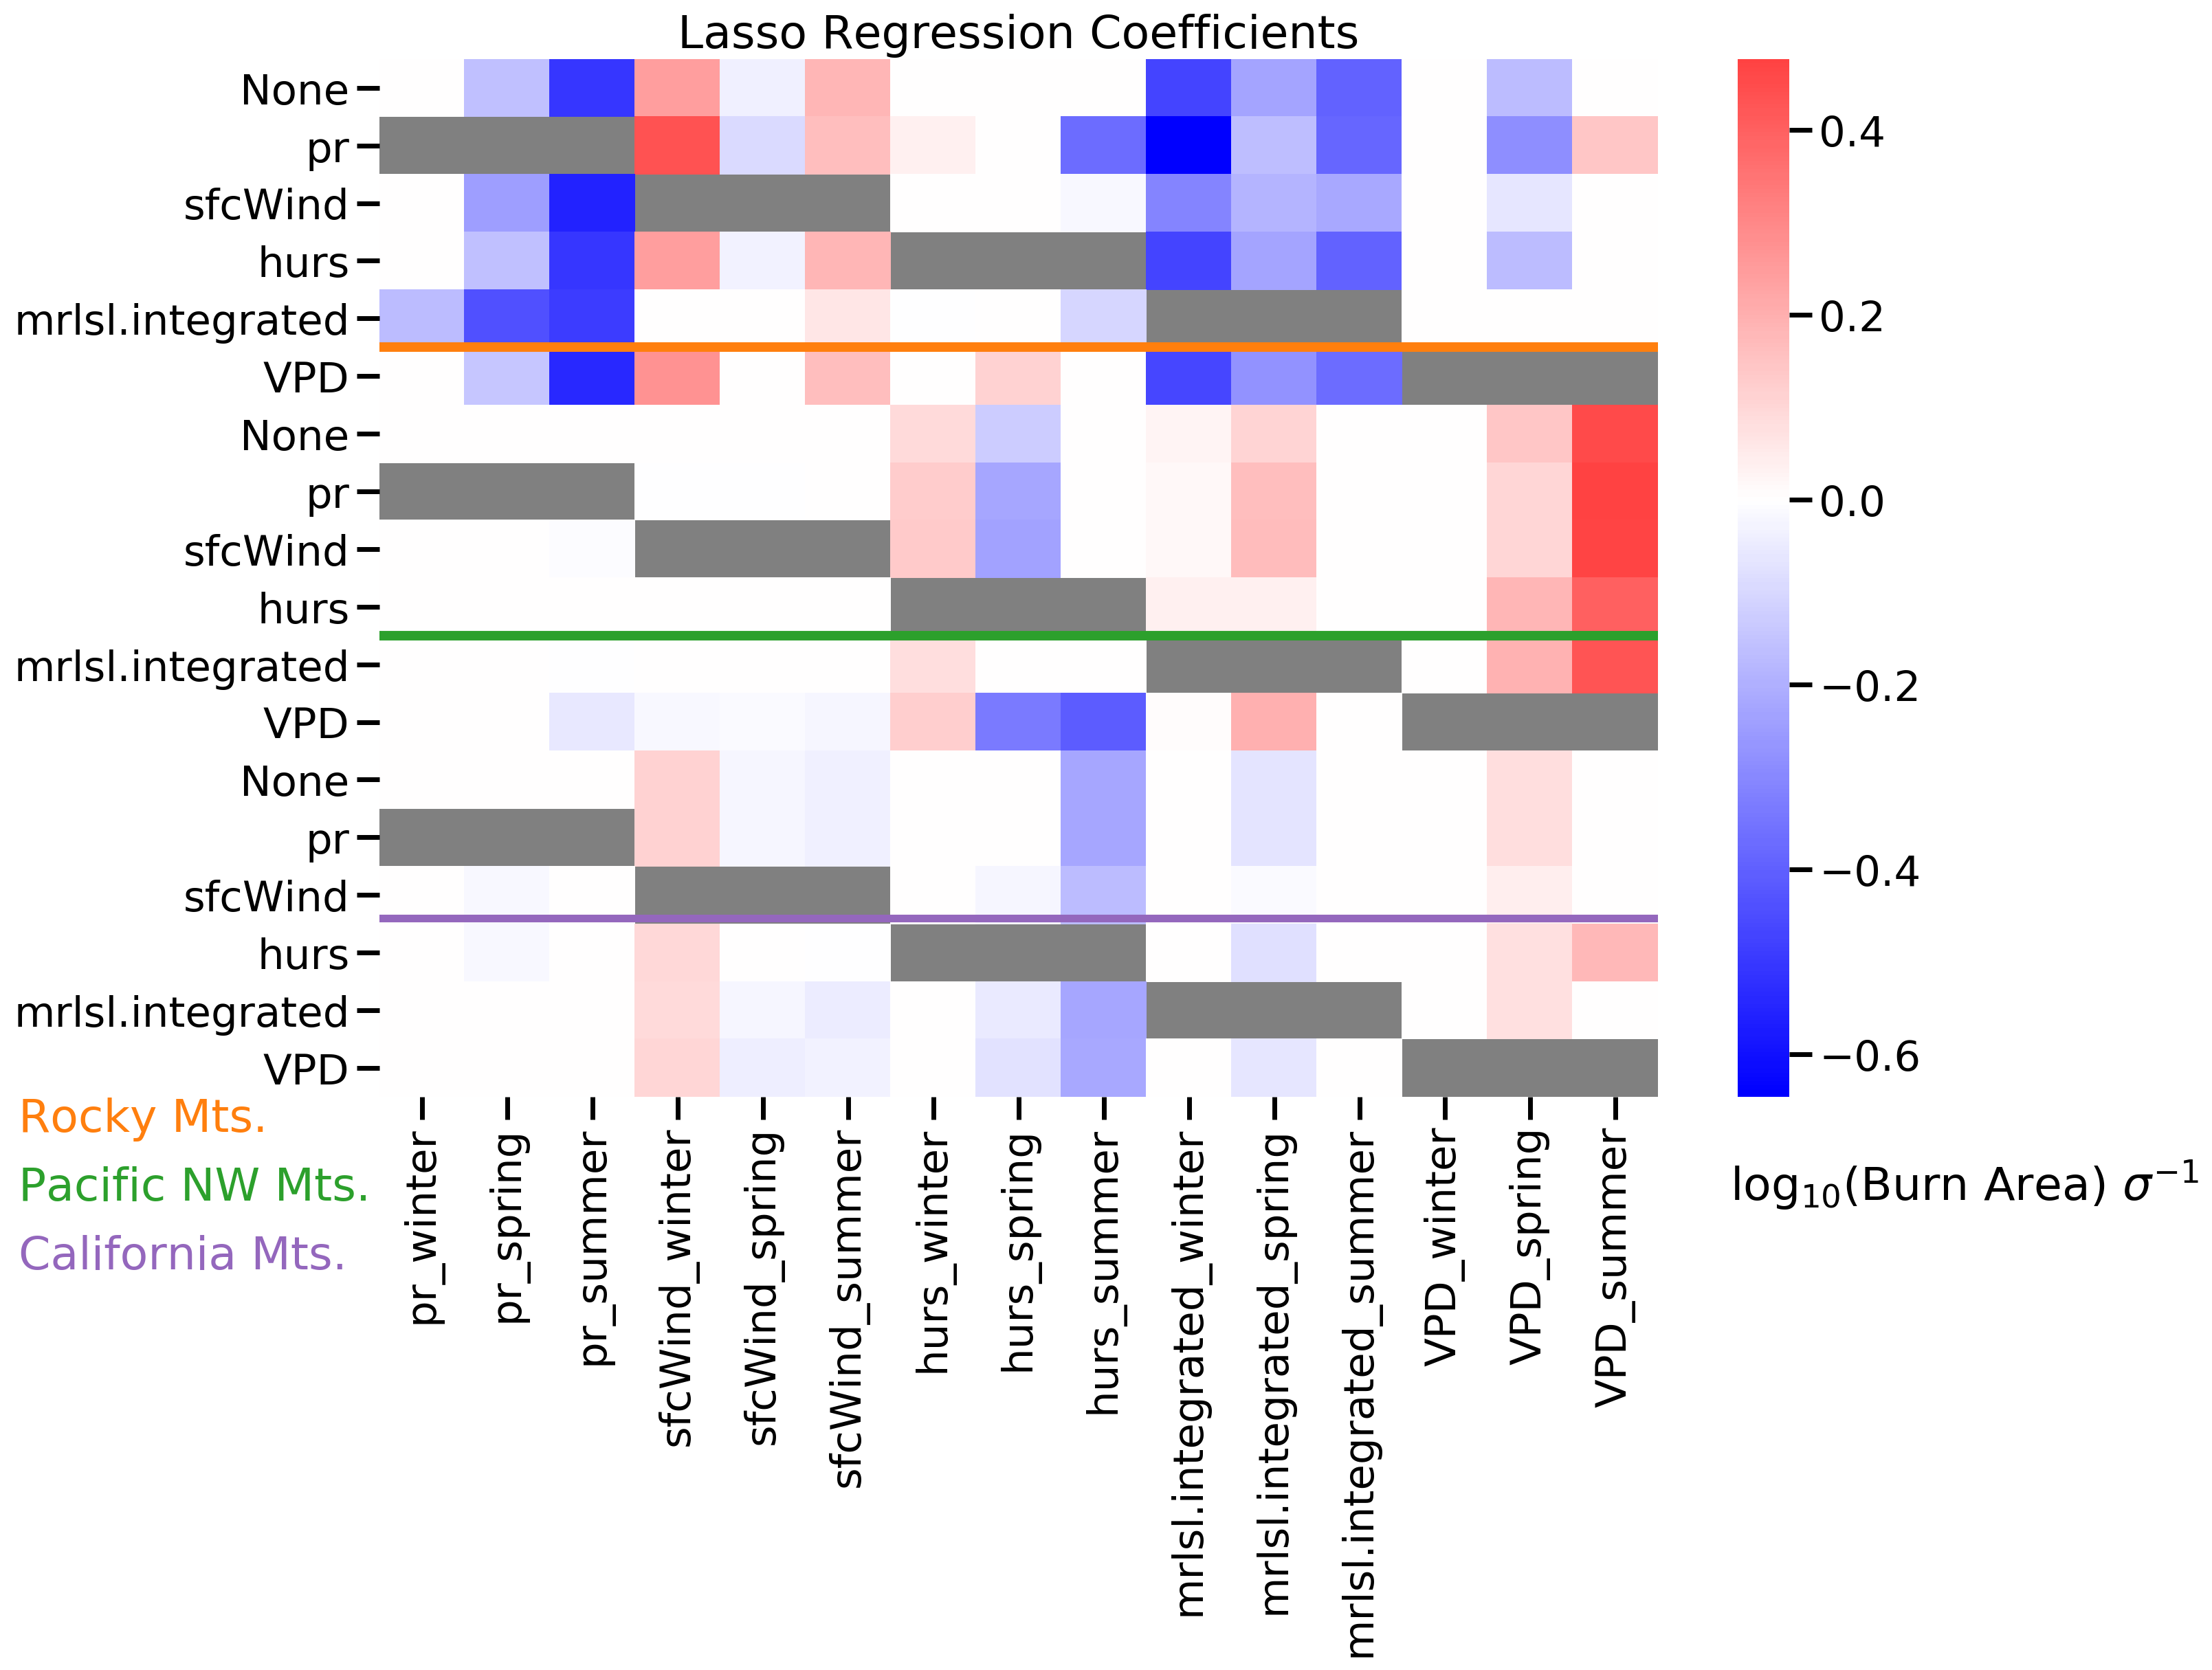

In [97]:
coef_df_list = []
coef_div_names = []
Rs_df_list = []

# Crazy indexing to get regions in desired order 
for k in divisions[:-1] : 
    print(k)
    coef_df_list.append(feature_left_out_ceof_dict[k])
    coef_div_names.append(k)
    Rs_df_list.append(feature_left_out_Rs_dict[k])
    
# Contact lists to make nice DataFrames of the information    
all_divs_ceofs = pd.concat(coef_df_list)
all_divs_Rs = pd.concat(Rs_df_list)

with sns.plotting_context("poster") :

    # TODO: Show r-squared on this plot 
    #xticklabels = ndf.loc[lasso_all_coefs.columns.values, "nice_name"]
    f, ax = plt.subplots(figsize=(15, 10), dpi=200)
    ax1 = sns.heatmap(all_divs_ceofs, 
                      center=0, cmap="bwr")#, xticklabels=xticklabels)

    # Set a background color 
    ax1.set_facecolor('gray')

    ax1.set(xlabel="", ylabel="", 
            title="Lasso Regression Coefficients")
    f.text(x=0.78, y=.05, s="log$_{10}$(Burn Area) $\\sigma^{-1}$")
    
    # Label the different regions being plotted 
    ax1.axhline(y=5, linewidth=5, color="C1", linestyle="-")
    ax1.axhline(y=10, linewidth=5, color="C2", linestyle="-")
    ax1.axhline(y=14.9, linewidth=4, color="C4", linestyle="-")
    
    #plt.text(x=-10, y=4, s=coef_div_names[0])
    #plt.text(x=-10, y=11, s=coef_div_names[1])
    #plt.text(x=-10, y=18, s=coef_div_names[2])

    f.text(x=-0.05, y=.1, s="Rocky Mts.", color="C1")
    f.text(x=-0.05, y=.05, s="Pacific NW Mts.", color="C2")
    f.text(x=-0.05, y=.00, s="California Mts.", color="C4")
    
    plt.savefig(os.path.join(save_dir_base, "feature_left_out_heatmap.png"), 
                bbox_inches='tight')    

    plt.show()

### Show spread in model estimates for this perspective 

In [98]:
feature_left_out_model.keys()

dict_keys(['Marine Regime Mountains', 'Temperate Steppe Regime Mountains', 'Mediterranean Regime Mountains', 'western_US'])

In [99]:
feature_left_out_model['Marine Regime Mountains'].keys()

dict_keys(['None', 'pr', 'sfcWind', 'hurs', 'mrlsl.integrated', 'VPD'])

In [100]:
features_used_by_model.keys()

dict_keys(['Marine Regime Mountains', 'Temperate Steppe Regime Mountains', 'Mediterranean Regime Mountains', 'western_US'])

In [101]:
features_used_by_model['Marine Regime Mountains']['pr']

array(['sfcWind_winter', 'sfcWind_spring', 'sfcWind_summer',
       'hurs_winter', 'hurs_spring', 'hurs_summer',
       'mrlsl.integrated_winter', 'mrlsl.integrated_spring',
       'mrlsl.integrated_summer', 'VPD_winter', 'VPD_spring',
       'VPD_summer'], dtype=object)

### Do basically the same thing again only leaving out a year of data <a class="anchor" id="year-left-out-fits"></a>

In [102]:
year_left_out_coef_dict = {}
year_left_out_model_dict = {}
years_used_by_model_dict = {}

div_y = {}

# Turn warnings back on 
warnings.filterwarnings('default')

for div in divisions[:-1] :

    print("Training year left out models for {}".format(div))
    
    # For each div, each feature left out gets its own fit model 
    year_left_out_model_dict[div] = {}
    years_used_by_model_dict[div] = {}

    print("Finding coef unc for {} :".format(div))

    ##########################################################################
    # Handle transformations of the target (burn area)
    ##########################################################################
    y_original = y_seanonal_df.loc[:, div].copy()

    if transformation == "log10" :
        # We replace 0 values with 1 so that taking the base 10 logarithm is valid
        y_original.loc[y_original==0] = 1.
        y_log = np.log10(y_original.values)
        y_log_detrend = signal.detrend(y_log)
        y = y_log_detrend.copy()

        #div_ylog10[div] = y_log

    elif transformation == "none" : 
        # Do not alter the burn area, aside from taking the
        # autoregression (slope) away.
        y_detrend = signal.detrend(y_original)
        y = y_detrend.copy()

    else :
        raise ValueError("tansformation not reconized. Choose valid transformation.")
        
    div_y[div] = y.copy()

    ##########################################################################
    # Get the features for the div 
    ##########################################################################
    Z = Z_dict[div]

    # (features (no season) x features)
    example_years = y_seanonal_df.index.values
    year_left_out_coefs = pd.DataFrame(data=np.nan, columns=predictors,
                                       index=example_years)

    for year_left_out in example_years : #[1:-1] : 

        examples_used_mask = year_left_out != example_years
        print("Training without {}".format(year_left_out))

        # Fit the data using leave one out 
        m = LassoCV(cv=LeaveOneOut(), normalize=False, tol=tol, max_iter=max_iter)
        m.fit(X=Z.values[examples_used_mask, :], y=y[examples_used_mask])

        year_left_out_coefs.loc[year_left_out, :] = m.coef_

    year_left_out_coef_dict[div] = year_left_out_coefs.copy()
    
    print("")
print("done!")

Training year left out models for Marine Regime Mountains
Finding coef unc for Marine Regime Mountains :
Training without 1984
Training without 1985
Training without 1986
Training without 1987
Training without 1988
Training without 1989
Training without 1990
Training without 1991
Training without 1992
Training without 1993
Training without 1994
Training without 1995
Training without 1996
Training without 1997
Training without 1998
Training without 1999
Training without 2000
Training without 2001
Training without 2002
Training without 2003
Training without 2004
Training without 2005
Training without 2006
Training without 2007
Training without 2008
Training without 2009
Training without 2010
Training without 2011
Training without 2012
Training without 2013
Training without 2014
Training without 2015
Training without 2016

Training year left out models for Temperate Steppe Regime Mountains
Finding coef unc for Temperate Steppe Regime Mountains :
Training without 1984
Training without 1985

In [103]:
# Join into a single easy to plot dataframe
coef_df_list = []
coef_div_names = []
for k in year_left_out_coef_dict.keys() :
    print(k)
    coef_df_list.append(year_left_out_coef_dict[k])
    coef_div_names.append(k)
    
all_divs_year_out_coefs = pd.concat(coef_df_list, axis=1)

Marine Regime Mountains
Temperate Steppe Regime Mountains
Mediterranean Regime Mountains


In [104]:
year_left_out_coef_dict[k].shape

(33, 15)

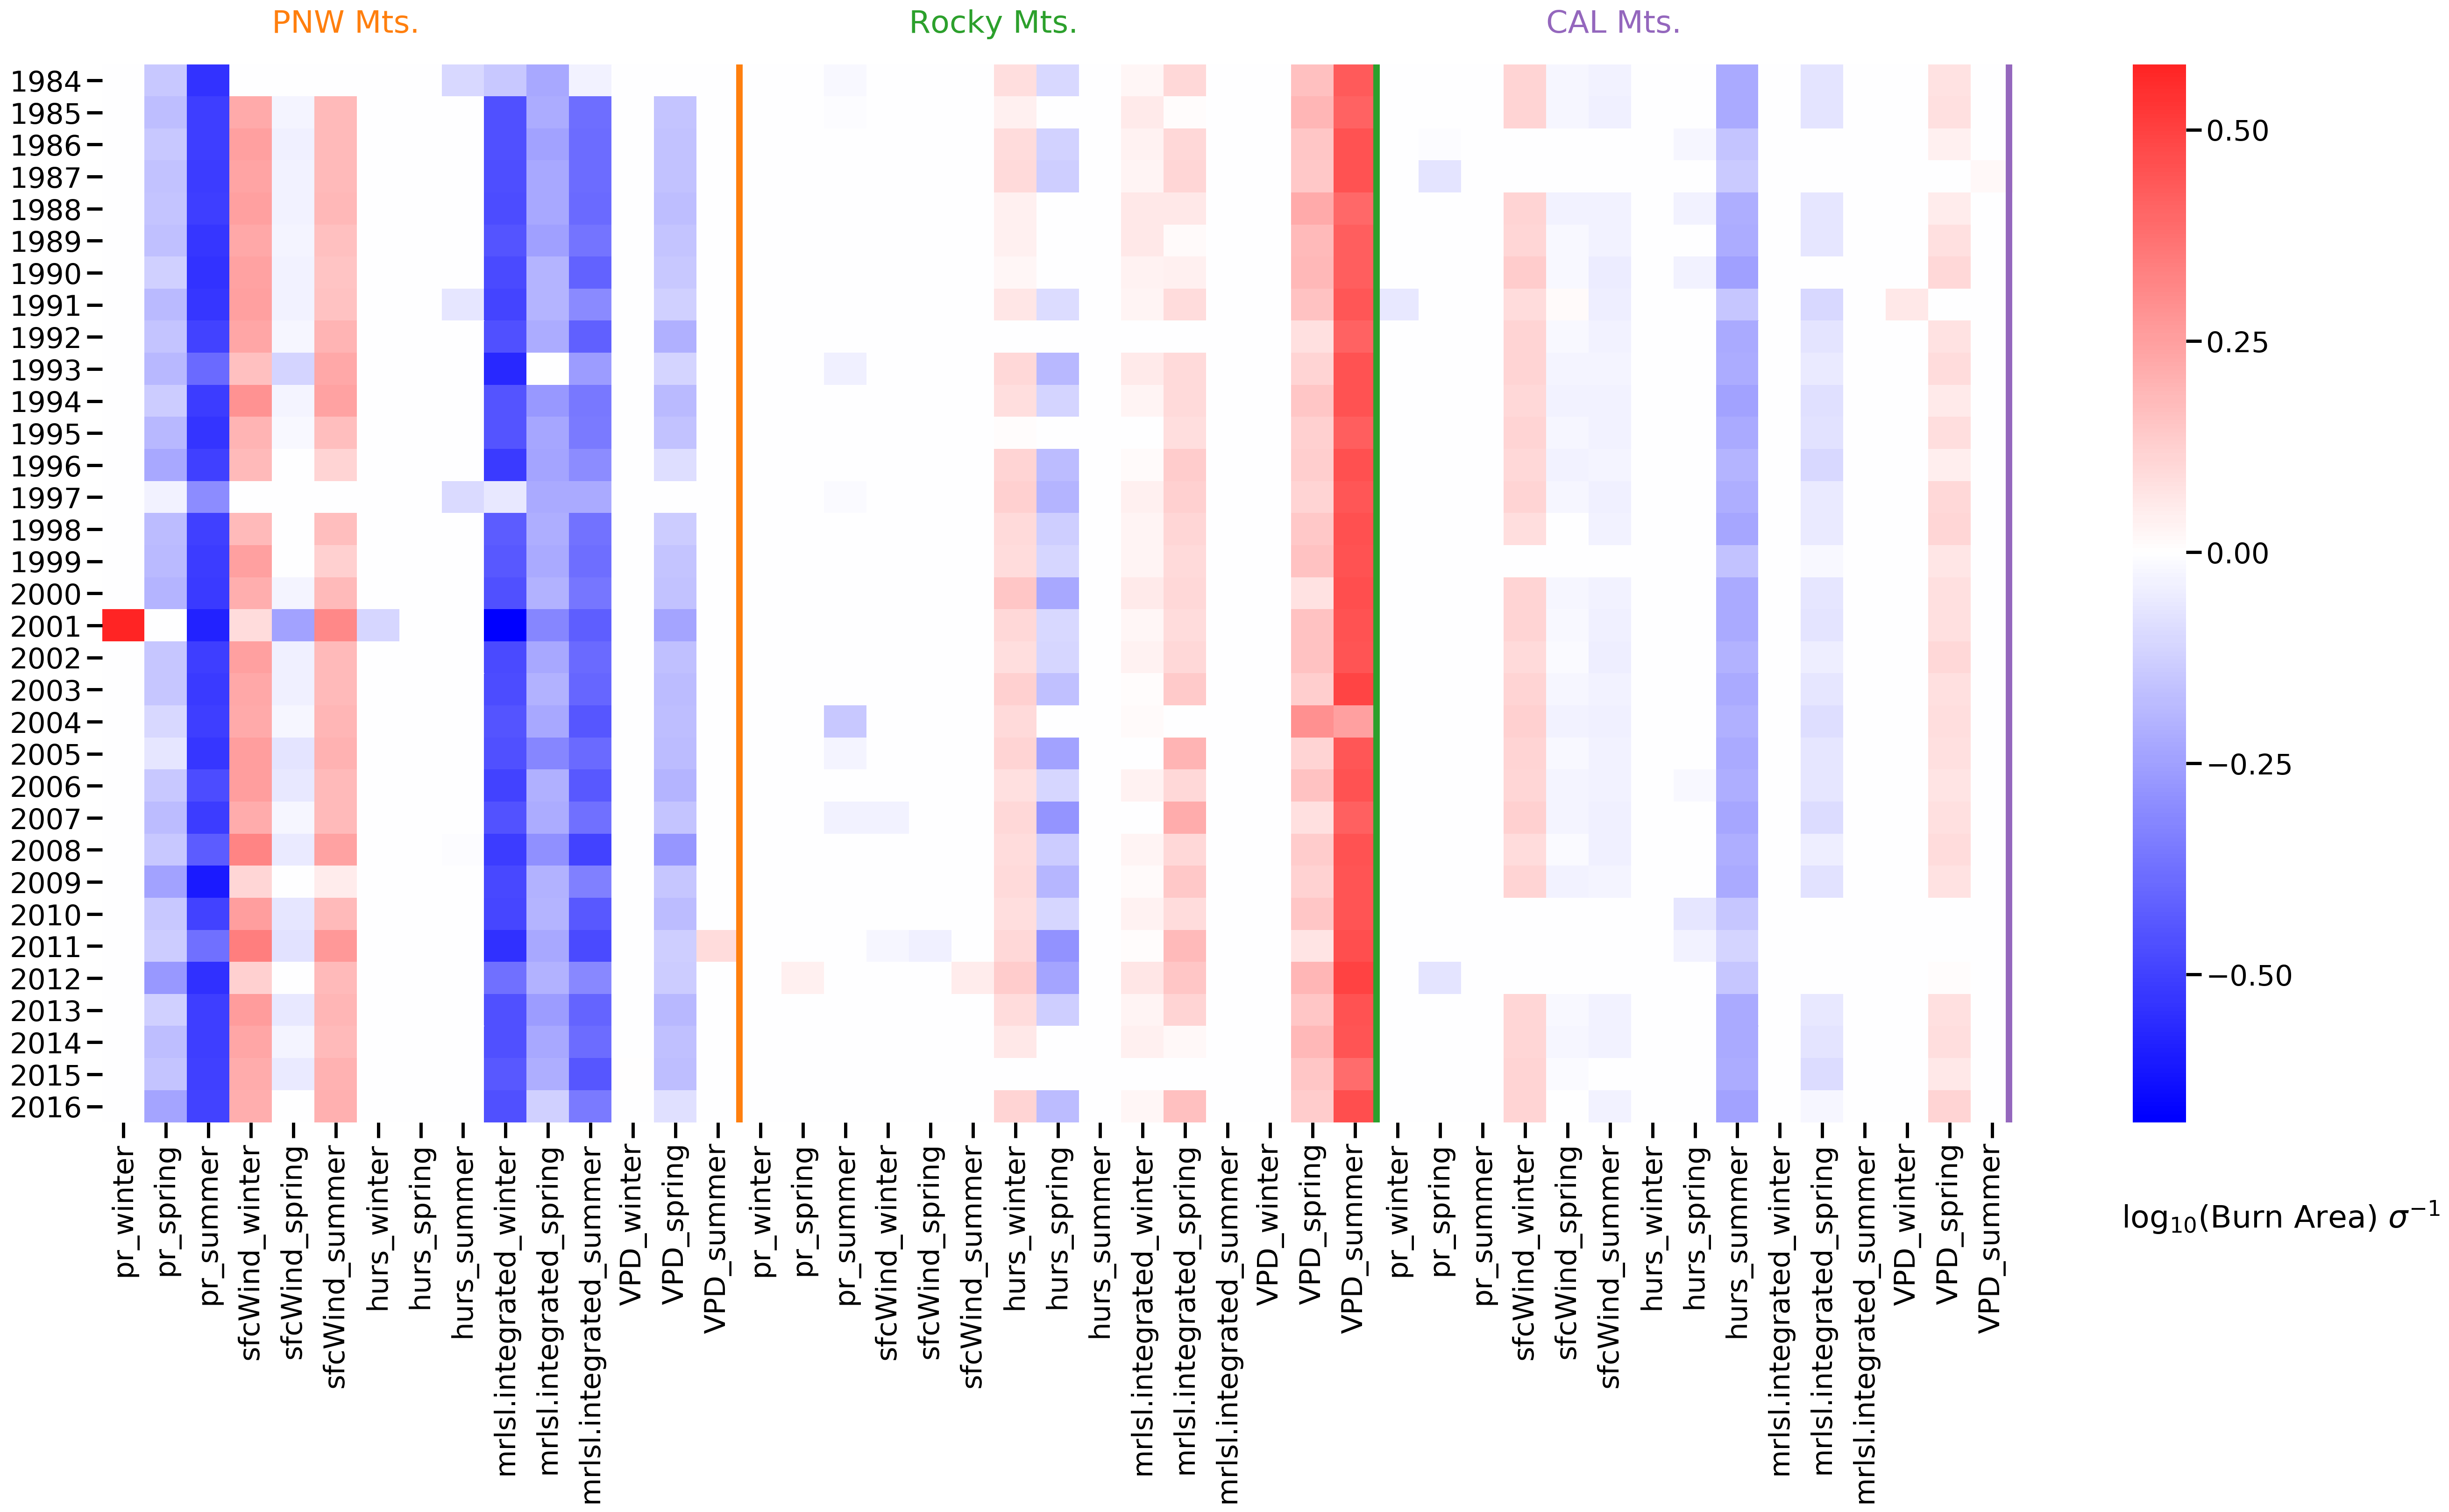

In [105]:
with sns.plotting_context("poster") :

    #xticklabels = ndf.loc[lasso_all_coefs.columns.values, "nice_name"]
    f, ax = plt.subplots(figsize=(33, 15), dpi=200)
    ax1 = sns.heatmap(all_divs_year_out_coefs, 
                      center=0, cmap="bwr")#, 
                      #vmin=-1, vmax=1)#, xticklabels=xticklabels)

    ax1.axvline(x=15, linewidth=5, color="C1", linestyle="-")
    ax1.axvline(x=30, linewidth=5, color="C2", linestyle="-")
    ax1.axvline(x=44.9, linewidth=5, color="C4", linestyle="-")
        
    # Set a background color 
    ax1.set_facecolor('gray')

    ax1.set(xlabel="", ylabel="", title="")
    f.text(x=0.78, y=.05, s="log$_{10}$(Burn Area) $\\sigma^{-1}$")

    # Label the divisions bro
    fudge = 4
    ax1.text(x=0+fudge, y=-1, s="PNW Mts.", color="C1")
    ax1.text(x=15+fudge, y=-1, s="Rocky Mts.", color="C2")
    ax1.text(x=30+fudge, y=-1, s="CAL Mts.", color="C4")
    
    plt.savefig(os.path.join(save_dir_base, "year_left_out_heatmap.png"), 
                bbox_inches='tight')
                
    plt.show()

**NOTE:** Different divisions will need different variables, based on where coefs are greater than zero, so
different divisions will have different models and total models with availability. 

# Back to code written before rejection

# Examine selected variables spread in CMIP5 data from RCP45 and RCP85 <a class="anchor" id="CMIP5-setup"></a>
#### For a given division (ecoregion)
- What predictors are required based on non-zero coefs? 
- Get those predictors loaded into a DataFrame [month x variable]
    - Make sure this is the same size (same # of columns and column names) as X_monthly. That way coeficients from the lasso can be applied across columns. 
- Make into seasonal predictors, using make_monthly_seasonal(), exactly same method as for era-iterim data
- Repeat last two bullet-points for all available CMIP5 models

In [106]:
def get_cmip5_nc(var, rcp, model, spatial_mask, spatial_mean=False, inspect=False):
    """
    This function will be for loading a particular CMIP5 NetCDF file, which will be spatially subset 
    by this function. These CMIP5 model output to be loaded have been regridded to the "Common grid" 
    using $ cdo remapbil. Defualts to taking the spatial mean of all global data for the var argument. 
    Change area loaded using the minX, maxX, etc. arguments. 
    
    Parameters
    ----------
        var : str, The CMIP5 variable name to be loaded. File names match variable names. 
        rcp : str, "45" or "85", refers to representative concentration pathway. 
        model : The name of the model that created the var, to be loaded from. 
        spatial_mask : numpy array, where equal to 1 (True) are locations to mask, meaning
                       they will NOT be used in calculations, spatial means, etc. 
        spatial_mean : Boolean, if False (default) the data  will be returned on a 
                       [t, lon, lat] grid. 
    
    Return
    ------
        valsCut : array[month, lat, lon] for the chosen spatial extent or 
                  array[month] spatial mean for the chosen spatial extent. 
        t_mon : array of months as pd.date_range object. 
        lon : array of longitude values that were used aftering trimming the global data
        lat : array of latitude values that were used after trimming the global data
    
    """
        
        
    # TODO: Mask out nans also! 
        
    if var == 'mrso' :
        domain = 'Lmon'
    elif var == 'mrlsl.integrated' :
        domain = 'Lmon'
    else :
        domain = 'Amon'
        
    # Create link to the monthly file in this projects directory structure. 
    dataDir = os.path.join(".." ,"Data" ,"CMIP5" ,'r1i1p1_rcp_COMMON_GRID')
    f = var + "_" + domain + "_" + model + "_rcp" + rcp + "_r1i1p1_198301-210012.nc"
    
    if inspect :
        print(f)
        
    loadFile = os.path.join(dataDir, f)
    
    # Check to see if the file exists! Data logs indicate that not all requests exist
    if(not os.path.isfile(loadFile)):
        raise ValueError(f+ " File does not exist")
    
    # Load the nc data
    nc = Dataset(loadFile)
    vals = nc.variables[var][:]
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    
    # Create a new array, where each time slice will be a masked version 
    # of the data loaded from the nc file 
    vals_masked = np.ma.empty(shape=vals.shape)
    
    # Pandas handling of time so all models have the exact same origin and such. 
    # TODO: handle required changes to this section for when historical CMIP5 data
    # TODO: are also used. 
    t = nc.variables["time"]
    if(len(t) == 1416) :
        # Convert to pandas time array, on the assumption t[0]=2006-01 & t[-1]=2100-12
        t_mon = pd.date_range("1983-01-01", periods=len(t), freq="M")
    else:
        raise ValueError('Error in number of months for file: '+ f + " 1416 expected.")
        
    # Now subset the data based on the passed spatial_mask
    for i in range(len(t)) : 
        vals_masked[i,:,:] = np.ma.masked_array(vals[i,:,:], mask=spatial_mask, copy=True)
    
    # Now, take the mean value in this spatial domain. Note, the 
    # same is done to the era-interim data using the method:
    # get_era_nc_vals()
    if spatial_mean :
        
        # There is some extra stuff in here to make sure that
        # values of np.nan for soil moisture also get masked. 
        # i.e., in short, this masked all np.nan values too 
        # when time means of the division masked values are taken. 
        
        spatial_mask_3d = vals_masked.mask
        nan_mask = np.isnan(vals_masked.data)
        combined_mask = spatial_mask | nan_mask
        vals_masked_new = np.ma.array(vals_masked, mask=combined_mask)
        
        spatial_mean_values = np.ma.mean(vals_masked_new, axis=(1,2))
        vals_masked = spatial_mean_values.data # if you do not do this, forces dtype object in dataframe. 
                    
        if False :
            
            print("Spatial Mask types")
            print(type(spatial_mask_3d))
            print(spatial_mask_3d.shape)
            print("nan_mask")
            print(type(nan_mask))
            print(nan_mask.shape)
            print("combined_mask")
            print(type(combined_mask))
            print(combined_mask.shape)
            print("vals_masked_new")
            print(vals_masked_new.shape)
        
    nc.close()
    
    return vals_masked, t_mon, lon, lat

Get an array with all possible models available. 

In [107]:
import glob as glob
DIR = os.path.join("..","Data", "CMIP5", "r1i1p1_rcp_COMMON_GRID")

all_model_names = []
all_files = glob.glob(DIR+"/tas_Amon*")
for f in all_files :
    all_model_names.append(f.split("/")[4].split("_")[2])
unique_model_names = np.unique(all_model_names)
print(unique_model_names)

['ACCESS1-0' 'ACCESS1-3' 'CCSM4' 'CMCC-CESM' 'CMCC-CM' 'CMCC-CMS'
 'CNRM-CM5' 'CSIRO-Mk3-6-0' 'CanESM2' 'FGOALS-g2' 'GFDL-CM3' 'GFDL-ESM2G'
 'GFDL-ESM2M' 'GISS-E2-H' 'GISS-E2-H-CC' 'GISS-E2-R' 'GISS-E2-R-CC'
 'HadGEM2-AO' 'HadGEM2-CC' 'HadGEM2-ES' 'IPSL-CM5A-LR' 'IPSL-CM5A-MR'
 'IPSL-CM5B-LR' 'MIROC-ESM' 'MIROC-ESM-CHEM' 'MIROC5' 'MPI-ESM-LR'
 'MPI-ESM-MR' 'MRI-CGCM3' 'MRI-ESM1' 'NorESM1-M' 'NorESM1-ME'
 'bcc-csm1-1-m' 'inmcm4']


In [108]:
# Make a list of all the base features names 
all_vars = atmos_vars + plant_vars 
all_vars

['tas', 'pr', 'sfcWind', 'hurs', 'mrlsl.integrated', 'VPD']

## Load the CMIP5 variables needed for each regression
- This is down with following functions
    - get_CMIP5_features()
    - load_regression_cmip5_data()

In [109]:
def get_CMIP5_features(divisions, cmip_models, coefs_df, rcp, all_vars, Z_dict, inspect = False) :
    """
    
    Function for loading as much CMIP5 data as is available for a given division. Only the variables
    variables with non-zero ceofs from the lasso regression fit coefs passed in "regression_results_df"
    will be requested for a given division, boosting the number of models with all required data. 
    
    Parameters
    ----------
        divisions : np.array or list of the divisions to aquire CMIP5 data for. 
        cmip5_models : list, the names of the cmip5 models to attempt to get data from. 
        coefs_df : Has the results of the regression of interest coeficients. 
                                It is used to make sure only cmip vars with non-zero reg coefs
                                are loaded. The rest would be a waste of time. They are left nan. 
        rcp : str, "45" or "85", the rcp scenario of the data to load.
        all_vars : a list that contains the names of all possible variables to load. This creates 
                   a record of what cmip data is missing. Not used for anything else, will likely
                   be hardcoded in future updates. 
        Z_dict : The dictionary containing all the era-features used for regression, used to make
                 sure that the CMIP data that are loaded are stored in a dataframe with the same
                 dimensionality and column order as the X features used to train regression. 
        inspect : logical, True turns on many print statements, False (defualt) turns off print statements. 
        
    returun
    -------
        div_CMIP_dict : A dictionary of dictionaries. Same dimensionality of the X features
                        used to train the associated divisions regression. 
        division_data_availability : Shows what models were available for a given division. 
                                     csv of these data are written. 
        missing_cmip_data : shows which and how often cmip data needed are missing. 
    
    """
    # Dictionary of dictionaries, this is the level at which data
    # are separated by divisions. 
    div_CMIP_dict = {}

    # Create dataframes that store information on what data was available, used, and missing
    division_data_availability = pd.DataFrame(0, index=divisions, columns=["n_base_features", "n_models_available"]+list(cmip_models))
    missing_cmip_data = pd.DataFrame(0, index=cmip_models, columns=all_vars)

    # open connection to div mask nc file 
    grid_division_masks_file = os.path.join("..", "Data", "LandCover", "bailys_division_masks_common_grid.nc")
    div_mask_nc = Dataset(grid_division_masks_file, 'r') # Leave open till looking over divisions complete. 
    grid_lat = div_mask_nc.variables['lat'][:].data
    grid_lon = div_mask_nc.variables['lon'][:].data
    
    # loop through divisions. 
    for div in divisions :
        
        if True :
            print("-----------------------------------------------------")
            print(div)

        # Each entry in this dictionary will be the selected predictors 
        # in a dataframe for the division.
        div_CMIP_dict[div] = {}

        # Get the names of the features, with season
        feature_names = coefs_df.columns.copy()
        
        # Subset to those that are used for this division prediction 
        # i.e. regression abs(coefs) > 0.
        div_coefs = coefs_df.loc[div, feature_names].copy()
        needed_features_mask = np.abs(div_coefs) > 0
        needed_features = div_coefs.index.values[needed_features_mask]
        
        if inspect :
            print("needed features where np.abs(coef) > 0:")
            print(needed_features)

        # Get the names of the features to load without 
        # the seasonality "_season" component 
        needed_features_base = []
        for f in needed_features :
            s_loc = f.find("_")
            needed_features_base.append(f[:s_loc])
        needed_features_base = np.array(np.unique(needed_features_base))
        
        if inspect :
            print("Names of needed features before seasonal averages are created")
            print(needed_features_base)
        n_base_features = len(needed_features_base)

        # Store the number of needed predictors information 
        division_data_availability.loc[div, 'n_base_features'] = n_base_features

        # Get grid boxes to mask. Note: line below will be True 
        # for grid boxes to mask, i.e. to not use, mask is 1 where division located. 
        div_mask_file_request = div.replace("/", " ")
        print("mask requested",div_mask_file_request)
        div_mask = div_mask_nc.variables[div_mask_file_request][:].data == 0
        print("unique values of mask", np.unique(div_mask))
        print("shape of mask", np.unique(div_mask))
        
        plt.figure()
        plt.pcolor(np.array(div_mask, dtype=int) )
        plt.colorbar()
        plt.title(div_mask_file_request)
        plt.show()

        # Now we have to loop over models, all common features set 
        for cmip_model in cmip_models :

            if inspect :
                
                print("getting %s data" %cmip_model)

            # Create empty dataframe for monthgly data to be stored as loaded for individual
            # features types (tas, pr, ...)
            monthly_df = pd.DataFrame(np.nan, index=range(1416), columns=needed_features_base)

            # Keep track of how many variables are available 
            # for a given model 
            var_count = 0

            # Loop over needed variables to create the [month x feature] DataFrame
            for var in needed_features_base :

                try :
                    # NOTE: vals_masked is confirmed to be dtype float64
                    vals_masked, t_mon, _, _ = get_cmip5_nc(var, rcp, cmip_model, div_mask, 
                                                            spatial_mean=True,
                                                            inspect=inspect)
                    
                    monthly_df.loc[:,var] = vals_masked # np.array(vals_masked) removed
                    # TODO: keep track of what models have all needed predictors for each region. 
                    var_count += 1

                except ValueError :

                    # Show which models are missing what variables and how often here. 
                    missing_cmip_data.loc[cmip_model, var] += 1
                    if inspect :
                        print("Unable to load " + var + " for " + cmip_model)

            # If all base features needed were available. make monthly_df 
            # into a seasonal feature DataFrame
            if (var_count == n_base_features) and (n_base_features > 0) : 

                monthly_df.index = t_mon
                # Make monthly into season predictors 
                df = make_monthly_seasonal(monthly_df, t_mon)
                # Make the dataframe returned here have the same columns and dimensions
                # and order as Z_dict dataframes that trained the lasso. That way the 
                # model.predict() will be much easier. Leave not needed columns as nans. 
                all_col_df = pd.DataFrame(np.nan, index=df.index.copy(), columns=Z_dict[div].columns.values.copy())
                
                # Based on where the columns of df match those of the ERA colums in the Z 
                # division feature dataframe, store those values. 
                all_col_df.loc[:, df.columns] = df.copy()

                div_CMIP_dict[div][cmip_model] = all_col_df.copy()
                #div_CMIP_dict[div][cmip_model] = make_monthly_seasonal(monthly_df, t_mon)

                # Keep track of how many and which models had all the required output 
                division_data_availability.loc[div, "n_models_available"] += 1
                division_data_availability.loc[div, cmip_model] += 1

                if inspect :
                    print("All variables needed for " + cmip_model + " available.")
                    print("var count " + str(var_count) + " and length " + str(n_base_features))

            else :

                if inspect :
                    print(cmip_model + " model skipped available.")
                    print("var count " + str(var_count) + " and length " + str(len(needed_features_base)))

            del(monthly_df, var_count)

    # Save the data availability matricies
    # TODO: Fix the names of these files if you save them. It is not helpful unless they include the name of the 
    # TODO: regression in addition to the rcp
    #division_data_availability.to_csv(os.path.join(save_dir_base, 'division_data_availability_'+rcp+'.csv'))
    #missing_cmip_data.to_csv(os.path.join(save_dir_base, 'missing_cmip_data_'+rcp+'.csv'))
    # Close nc file connection
    div_mask_nc.close()
    
    return div_CMIP_dict, division_data_availability, missing_cmip_data

## USER INPUT REQUIRED IN THIS CELL
Save the DataFrames that show what data was used and what is missing. 

In [110]:
# When True, loads CMIP5 data even if dictionary saved to disk 
force_load = True 

f = os.path.join(save_dir_base, 'lasso_all_cmip_85_dict.obj')
(os.path.isfile(f)) 

False

In [111]:
def load_regression_cmip5_data(coef_df, regression_name, rcp, force_load=False) :
    """
    Loads the avialable CMIP5 data required to make projections given the 
    variables selected by a particular regression (lasso_all, plant_lass, atmos_lasso).
    This is done using the function get_CMIP5_features(). This simply manages some
    of the arguments passed to that function.
    
    Parameters
    ----------
        coef_df : pd.DataFrame containing the regression coeficients organized by divisions 
                  (index) and features (columns) of a particular regression 
                  (lasso_all, lasso_plant, lasso_atmos). 
        regression_name : str, name of the regression associated with the coef_df, usually
                          exactly the same as the name of the object passed to coef_df argument. 
        rcp : str, "85" or "45", the RCP of the CMIP5 data to load. 
        force_load : Boolean, when True forces that CMIP5 data be loaded from individual files
                     whether the requested dictionary exists on disk or not. Default, False. 
        
    return
    ------
        cmip_dict : A dictionary of dictionary organized as e.g. 
                    lasso_all_85_cmip5_dict[divisions[0]]['ACCESS1-0']. 
        TODO: Handle the writing of the dataframe that names the .csv for data availability.
    """
    
    # Print the globals used
    if False:
        print("save_dir_base")
        print(save_dir_base)
        print("divisions:")
        print(divisions)
        print("unique_model_names")
        print(unique_model_names)
        print("all_vars")
        print(all_vars)
        print("Z_dict.keys()")
        print(Z_dict.keys())

    save_name = regression_name + "_cmip_" + rcp + "_dict.obj"
        
    # Get needed CMIP5 model output for "lasso_all" regression
    f = os.path.join(save_dir_base, save_name)
    
    if ( not os.path.isfile(f) ) or force_load :

        print("Loading CMIP5 data required for " + regression_name + " " + rcp + " dictionary")

        # TODO: If statement that decides if this is available or should be created again. 
        cmip_dict, division_data_availability, missing_cmip_data = get_CMIP5_features(divisions, unique_model_names,
                                                                                      coef_df, rcp, 
                                                                                      all_vars, Z_dict, inspect=False)
        # Write the file to disk as an easy to read pickle
        with open(f, 'wb') as fp :
            pickle.dump(cmip_dict, fp)

    else :
        
        print(regression_name + " " + rcp + " dictionary being loaded from disk.")
        with open(f, 'rb') as fp:
            cmip_dict = pickle.load(fp)
            
    return cmip_dict

### New!
### Load the CMIP5 data for the variable left out models. 
- Below df_dummy is cooked up such that we require all variables. We do this because the number of models in this iteration of this analysis would be very confusing and messy. Also, we are using many fewer predictors than the orignal analysis so the number of models with all predictors required should be high no matter what. 

In [112]:
# New! 
feature_left_out_ceof_dict.keys()

dict_keys(['Marine Regime Mountains', 'Temperate Steppe Regime Mountains', 'Mediterranean Regime Mountains', 'western_US'])

In [113]:
# Create a dataframe that forces all variables be required together. 
# Comparing model spread for a changing number of CMIP5 models does not make
# sense in this new context. 
df_dummy = pd.DataFrame(
    data = np.full(
        (len(feature_left_out_ceof_dict.keys()), 
         len(feature_left_out_ceof_dict['Marine Regime Mountains'].columns)), 
        1
    ),
    columns = feature_left_out_ceof_dict['Marine Regime Mountains'].columns,
    index = feature_left_out_ceof_dict.keys(), 
)

df_dummy

pr_winter  pr_spring  pr_summer  \
Marine Regime Mountains                    1          1          1   
Temperate Steppe Regime Mountains          1          1          1   
Mediterranean Regime Mountains             1          1          1   
western_US                                 1          1          1   

                                   sfcWind_winter  sfcWind_spring  \
Marine Regime Mountains                         1               1   
Temperate Steppe Regime Mountains               1               1   
Mediterranean Regime Mountains                  1               1   
western_US                                      1               1   

                                   sfcWind_summer  hurs_winter  hurs_spring  \
Marine Regime Mountains                         1            1            1   
Temperate Steppe Regime Mountains               1            1            1   
Mediterranean Regime Mountains                  1            1            1   
western_US                                      1            1            1   

                                   hurs_summer  mrlsl.integrated_winter  \
Marine Regime Mountains                      1                        1   
Temperate Steppe Regime Mountains            1                        1   
Mediterranean Regime Mountains               1                        1   
western_US                                   1                        1   

                                   mrlsl.integrated_spring  \
Marine Regime Mountains                                  1   
Temperate Steppe Regime Mountains                        1   
Mediterranean Regime Mountains                           1   
western_US                                               1   

                                   mrlsl.integrated_summer  VPD_winter  \
Marine Regime Mountains                                  1           1   
Temperate Steppe Regime Mountains                        1           1   
Mediterranean Regime Mountains                           1           1   
western_US                                               1           1   

                                   VPD_spring  VPD_summer  
Marine Regime Mountains                     1           1  
Temperate Steppe Regime Mountains           1           1  
Mediterranean Regime Mountains              1           1  
western_US                                  1           1

Loading CMIP5 data required for var_out_CMIP5 85 dictionary
-----------------------------------------------------
Marine Regime Mountains
mask requested Marine Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


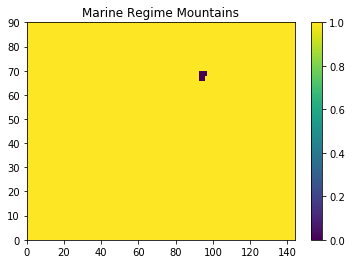

-----------------------------------------------------
Temperate Steppe Regime Mountains
mask requested Temperate Steppe Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


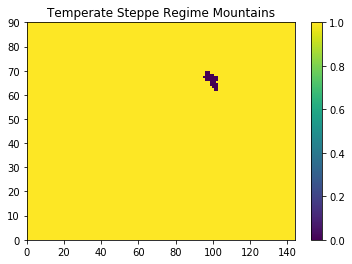

-----------------------------------------------------
Mediterranean Regime Mountains
mask requested Mediterranean Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


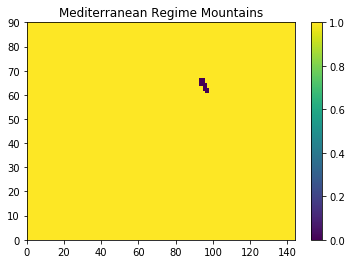

-----------------------------------------------------
western_US
mask requested western_US
unique values of mask [False  True]
shape of mask [False  True]


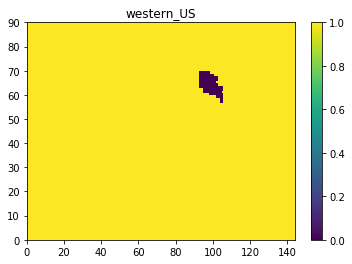

Loading CMIP5 data required for var_out_CMIP5 45 dictionary
-----------------------------------------------------
Marine Regime Mountains
mask requested Marine Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


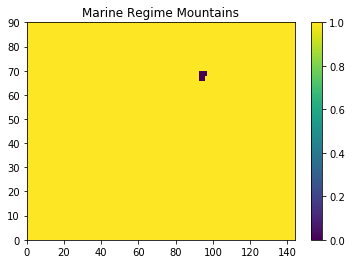

-----------------------------------------------------
Temperate Steppe Regime Mountains
mask requested Temperate Steppe Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


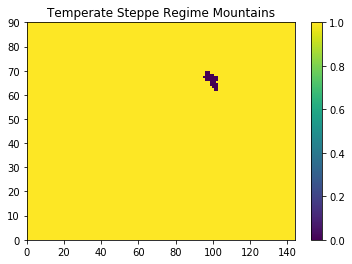

-----------------------------------------------------
Mediterranean Regime Mountains
mask requested Mediterranean Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


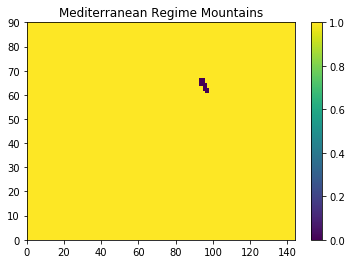

-----------------------------------------------------
western_US
mask requested western_US
unique values of mask [False  True]
shape of mask [False  True]


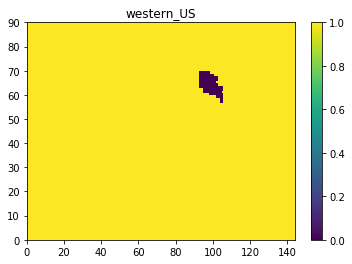

In [114]:
# Load the nessisary CMIP5 model data for the var left out models
# We cooked it up such that we required all variables be available 
# but this is not as rescritive as in original analysis since we 
# are making regression models with many fewer predictors. 
lasso_var_out_cmip5_85_dict = load_regression_cmip5_data(df_dummy, "var_out_CMIP5", "85", force_load=False)
lasso_var_out_cmip5_45_dict = load_regression_cmip5_data(df_dummy, "var_out_CMIP5", "45", force_load=False)

### Load the original packets to keep the code working 

### Use functions to load the CMIP5 data as time series

Loading CMIP5 data required for lasso_all 85 dictionary
-----------------------------------------------------
Marine Regime Mountains
mask requested Marine Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


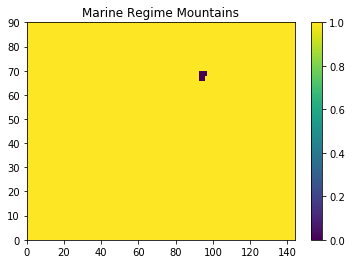

-----------------------------------------------------
Temperate Steppe Regime Mountains
mask requested Temperate Steppe Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


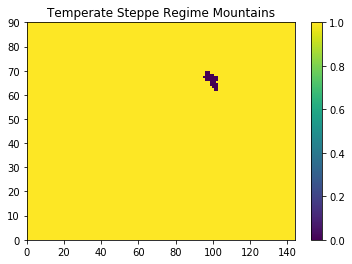

-----------------------------------------------------
Mediterranean Regime Mountains
mask requested Mediterranean Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


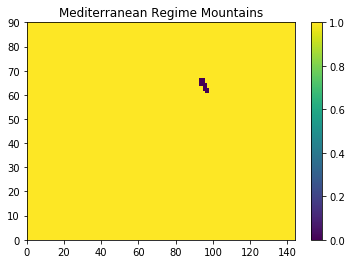

-----------------------------------------------------
western_US
mask requested western_US
unique values of mask [False  True]
shape of mask [False  True]


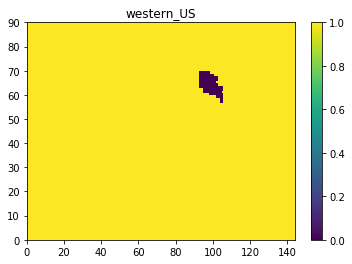

Loading CMIP5 data required for lasso_atmos 85 dictionary
-----------------------------------------------------
Marine Regime Mountains
mask requested Marine Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


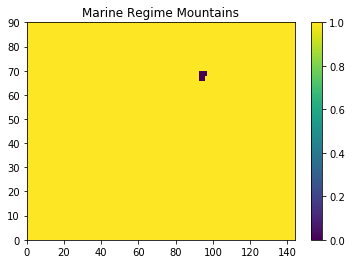

-----------------------------------------------------
Temperate Steppe Regime Mountains
mask requested Temperate Steppe Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


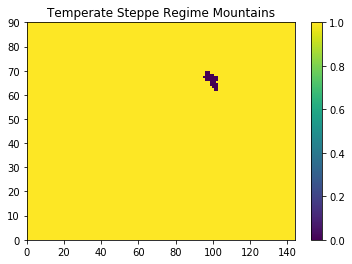

-----------------------------------------------------
Mediterranean Regime Mountains
mask requested Mediterranean Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


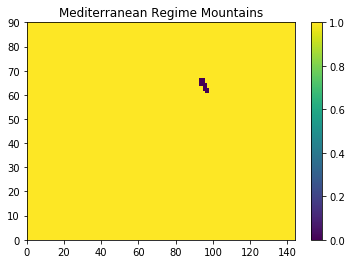

-----------------------------------------------------
western_US
mask requested western_US
unique values of mask [False  True]
shape of mask [False  True]


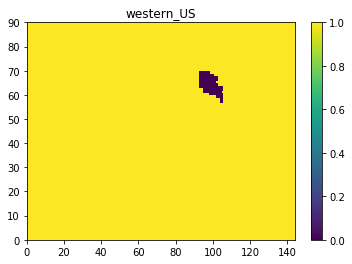

Loading CMIP5 data required for lasso_plant 85 dictionary
-----------------------------------------------------
Marine Regime Mountains
mask requested Marine Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


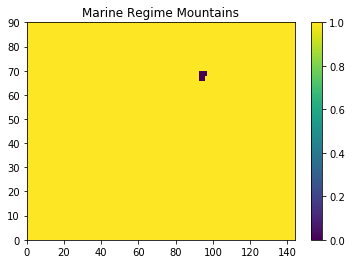

-----------------------------------------------------
Temperate Steppe Regime Mountains
mask requested Temperate Steppe Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


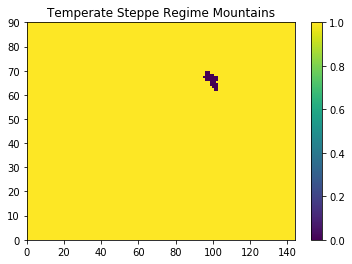

-----------------------------------------------------
Mediterranean Regime Mountains
mask requested Mediterranean Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


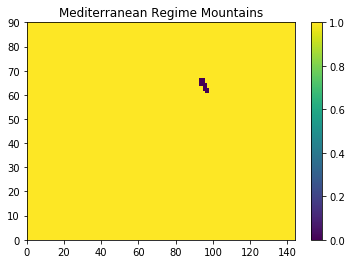

-----------------------------------------------------
western_US
mask requested western_US
unique values of mask [False  True]
shape of mask [False  True]


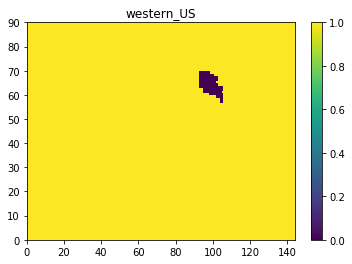

Loading CMIP5 data required for lasso_all 45 dictionary
-----------------------------------------------------
Marine Regime Mountains
mask requested Marine Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


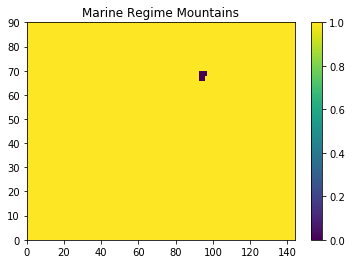

-----------------------------------------------------
Temperate Steppe Regime Mountains
mask requested Temperate Steppe Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


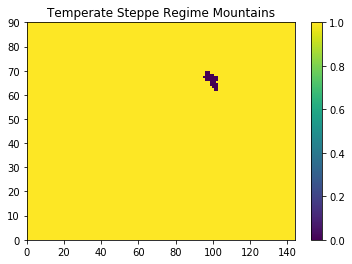

-----------------------------------------------------
Mediterranean Regime Mountains
mask requested Mediterranean Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


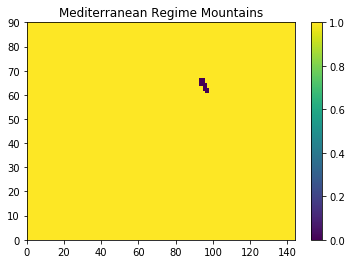

-----------------------------------------------------
western_US
mask requested western_US
unique values of mask [False  True]
shape of mask [False  True]


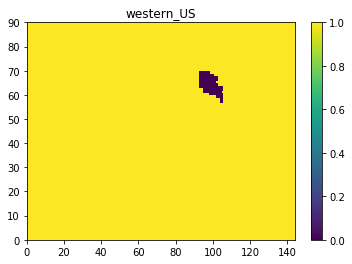

Loading CMIP5 data required for lasso_atmos 45 dictionary
-----------------------------------------------------
Marine Regime Mountains
mask requested Marine Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


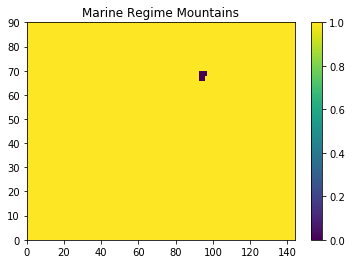

-----------------------------------------------------
Temperate Steppe Regime Mountains
mask requested Temperate Steppe Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


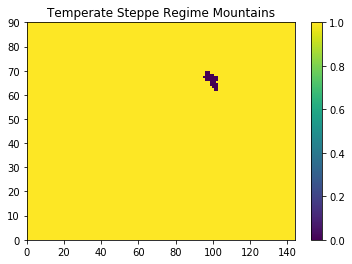

-----------------------------------------------------
Mediterranean Regime Mountains
mask requested Mediterranean Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


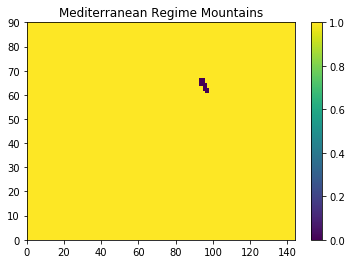

-----------------------------------------------------
western_US
mask requested western_US
unique values of mask [False  True]
shape of mask [False  True]


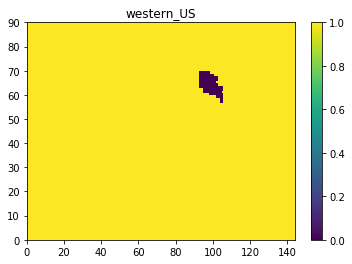

Loading CMIP5 data required for lasso_plant 45 dictionary
-----------------------------------------------------
Marine Regime Mountains
mask requested Marine Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


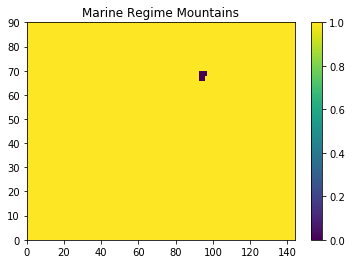

-----------------------------------------------------
Temperate Steppe Regime Mountains
mask requested Temperate Steppe Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


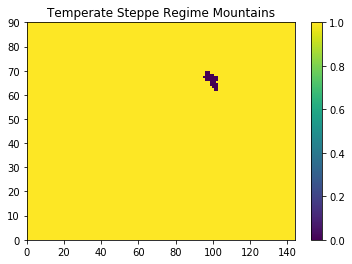

-----------------------------------------------------
Mediterranean Regime Mountains
mask requested Mediterranean Regime Mountains
unique values of mask [False  True]
shape of mask [False  True]


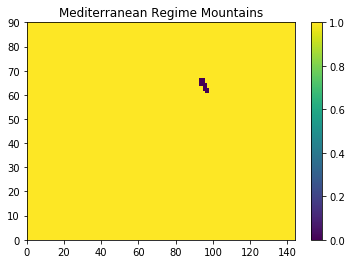

-----------------------------------------------------
western_US
mask requested western_US
unique values of mask [False  True]
shape of mask [False  True]


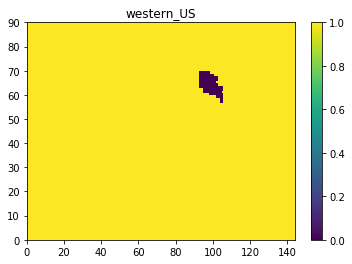

All requested CMIP5 data loaded/saved!


In [115]:
# Write the inception dictionary of division features
lasso_all_85_cmip5_dict = load_regression_cmip5_data(lasso_all_coefs, "lasso_all", "85", force_load)
lasso_atmos_85_cmip5_dict = load_regression_cmip5_data(lasso_atmos_coefs, "lasso_atmos", "85", force_load)
lasso_plant_85_cmip5_dict = load_regression_cmip5_data(lasso_plant_coefs, "lasso_plant", "85", force_load)

# Write the inception dictionary of division features
lasso_all_45_cmip5_dict = load_regression_cmip5_data(lasso_all_coefs, "lasso_all", "45", force_load)
lasso_atmos_45_cmip5_dict = load_regression_cmip5_data(lasso_atmos_coefs, "lasso_atmos", "45", force_load)
lasso_plant_45_cmip5_dict = load_regression_cmip5_data(lasso_plant_coefs, "lasso_plant", "45", force_load)

print("All requested CMIP5 data loaded/saved!")

### Unit sanity checks for variables where different units are stored for ERA-Interim and CMIP5. 
#### The following plots are PRE-bias correction
- This also serves as a sanity check on the unit conversion. 

In [116]:
def plot_unit_time_series(futures85, era_features, feature='pr_summer', units = "kg m$^{-2}$ s$^{-1}$") : 
    
    plt.figure(figsize=(10,6), dpi=150)

    ax=plt.subplot(111)

    for model in futures85.keys() :

        x = futures85[model].loc[:,feature].copy()
        if not np.isnan(x.iloc[0]) : 
            x.plot(label=model)
        del x
        
    era_features[feature].plot(label='ERA-Interim 1984-2016', linewidth=3, color="k")

    plt.ylabel(units)
    plt.title("Mean " + feature + " time series")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="RCP8.5 | 1984-2100")

    plt.show()

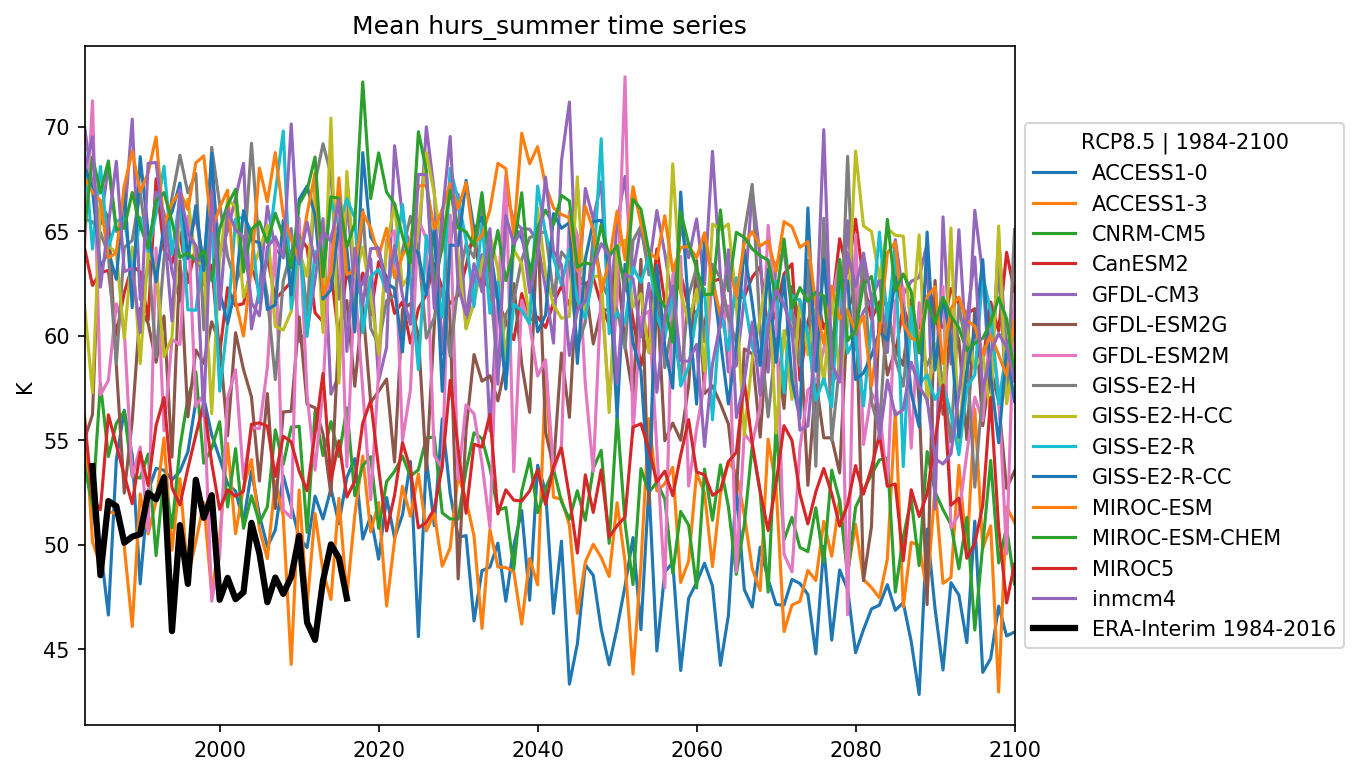

In [113]:
# perform check on a single division, lets say, 
futures85 = lasso_all_85_cmip5_dict["western_US"]
era_features = X_seasonal_dict["western_US"]
plot_unit_time_series(futures85, era_features, feature='hurs_summer', units = "K")

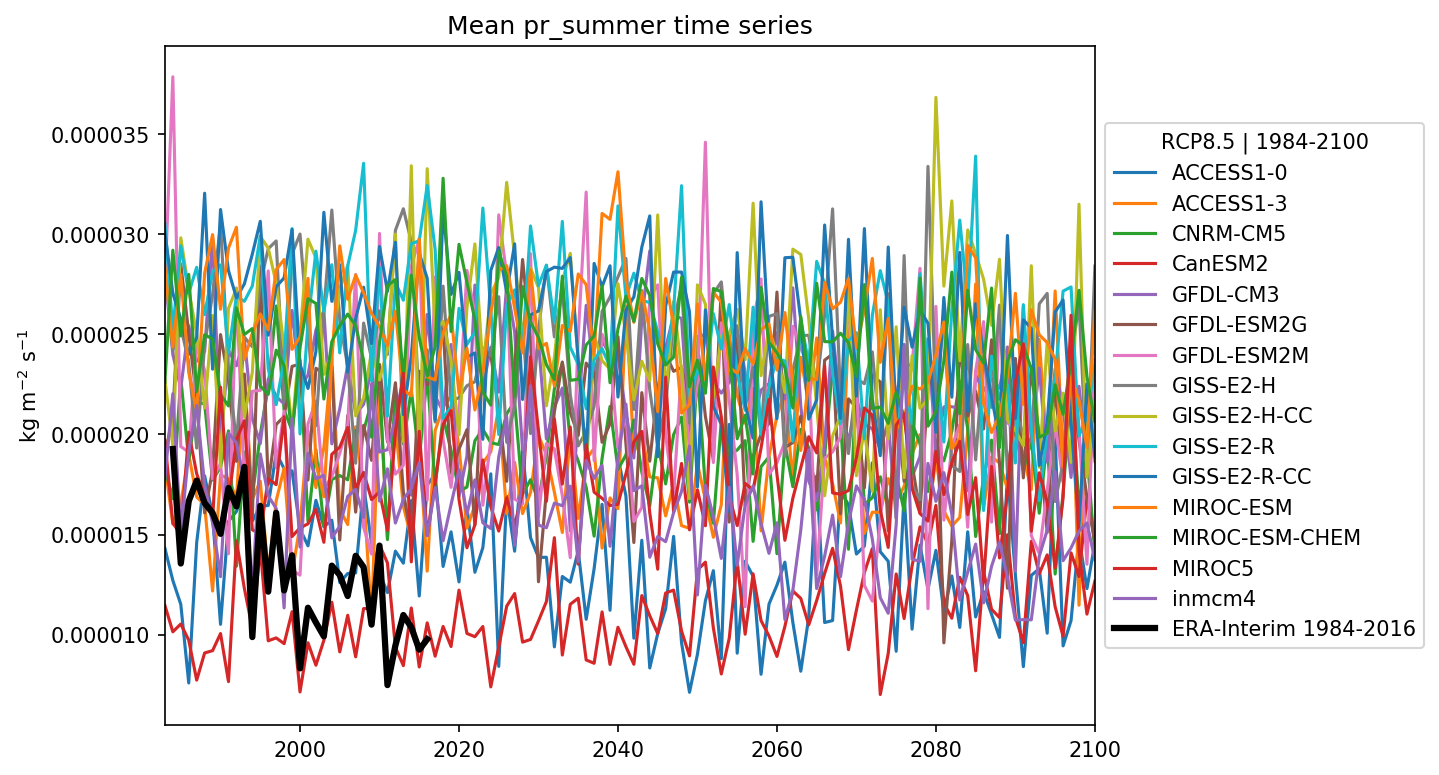

In [117]:
# perform check on a single division, lets say, 
futures85 = lasso_all_85_cmip5_dict["western_US"]
era_features = X_seasonal_dict["western_US"]
plot_unit_time_series(futures85, era_features, feature='pr_summer', units = "kg m$^{-2}$ s$^{-1}$")

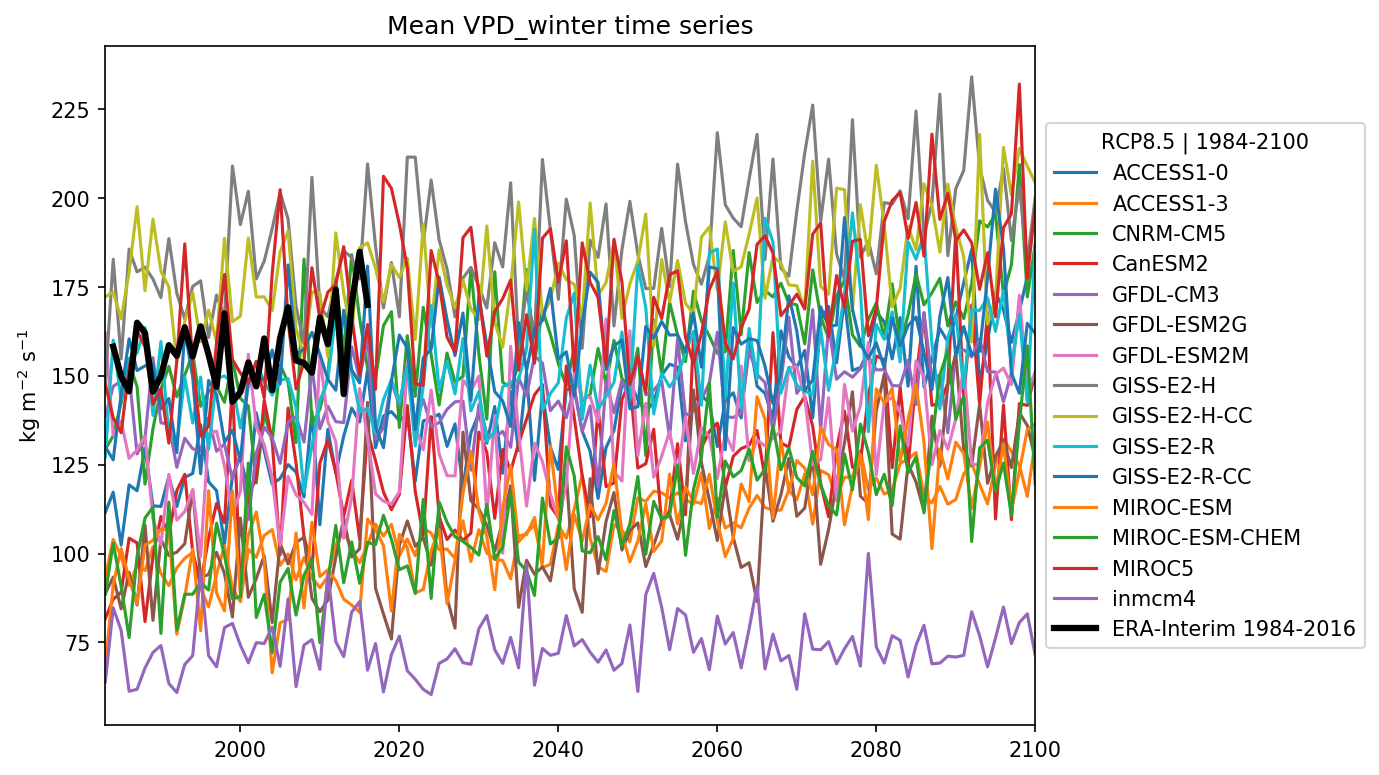

In [118]:
# perform check on a single division, lets say, 
futures85 = lasso_all_85_cmip5_dict['Marine Regime Mountains']
era_features = X_seasonal_dict['Marine Regime Mountains']
plot_unit_time_series(futures85, era_features, feature='VPD_winter', units = "kg m$^{-2}$ s$^{-1}$")

### Standardize CMIP5 output using ERA historical variance and mean. 
- This includes what most papers refer to as "bias correcting" CMIP5 data. 
- The purpose of this decision is to make is easy to compare data with different units. 
- To make it easy to understand how a variable changes from what has been observed to simulated by CMIP5 models. 

The historical period (1983-2016) CMIP5 data time series standard deviation is scaled to match the historical ERA-Interim standard deviation.  
This is done on the zero centered (mean removed) flattened (linear trend removed) time series for both. For variabes with trends, much of the standard deviation in the historical period is from the trend. We are forecasting year-to-year variability, so this trend must be removed for proper scaling. 

- The bias, offset, and standard deviation of each CMIP5 model is calibrated witht the following procedure:
    - Shown in bias_correct_cmip()

### Standardize the CMIP5 output and handle bias for all divisions. 
- Save as new dictionary
- TODO: handle trends within the overlap period. This could be important if sigma is driven by a trend rather than year to year variability.

In [119]:
def bias_correct_cmip(feature, div, model_name, X, y1=1984, y2=2016, inspect=False) : 
    """
    Scales the sigma of a CMIP5 model simulated feature to match
    the sigma observed by ERA-Iterim. The sigma is scaled using
    the overlapping years 1984-2016, all relevant sigmas are from 
    detrended series. 

    # TODO: Regression TYPE NEEDED IN SAVE INFORMATION. 

    Parameters
    ----------
        feature: str, the name of the feature being scaled. 
        div : the division data being scaled. used for getting correct detrended sigma. 
        X : pd.DataFrame, the CMIP5 dataframe with the feature to be scaled. Index of X
            used in regression within method. 

    Return
    ------
        x_fully_calibrated : np.array, where the detrended sigma (interannual) variance was scaled
                             so that np.std(x[y1:y2]) == era_ref_std and such that the historical
                             mean for y1-y2 matches era. Fully bias corrected. 
        sigma_ratio : ratio of y1:y2 detrended sigmas (era_ref_std / cmip_x_sub_flat_sigma).
                      good reference for figuring out how bad cmip simulates a given features. 
    """

    # tolerance for difference in historical overlap period 
    # sigma between model and observations. Ideally zero. There
    # are limitations. 
    tol = 1e-13

    # Get the mean and std values of the era_df_features to use to standardize 
    # the cmip model output by
    # TODO: Replace with reading the saved values! 
    era_ref_mean = pd.read_csv(os.path.join(save_dir_base, 'feature_means.csv'), index_col=0).loc[div, feature]
    era_ref_std  = pd.read_csv(os.path.join(save_dir_base, 'feature_std.csv'), index_col=0).loc[div, feature]
    
    if inspect :
        print("reference mean and std are : " + str(era_ref_mean) + " +- " + str(era_ref_std))

    # Get mask of overlapping years for scaling
    overlap_mask = ( X.index.values >= y1 ) & ( X.index.values <= y2 )

    years = X.index.values.copy()

    # Get the series to be scaled as numpy.array
    x = X.loc[:, feature].values.copy()
    #print(x)
    x_lm = stats.linregress(years, x)
    x_linear_fit = years*x_lm.slope + x_lm.intercept
    x_flat = signal.detrend(x)

    # Get the historical overlap years data with slope and offset 
    # NOTE: In false statement, this is how I first did this, 
    # NOTE: flattening the whole series then subsetting, but
    # NOTE: it makes more sense to detrend using local slope, 
    # NOTE: not 1984-2100 slope. 
    #x_sub_flat = x_flat[overlap_mask].copy()
    x_sub = x[overlap_mask].copy()
    x_sub_flat = signal.detrend(x_sub)

    x_sub_flat_sigma = np.std(x_sub_flat)
        
    # Ratio to scale the time series by. 
    sigma_ratio = era_ref_std / x_sub_flat_sigma

    # Make sure scaling makes ref period sigma match
    d = np.abs(era_ref_std - np.std(x_sub_flat * sigma_ratio))
    if d > tol :
        print("------> Comparisom of sigma error")
        print("Tolerance for difference is: " + str(tol))
        print("The observed diffefence is: " + str(d))
        raise ValueError("The scaling did not make sigmas match in reference period within tolerance. ")

    # use the ratio from the overlap period to scale the 
    # flattened longer time period 
    x_flat_scaled = x_flat * sigma_ratio
    
    # Add the slope and offset back into the time series 
    x_calibrated = x_flat_scaled + x_linear_fit

    # Now, replace the offset of x_calibrated with the historical mean
    # value for the overlap period
    x_calibrated_sub_mean = np.mean(x_calibrated[overlap_mask])

    # Seasonal sigma and overlap period offset both bias corrected 
    # i.e. replace cmip y1:y2 mean with era y1:y2 mean. 
    x_fully_calibrated = (x_calibrated - x_calibrated_sub_mean) + era_ref_mean
    
    if inspect : 

        fig_save_dir = os.path.join(save_dir_base, "bias_correction_curves")
        if not os.path.isdir(fig_save_dir) :
            os.mkdir(fig_save_dir)
            
        save_name = os.path.join(fig_save_dir, div.replace("/"," ")+"_"+feature+"_"+model_name+".png")
        
        plt.figure(dpi=150)
        plt.plot(years, x, label="x original")
        plt.plot(years, x_linear_fit, label = "x-linear fit")
        plt.plot(years, x_calibrated, "--", label="x variance calibrated")
        plt.axhline(y=era_ref_mean, linestyle="--", color="k", label="era reference mean")
        plt.plot(years, x_fully_calibrated, label="fully calibrated")
        plt.legend()
        plt.title(feature +" "+model_name +" scaled by %f factor" % sigma_ratio)
        plt.savefig(save_name)
        plt.close()

    return x_fully_calibrated, sigma_ratio

In [120]:
def standardize_cmip(div, cmip_dict, era_df_features, inspect=False) : 
    """
    Standardizes historical output using era reanlysis data fields. The 
    cmip5 model output bias is first corrected using bias_correct_cmip()
    then then standardized using historical (1984-2016) variance and width. 
    
    Parameters
    ----------
        cmip5_dict : A dictionary of CMIP5 output in pd.DataFrames. This 
                     function will loop over these models creating Z. 
        era_df_features : a pd.Dataframe of era features. Must exactly match
                          the features (columnames) in cmip5_dict dataframes. 
                          ERA feature means and standard deviations are 
                          calculated using this dataframe. 
                          
        Return
        ------
            A dictionary of pd.Dataframe where the keys are cmip5 model names
            and the values are the features standarized using historical (era)
            mean and variance. 
    """
    
    # Don't want any changes to be made outside of function 
    era_df_features = era_df_features.copy()
    
    # Read the mean and std values of the era_df_features to use to standardize 
    # the cmip model output by
    era_ref_mean = pd.read_csv(os.path.join(save_dir_base, 'feature_means.csv'), index_col=0).loc[div, :]
    era_ref_std  = pd.read_csv(os.path.join(save_dir_base, 'feature_std.csv'), index_col=0).loc[div, :]
        
    # A dictionary to store the standardized output 
    Z_futures_dict = {}
        
    # Get model names to loop over 
    model_names = cmip_dict.keys()
    n_models    = len(model_names) 
    
    # A DataFrame to record how much cmip model sigma are scaled 
    sigma_scale_df = pd.DataFrame(np.nan, columns=era_ref_mean.index.values, index=model_names)
    
    for model_name in model_names : 

        if inspect :
            print("------------------------------------------")
            print("Standardizing %s model output" % model_name)
            print("------------------------------------------")

        # Get the CMIP5 features dataframe from the futures dict
        cmip_df_features = cmip_dict[model_name].copy()
        cmip_years = np.array(cmip_df_features.index.values.copy())
        features = cmip_df_features.columns.values
        
        if inspect :
            print("The names of the cmip_df_features:")
            print(features)
            print("The names of the era_df_features:")
            print(era_df_features.columns.values)
            print(cmip_df_features.iloc[:2,:])

        # Use pd.DataFrame for nice storage. 
        Z_future_df = pd.DataFrame(0, columns=features, index=cmip_years)
        
        # Standardize (using historical mean and variance) 
        # the columns of these CMIP5 output 
        for feature in features : 
            
            if inspect :
                print("standardizing feature %s" % feature)
                print("%s first value: " %feature)
                print(cmip_df_features.loc[1984, feature])
            
            # If statement will figure out if the feature even exists
            # only features with non-zero coefs are loaded and need calibrating.
            # looking at the first value is enough, as all column values are np.nan
            # where there is no data. 
            if np.isnan(cmip_df_features.loc[1984, feature]) : 
                # If these data do not exist replace 0 with nan
                # so it is clear the data were traverserd
                Z_future_df.loc[:, feature] = np.nan
                if inspect : 
                    print("---------> No calibration for %s" %feature )
            else :
                # There are data!
                x_calibrated, sigma_ratio = bias_correct_cmip(feature, div, model_name, cmip_df_features, inspect=inspect)
                sigma_scale_df.loc[model_name, feature] = sigma_ratio
                #print(model_name + " sigma ratio: %f" % sigma_ratio)

                # Convert to z using historical values 
                xbar = era_ref_mean.loc[feature]
                xstd = era_ref_std.loc[feature]
                z = ( x_calibrated -  xbar) / xstd

                # Store the value
                Z_future_df.loc[:, feature] = z.copy()
                
        # Store in the dictionary
        Z_futures_dict[model_name] = Z_future_df   
            
    return Z_futures_dict, sigma_scale_df

In [121]:
def make_cmip5_Z_dict(regression_name, rcp, cmip_dict, X_seasonal_dict, inspect=False) :
    """
    
    Parameters
    ----------
        regression_name : str, The name of the regression 
        rcp : str, the desired RCP associated with the regression_name
        cmip_dict : A cmip5 dictionary created by get_CMIP5_features(), 
                    containing cmip5 data for non-zero coefs of associated
                    regression, for each ecoregion
        X_seasonal_dict : dictionary of pd.DataFrame, containing divisions
                          (index) by features (rows) of era-iterim data
                          used to train regressions and make ceofs.
                          
    return
    ------
        Z_cmip_dict : A dictionary where cmip5 data have been expressed in terms
                      of historical variance after being bias corrected. 
    """
    
    # Create descriptive file save name
    f1 = regression_name + "_" + "Z_cmip_" + rcp + "_dict.obj"
    print("Creating: " + os.path.join(save_dir_base, f1) ) 
    
    # Create an empty diction to store division Z dictionaries
    Z_cmip_dict = {}
    Z_sigma_scale_dict = {}
    
    for div in cmip_dict.keys() : 
        Z_cmip_dict[div], Z_sigma_scale_dict[div] = standardize_cmip(div, cmip_dict[div], X_seasonal_dict[div], inspect)

    # And save them for analysis
    with open(os.path.join(save_dir_base, f1), 'wb') as fp:
        pickle.dump(Z_cmip_dict, fp)
        
    # And save them for analysis
    f2 = regression_name + "_sigma_scale_cmip_" + rcp + "_dict.obj"
    with open(os.path.join(save_dir_base, f2), 'wb') as fp:
        pickle.dump(Z_sigma_scale_dict, fp)   
        
    return Z_cmip_dict, Z_sigma_scale_dict

#### Standardize the features for each division for :
- **Each regression type**
    - **RCP** 

#### Here is the absurd nesting of the functions that standardize CMIP5 output
- make_cmip5_Z_dict(regression_name, rcp, cmip_dict, X_seasonal_dict)
    - standardize_cmip(div, cmip5_dict[div], X_seasonal_dict[div])
        - bias_correct_cmip(cmip5_dict[div], X_seasonal_dict[div], feature)

In [122]:
Z_lasso_all_cmip_85_dict, _   = make_cmip5_Z_dict("lasso_all", "85", lasso_all_85_cmip5_dict, X_seasonal_dict)
Z_lasso_plant_cmip_85_dict, _ = make_cmip5_Z_dict("lasso_plant", "85", lasso_plant_85_cmip5_dict, X_seasonal_dict)
Z_lasso_atmos_cmip_85_dict, _ = make_cmip5_Z_dict("lasso_atmos", "85", lasso_atmos_85_cmip5_dict, X_seasonal_dict)

Z_lasso_all_cmip_45_dict, _   = make_cmip5_Z_dict("lasso_all", "45", lasso_all_45_cmip5_dict, X_seasonal_dict)
Z_lasso_plant_cmip_45_dict, _ = make_cmip5_Z_dict("lasso_plant", "45", lasso_plant_45_cmip5_dict, X_seasonal_dict)
Z_lasso_atmos_cmip_45_dict, _ = make_cmip5_Z_dict("lasso_atmos", "45", lasso_atmos_45_cmip5_dict, X_seasonal_dict)

Creating: ../Data/Fire_Analysis/one_last_ride_0_transofromation_log10/lasso_all_Z_cmip_85_dict.obj
Creating: ../Data/Fire_Analysis/one_last_ride_0_transofromation_log10/lasso_plant_Z_cmip_85_dict.obj
Creating: ../Data/Fire_Analysis/one_last_ride_0_transofromation_log10/lasso_atmos_Z_cmip_85_dict.obj
Creating: ../Data/Fire_Analysis/one_last_ride_0_transofromation_log10/lasso_all_Z_cmip_45_dict.obj
Creating: ../Data/Fire_Analysis/one_last_ride_0_transofromation_log10/lasso_plant_Z_cmip_45_dict.obj
Creating: ../Data/Fire_Analysis/one_last_ride_0_transofromation_log10/lasso_atmos_Z_cmip_45_dict.obj


### New
### Standardizing the var_left_out models
- 'X_seasonal_dict' is the seasonal ERA features 

In [123]:
Z_lasso_var_out_cmip5_85_dict, _   = make_cmip5_Z_dict("var_out_85", "85", lasso_var_out_cmip5_85_dict, X_seasonal_dict)
Z_lasso_var_out_cmip5_45_dict, _   = make_cmip5_Z_dict("var_out_45", "45", lasso_var_out_cmip5_45_dict, X_seasonal_dict)

Creating: ../Data/Fire_Analysis/one_last_ride_0_transofromation_log10/var_out_85_Z_cmip_85_dict.obj
Creating: ../Data/Fire_Analysis/one_last_ride_0_transofromation_log10/var_out_45_Z_cmip_45_dict.obj


Make z a pd.DataFrame Z, easier to plotting and handling

### Plot original data and Z time series 
- to make sure standardization and bias correction worked as planned 
- the units make sense
- the variance is an acceptable unit
- a way to be able to go back and look at the raw data for a variable and region and rcp of interest without having to run any more code

In [124]:
# Create a directory for time series figures, if it does not exist already
time_series_dir = os.path.join(save_dir_base, "time_series_figures")
if not os.path.isdir(time_series_dir) : 
    print("Creating a time series dir", time_series_dir)
    os.mkdir(time_series_dir)
else : 
    print("Using an existing time series dir", time_series_dir)

Creating a time series dir ../Data/Fire_Analysis/one_last_ride_0_transofromation_log10/time_series_figures


In [125]:
era_ref_means = pd.read_csv(os.path.join(save_dir_base, 'feature_means.csv'), index_col=0)
era_ref_stds  = pd.read_csv(os.path.join(save_dir_base, 'feature_std.csv'), index_col=0)

In [126]:
# Get single division plotting data
def plot_all_time_series(Z_lasso_85_dict, Z_lasso_45_dict, lasso_85_dict, lasso_45_dict, reggression_name) : 
    """
    Plot all raw data and Z time series as a sanity check. For a specific set of dictionaries
    related to a given lasso type. 
    
    """
    for div in divisions : 
        #div = 'Temperate Steppe Regime Mountains'
        print("working on:", div)

        div_Z_85 = Z_lasso_85_dict[div]
        div_Z_45 = Z_lasso_45_dict[div]
        div_85 = lasso_85_dict[div]
        div_45 = lasso_45_dict[div]

        # Observations from ERA-Interim
        div_ERA = X_seasonal_dict[div]
        div_Z_ERA = Z_dict[div]

        # Plot each variable in division
        for variable in lasso_all_coefs.columns.values : 
            #variable = "tas_summer"

            fig = plt.figure(figsize=(10,10), dpi=300)

            # original units, original data, rcp 45 --------------
            ax1 = plt.subplot(221)
            for model_name in div_45.keys() : 
                div_45[model_name].plot(y=variable, ax=ax1, linewidth=0.5)
            div_ERA.plot(y=variable, c="k", linewidth=2, ax=ax1)
            ax1.legend_.remove()
            plt.title("RCP 4.5 original data")
            plt.ylabel("Native units")

            mu = era_ref_means.loc[div, variable]
            std = era_ref_stds.loc[div, variable]
            plt.axhline(mu, c="k", linestyle="--")
            plt.axhline(mu + std, c="k", linestyle="--")
            plt.axhline(mu - std, c="k", linestyle="--")


            # Z units, original data, rcp 45 --------------
            ax2 = plt.subplot(222)
            for model_name in div_Z_45.keys() : 
                div_Z_45[model_name].plot(y=variable, ax=ax2, linewidth=0.5)
            div_Z_ERA.plot(y=variable, c="k", linewidth=2, ax=ax2)
            ax2.legend_.remove()
            plt.title("RCP 4.5 transformed data")
            plt.ylabel("detrended sigma units")

            plt.axhline(0, c="k", linestyle="--")
            plt.axhline(1, c="k", linestyle="--")
            plt.axhline(-1, c="k", linestyle="--")

            # original units, original data, rcp 85 --------------
            ax3 = plt.subplot(223, sharey=ax1)
            for model_name in div_85.keys() : 
                div_85[model_name].plot(y=variable, ax=ax3, linewidth=0.5)
            div_ERA.plot(y=variable, c="k", linewidth=2, ax=ax3)
            ax3.legend_.remove()
            plt.title("RCP 8.5 original data")
            plt.ylabel("Native units")

            plt.axhline(mu, c="k", linestyle="--")
            plt.axhline(mu + std, c="k", linestyle="--")
            plt.axhline(mu - std, c="k", linestyle="--")

            # Z units,  rcp 85 --------------
            ax4 = plt.subplot(224)
            for model_name in div_Z_85.keys() : 
                div_Z_85[model_name].plot(y=variable, ax=ax4, linewidth=0.5)
            div_Z_ERA.plot(y=variable, c="k", linewidth=2, ax=ax4)
            ax4.legend_.remove()
            plt.title("RCP 8.5 transformed data")
            plt.ylabel("detrended sigma units")

            plt.axhline(0, c="k", linestyle="--")
            plt.axhline(1, c="k", linestyle="--")
            plt.axhline(-1, c="k", linestyle="--")

            # Show lasso_all coef value 
            #coef = lasso_all_coefs.loc[div, variable]
            fig.suptitle(variable + " original and transformed", y=0.93)
            div_nice = div.replace("/","_")
            plt.savefig(os.path.join(time_series_dir, div_nice+"_"+variable+"_"+reggression_name+"_times_series.png"),  bbox_inches='tight')
            plt.close()

In [127]:
plot_all_time_series(Z_lasso_all_cmip_85_dict, Z_lasso_all_cmip_45_dict, lasso_all_85_cmip5_dict, lasso_all_45_cmip5_dict, "lasso_all")
plot_all_time_series(Z_lasso_plant_cmip_85_dict, Z_lasso_plant_cmip_45_dict, lasso_plant_85_cmip5_dict, lasso_plant_45_cmip5_dict, "lasso_plant")
plot_all_time_series(Z_lasso_atmos_cmip_85_dict, Z_lasso_atmos_cmip_45_dict, lasso_atmos_85_cmip5_dict, lasso_atmos_45_cmip5_dict, "lasso_atmos")

working on: Marine Regime Mountains
working on: Temperate Steppe Regime Mountains
working on: Mediterranean Regime Mountains
working on: western_US
working on: Marine Regime Mountains
working on: Temperate Steppe Regime Mountains
working on: Mediterranean Regime Mountains
working on: western_US
working on: Marine Regime Mountains
working on: Temperate Steppe Regime Mountains
working on: Mediterranean Regime Mountains
working on: western_US


### New time series 

In [126]:
plot_all_time_series(
    Z_lasso_var_out_cmip5_85_dict, 
    Z_lasso_var_out_cmip5_45_dict, 
    lasso_var_out_cmip5_85_dict, 
    lasso_var_out_cmip5_45_dict, 
    "var_out_time_series"
)

working on: Marine Regime Mountains
working on: Temperate Steppe Regime Mountains
working on: Mediterranean Regime Mountains
working on: western_US


### Our definition of standardization :
- requires that mean values for Z_cmip5 is 0 between 1984-2016
- with a standard deviation of 1. 

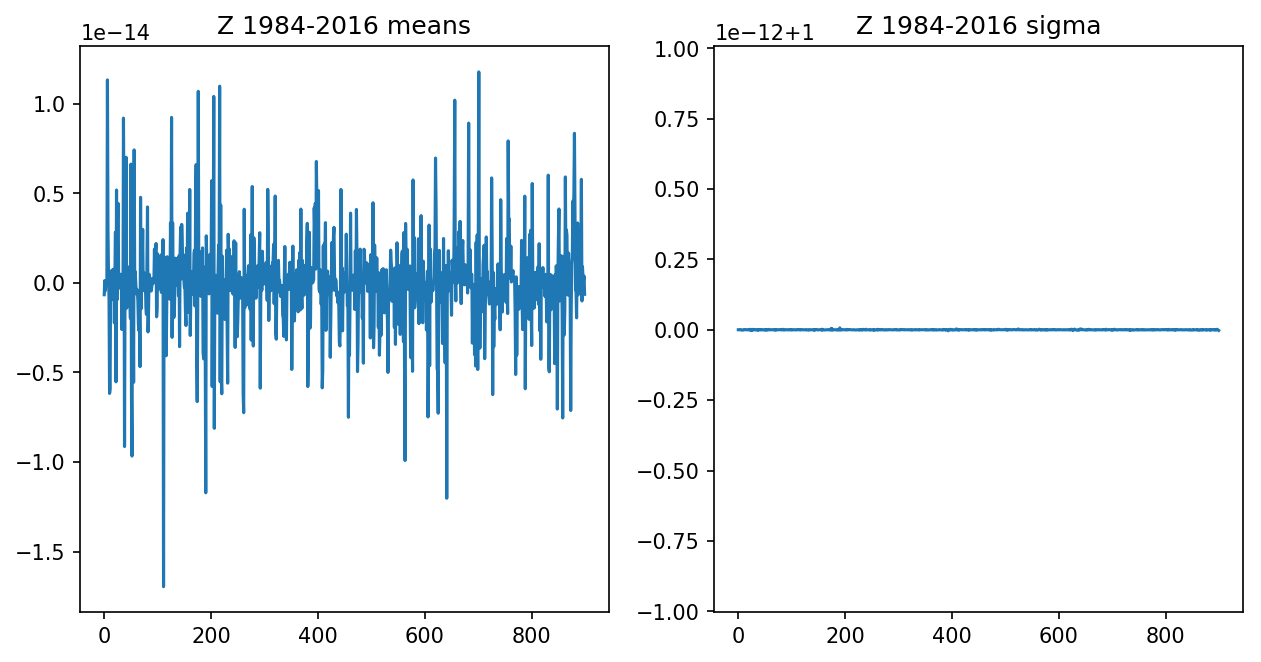

In [128]:
cmip_years = Z_lasso_var_out_cmip5_85_dict['Marine Regime Mountains']['ACCESS1-0'].index.values
mean_vals = []
std_vals = []
for div in Z_lasso_var_out_cmip5_85_dict.keys() :
    for m in Z_lasso_var_out_cmip5_85_dict[div].keys() : 
        
        # Reverse order of operations on sigma calculation 
        z = Z_lasso_var_out_cmip5_85_dict[div][m]
        for feature in z.columns.values : 
            z_eg =  z.loc[:,feature].values
            #print(z_eg)
            if not np.isnan(z_eg[0]) :
                ym = (cmip_years >= 1984) & (cmip_years <= 2016)
                if False : # old way 
                    z1 = signal.detrend(z_eg)
                    std_vals.append( np.std(z1[ym]) )
                else : 
                    z1 = z_eg[ym]
                    std_vals.append( np.std( signal.detrend(z1) ) )
                    
                mean_vals.append( np.mean(z_eg[ym]) )
    
plt.figure(dpi=150, figsize=(10,5))
plt.subplot(121)
plt.plot(mean_vals)
plt.title("Z 1984-2016 means")
plt.subplot(122)
plt.plot(std_vals)
plt.title("Z 1984-2016 sigma")
plt.show()

In [129]:
print('np.min(std_vals):',np.min(std_vals))
print('np.max(std_vals):', np.max(std_vals))
print('np.min(mean_vals):', np.min(mean_vals))
print('np.max(mean_vals):', np.max(mean_vals))

np.min(std_vals): 0.9999999999999966
np.max(std_vals): 1.0000000000000067
np.min(mean_vals): -1.6962862091394058e-14
np.max(mean_vals): 1.1779718614687599e-14


### Show how variables change from historical to fugure period

Set up consistent colors 

In [130]:
from matplotlib import cm
import matplotlib
from matplotlib.patches import Patch # For making custom legends 

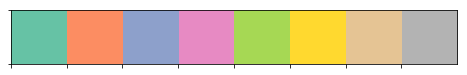

In [131]:
sns.palplot(sns.color_palette("Set2", n_colors=8))

In [132]:
div_color_dict = {
    'Temperate Steppe Regime Mountains' : sns.color_palette("Set2", n_colors=8)[7],
    'Marine Regime Mountains' : sns.color_palette("Set2", n_colors=8)[0],
    'Mediterranean Regime Mountains' : sns.color_palette("Set2", n_colors=8)[4]
}

In [133]:
div_color_dict

{'Temperate Steppe Regime Mountains': (0.7019607843137254,
  0.7019607843137254,
  0.7019607843137254),
 'Marine Regime Mountains': (0.4, 0.7607843137254902, 0.6470588235294118),
 'Mediterranean Regime Mountains': (0.6509803921568628,
  0.8470588235294118,
  0.32941176470588235)}

In [134]:
def get_CMIP5_model_delta(D, rcp, y1=2070, y2=2099) : 
    """
    Calculates how much a variable changes from the historical
    period to the future period. Requires standardized CMIP5 data. 
    """
    # Create the arrays to append to get all plotting attributes 
    var_name = np.array([])
    var_delta = np.array([])
    region_name = np.array([])
    model_name = np.array([])
    
    # Do not want western US
    region_loop = list(D.keys())[:-1]

    for region in region_loop :
        #print("")
        #print(region)
        #print("")
        for model in D[region].keys() : 
            #print(model)

            div_model_data = D[region][model]

            # Create the mean of the ending time period. Because of standardization
            # this by definittion is the change from the ERA-interim historical period
            div_model_data_end_mean = div_model_data.loc[y1:y2,:].mean(axis=0)

            # Get the required values and append to ongoing lists
            var_name = np.append(var_name , div_model_data_end_mean.index.values)
            var_delta = np.append(var_delta, div_model_data_end_mean.values)
            region_name = np.append(region_name, np.repeat(region, len(div_model_data_end_mean)))
            model_name = np.append(model_name, np.repeat(model, len(div_model_data_end_mean)))
            
    df = pd.DataFrame({"variable":var_name, "delta":var_delta, 
                       "region":region_name, "model":model_name,
                       "rcp":np.repeat(rcp, len(model_name))
                      })
    return df
    #return var_name, var_delta, region_name, model_name

In [135]:
df_85= get_CMIP5_model_delta(Z_lasso_var_out_cmip5_85_dict, rcp="RCP 8.5")
df_45 = get_CMIP5_model_delta(Z_lasso_var_out_cmip5_45_dict, rcp="RCP 4.5")

In [136]:
len(np.unique(df_45.model))

16

In [137]:
len(np.unique(df_85.model))

15

In [138]:
np.unique(df_85.model)

array(['ACCESS1-0', 'ACCESS1-3', 'CNRM-CM5', 'CanESM2', 'GFDL-CM3',
       'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC',
       'GISS-E2-R', 'GISS-E2-R-CC', 'MIROC-ESM', 'MIROC-ESM-CHEM',
       'MIROC5', 'inmcm4'], dtype=object)

In [139]:
df_85.head()

variable     delta                   region      model      rcp
0       pr_winter  0.497776  Marine Regime Mountains  ACCESS1-0  RCP 8.5
1       pr_spring -0.333358  Marine Regime Mountains  ACCESS1-0  RCP 8.5
2       pr_summer -0.944894  Marine Regime Mountains  ACCESS1-0  RCP 8.5
3  sfcWind_winter -0.643264  Marine Regime Mountains  ACCESS1-0  RCP 8.5
4  sfcWind_spring -0.222991  Marine Regime Mountains  ACCESS1-0  RCP 8.5

In [140]:
all_divs_ceofs.columns.values

array(['pr_winter', 'pr_spring', 'pr_summer', 'sfcWind_winter',
       'sfcWind_spring', 'sfcWind_summer', 'hurs_winter', 'hurs_spring',
       'hurs_summer', 'mrlsl.integrated_winter',
       'mrlsl.integrated_spring', 'mrlsl.integrated_summer', 'VPD_winter',
       'VPD_spring', 'VPD_summer'], dtype=object)

In [141]:
# Set the order of the features for the plot 
features_names = all_divs_ceofs.columns.values

yticklabels = all_divs_ceofs.columns.str.replace("_", " ").str.replace("winter", "(NDJF)").str.replace("summer", "(JJA)")\
.str.replace("hurs", "RH%").str.replace("spring", "(MAM)").str.replace('mrlsl.integrated', "soil moisture")\
.str.replace("sfcWind", "wind speed").str.replace("pr", "precip")

<>:18: DeprecationWarning: invalid escape sequence \D
<>:39: DeprecationWarning: invalid escape sequence \D
<>:67: DeprecationWarning: invalid escape sequence \o
<>:18: DeprecationWarning: invalid escape sequence \D
<>:39: DeprecationWarning: invalid escape sequence \D
<>:67: DeprecationWarning: invalid escape sequence \o
<>:18: DeprecationWarning: invalid escape sequence \D
<>:39: DeprecationWarning: invalid escape sequence \D
<>:67: DeprecationWarning: invalid escape sequence \o
<ipython-input-142-7c5daeb91fbc>:18: DeprecationWarning: invalid escape sequence \D
  ax1.set_xlabel('RCP 4.5 $\Delta$ [$\sigma_{ERA-Interim_{1984-2016}}$]',
<ipython-input-142-7c5daeb91fbc>:39: DeprecationWarning: invalid escape sequence \D
  ax2.set_xlabel('RCP 8.5 $\Delta$ [$\sigma_{ERA-Interim_{1984-2016}}$]', fontsize=12, weight = 'bold')
<ipython-input-142-7c5daeb91fbc>:67: DeprecationWarning: invalid escape sequence \o
  fig.suptitle("$\overline{CMIP5_{2070-2099}}$ - $\overline{ERA-Interim_{1984-2016}}

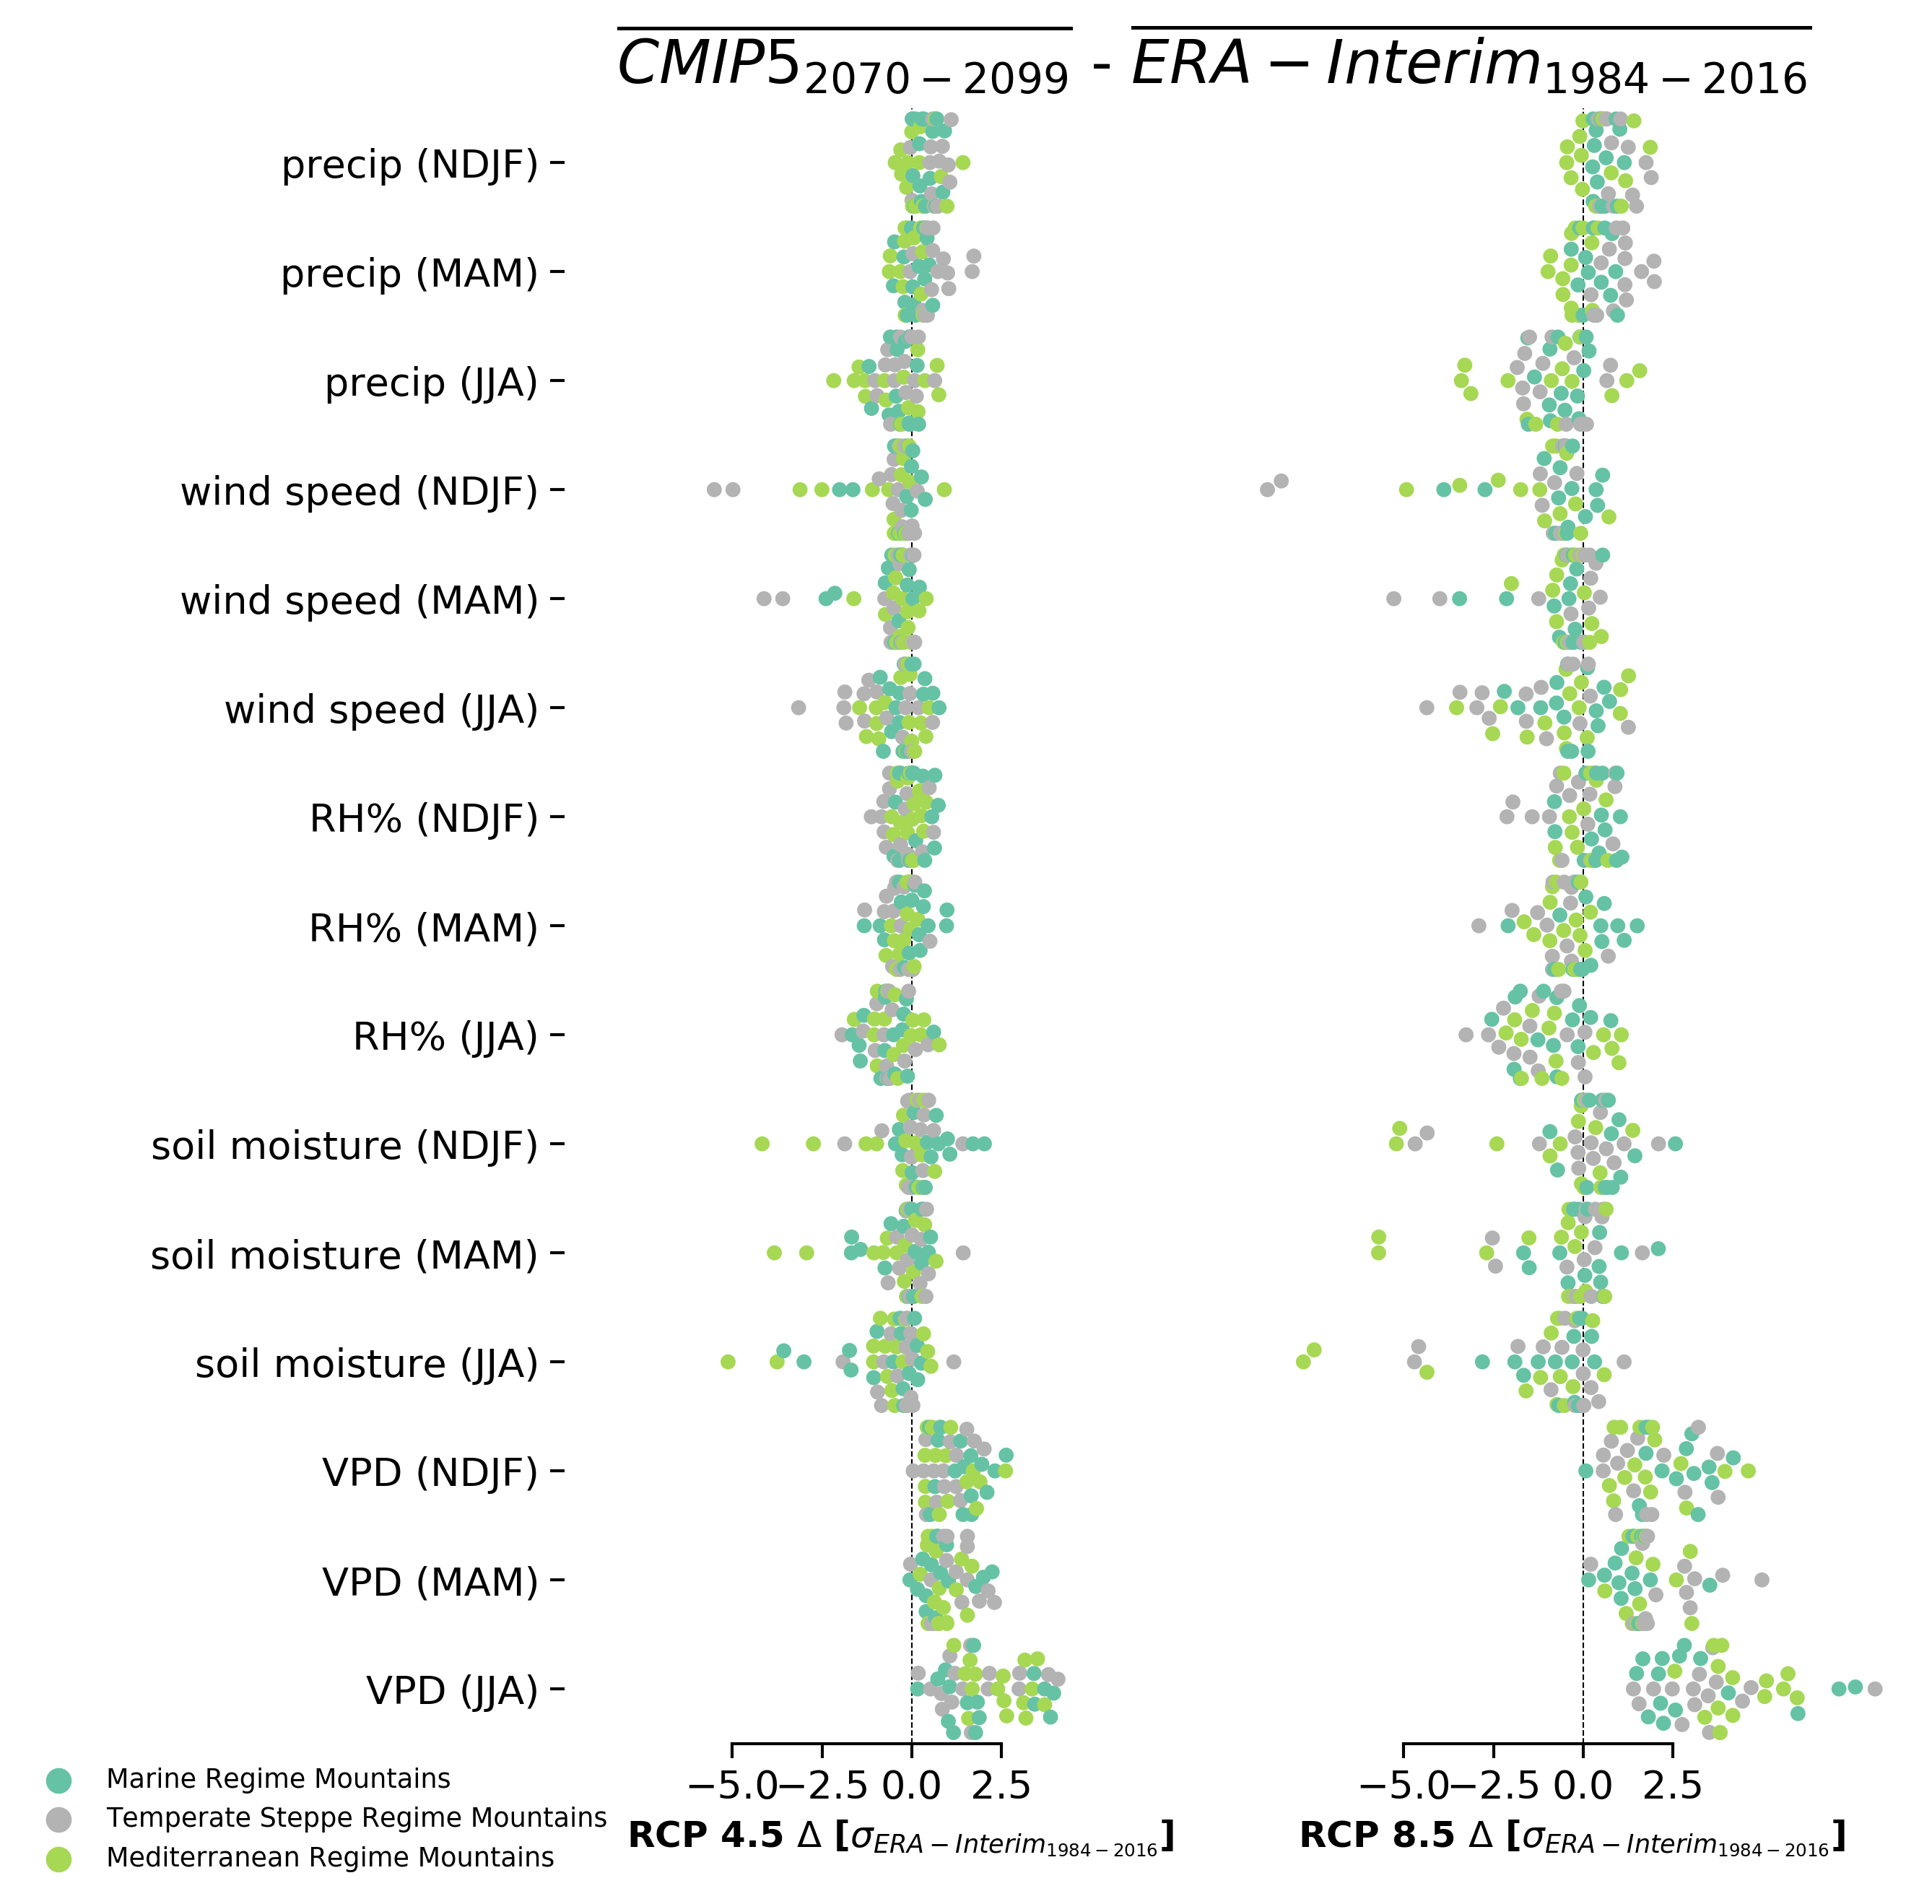

In [142]:
with sns.plotting_context("paper") :

    figure_name = "var_out_delta_means_swamplot.png"
    

    
    fig = plt.figure(dpi=300, figsize=(8,10))
    
    plt.subplot(1, 2, 1)
    
    ax1 = sns.swarmplot(y="variable", x="delta", 
                        hue="region", order=features_names,
                        data=df_45,
                        palette=div_color_dict)
                       
                        
    ax1.tick_params(labelsize=13)
    ax1.set_xlabel('RCP 4.5 $\Delta$ [$\sigma_{ERA-Interim_{1984-2016}}$]', 
                   fontsize=12, weight = 'bold')
    ax1.set(ylabel="")
    sns.despine(trim=True, left=True)
    plt.axvline(x=0, linestyle="--", color="k", linewidth=0.5)

    # Handle the legend
    leg = ax1.get_legend()
    
    # Second panel 
    plt.subplot(122, sharex=ax1, sharey=ax1)
    ax2 = sns.swarmplot(y="variable", x="delta", 
                        hue="region", 
                        order=features_names,
                        data=df_85,
                        palette=div_color_dict
                       )
                        
    sns.despine(trim=True, left=True)
    ax2.tick_params(labelsize=13)
    plt.axvline(x=0, linestyle="--", color="k", linewidth=0.5)
    ax2.set_xlabel('RCP 8.5 $\Delta$ [$\sigma_{ERA-Interim_{1984-2016}}$]', fontsize=12, weight = 'bold')
    ax2.set(ylabel="")
    ax2.yaxis.set_visible(False)
    ax2.legend_.remove()
    
    # Reduce the distance between the columns for subplots 
    plt.subplots_adjust(wspace=0.0)
    
    ax1.set_yticklabels(yticklabels)   
    
    # Make labels bold 
    plt.rcParams['axes.labelweight'] = 'bold'
    leg = ax1.get_legend()
    # [left, bottom, width, height]
    leg.set_bbox_to_anchor((-0.2, 0.5, 0.3, -0.5))
    leg.set_label(div_color_dict.keys())
    leg.set_title("")
    leg.set_frame_on(False)
    
    custom_patch = [
        Patch(facecolor=sns.color_palette("Set2", n_colors=8)[7], edgecolor='k', label='Rocky Mts.'),
        Patch(facecolor=sns.color_palette("Set2", n_colors=8)[0], edgecolor='k', label='Pacific Northwest Mts.'),
        Patch(facecolor=sns.color_palette("Set2", n_colors=8)[4], edgecolor='k', label='California Mts.')
        
    ]
    
    #ax1.legend(custom_patch)
    
    fig.suptitle("$\overline{CMIP5_{2070-2099}}$ - $\overline{ERA-Interim_{1984-2016}}$",
                y=0.92, fontsize=20)
    
    plt.savefig(os.path.join(save_dir_base, figure_name),  bbox_inches='tight')
    
    plt.show()

In [143]:
div_color_dict = {
    'Temperate Steppe Regime Mountains' : sns.color_palette("Set2", n_colors=8)[7],
    'Marine Regime Mountains' : sns.color_palette("Set2", n_colors=8)[0],
    'Mediterranean Regime Mountains' : sns.color_palette("Set2", n_colors=8)[4]
}

Plot everything used in this analysis as a sanity check. Once checked, remove from workspace. 

# Use the standardized CMIP output to make predictions using the trained linear regressions
````Python 
div_lasso_list = {}    # A dictionary to store the trained regressions associated with divisions 
div_lasso_targets = {} # save what was fitted
div_relax_list = {}    # where the relaxo and lasso are saved. Gives critical information on coef kept, order, etc. 
div_ylog10 = {}        # Save the log10 values before detrending 
````

#### Here is a reminder of the operations done to the burn area target before fitting
This means for predictions to make sense, the mean seasonal burn area of the historical
data needs to be added to the predictions! 
````Python 
y_original = y_seanonal_df.loc[:, div].copy()

if transformation == "log10" :
    # We replace 0 values with 1 so that taking the base 10 logarithm is valid
    y_original.loc[y_original==0] = 1.
    y_log = np.log10(y_original.values)
    y_log_detrend = signal.detrend(y_log)
    y = y_log_detrend.copy()

    div_ylog10[div] = y_log

elif transformation == "none" : 
    # Do not alter the burn area, aside from taking the
    # autoregression (slope) away.
    y_detrend = signal.detrend(y_original)
    y = y_detrend.copy()

else :
    raise ValueError("tansformation not reconize. Choose valid transformation.")

````

Make sure that all of the needed variables were loaded from CMIP5. 

In [147]:
era_years = years

In [148]:
def make_BA_dictionary(regression_name, rcp, Z_dict, div_lasso_list, make_plots=False, lasso_type='relaxo') : 
    """
    Uses the fit regularized regressions to estimate burn area driven by bias corrected
    CMIP5 model space. 
    
    Parameters 
    ----------
        regression_name : str, 
            the name of the regression being used. lasso_all, 
            lasso_atmos, lasso_plant.  
        rcp : str 
            the RCP scenario, 45 or 85. 
        Z_dict : dict
            a dictionary with calibrated CMIP5 data, dataframes for 
            each division. 
        div_lasso_list : dict
            a dictionary of trained relaxo regressions. 
        make_plots : bool
            whether to plot the burn area for a given regression 
            cmip output combination. 
        lasso_type : str 
            The type of lasso model saved in div_lasso_list. Options are
            "lassoCV" (new work) or "relaxo" (o.g. work)
    return
    ------
        A dictionary of burn areas. This dictionary is also written to disk
        by default

    """
    print("working on burn area projections using %s" % regression_name)
    print("For rcp %s" % rcp)
    
    # Create a directory to save burn area predictions 
    if make_plots :
        BA_save_dir = os.path.join(save_dir_base, "BA_projections")
        if not os.path.isdir(BA_save_dir) : 
            os.mkdir(BA_save_dir)
            
    # A dictionary of dataframes where each dataframes columns are
    # burn area projections for a single CMIP5 model 
    BA_dict = {}        
            
    # Only loop through divs that have data
    divs_with_fits = []
    for div in Z_dict.keys() : 
        if len(Z_dict[div].keys()) > 0 :
            divs_with_fits.append(div)
    #print(divs_with_fits)
        
    # Work on one division at a time
    for div in divs_with_fits : 
        
        #print("--------------------------------------------")
        #print(div)
        #print("--------------------------------------------")
    
        # Get the lasso regression model associated with this regression
        # and this division 
        # e.g. div_relax_list['Marine Regime Mountains']['lasso_atmos']
        # formorly # lasso_lm = div_lasso_list[div][regression_name]
        if lasso_type == "relaxo" : 
            div_relaxo = div_lasso_list[div][regression_name]
            lasso_lm = div_relaxo.lasso_model
        elif lasso_type == "lassoCV" : 
            div_relaxo = div_lasso_list[div][regression_name]
        else :
            raise NotImplementedError("{} not accepted lasso_type.".format(lasso_type))
        
        
        # Get the dimensions of the burn area data to save 
        models_for_div = list(Z_dict[div].keys())
        z_years = Z_dict[div][models_for_div[0]].index.values.copy()
        
        # Create dataframe to store predictions [year X model]
        BA_df = pd.DataFrame(np.nan, columns=models_for_div, index = z_years)

        for model_name in models_for_div : 
            
            # Get the features for a given division & model 
            z_pred = Z_dict[div][model_name].copy()
                        
            # Get the names of the features fed to the second lasso 
            #(after variable selection step). 
            second_lasso_features = div_relaxo.X_second_lasso.columns.values
            #print("second_lasso_features:")
            #print(second_lasso_features)
            z_pred_subset = z_pred.loc[:, second_lasso_features].copy()
            
            # Make sure there are NO np.nan values in any of these columns. 
            # It could be a sign that there is a mismatch. Checking the 
            # first row of all columns of z_pred_subset should be enough. 
            if np.sum( np.isnan(z_pred_subset.values[0,:]) ) > 0 :
                
                # There should be no features with non-zero ceofs that
                # have nan values. Make that check too. 
                needed_features = lasso_lm.coef_ != 0
                if np.sum(np.isnan(z_pred_subset.values[0, needed_features])) > 0 :
                    print(div)
                    print("Working on model %s" % model_name)       
                    print("second_lasso_features:")
                    print(second_lasso_features)
                    print("z_pred_subset.columns.values")
                    print(z_pred_subset.columns.values)
                    print(z_pred_subset.values[0:2, :])
                    print("lasso_lm.coef_")
                    print(lasso_lm.coef_)
                    print("-------> Issue with the features for " + div + " model: " + m)
                    raise ValueError("There are nan values in feature CMIP5 columns for model " + m)
                    
                else :
                    # So there are nans, but not for features with non-zero coeficients. Good! 
                    # scikit-learn LassoCV will not allow nans in the dataframe, even for 
                    # columns that are meaningless, so turn those to zeros now. 0 * 0 is 
                    # no harm no foul
                    z_predictors = z_pred_subset.fillna(value=0)
            else :
                # There were no nans in the predictors dataframe once subset 
                # for features needed based on second lasso. 
                z_predictors = z_pred_subset.copy()
                
            z_column_names = z_predictors.columns.values.copy()
        
            # Get the mean value of the non-transformed target
            # because the mean was taken away for fitting. This will be added
            # to projected burn areas that are centered around zero by design. 
            if transformation == 'log10' : 
                y_bar = np.mean(div_ylog10[div])
            elif transformation == 'none' :
                y_bar = np.mean(div_BA_original[div])
            else :
                raise NotImplementedError("Unrecognized data transformation " + transformation)

            # Lasso target, the y actually used for regression fitting. 
            # universal variable, defined waaaay above in script . 
            lasso_target = div_lasso_targets[div]+y_bar

            # make projection and get linear fit on that projection 
            # in case we want to talk about slopes, trends, etc. 
            y_predicted = lasso_lm.predict(z_predictors.values) + y_bar
            lm = stats.linregress(z_years, y_predicted)
            predicted_fit = lm.slope*z_years + lm.intercept

            # Save the burn area predicted by regression type driven my CMIP5 output
            BA_df.loc[:, model_name] = y_predicted

            if make_plots : 

                file_name = div.replace("/", " ") + "_" + model_name + "_"+ regression_name + "_rcp"+ rcp + "_burn_area.png"
                f = os.path.join(BA_save_dir, file_name)

                plt.figure(dpi=200, figsize=(6,3))
                plt.plot(z_years, y_predicted, label="predicted")
                plt.plot(z_years, predicted_fit, label="predicted regression")
                plt.plot(era_years, lasso_target, label="original target")
                plt.axhline(y=y_bar, color="k", linestyle="--", label="target mean")

                plt.legend()
                plt.title(div + " BA using "+ m)
                plt.ylabel("log$_{10}$(burn area [acres])")
                plt.savefig(f)
                plt.close()
        
        # Once the dataframe of models with burn area forecasts are made for a 
        # dividion save that information before the next division. 
        BA_dict[div] = BA_df.copy()
        del BA_df
        #print(" ")
            
    # Save the dictionary to disk
    f_dict = regression_name + "_BA_rcp" + rcp + ".obj"
    with open(os.path.join(save_dir_base, f_dict), 'wb') as fp:
        pickle.dump(BA_dict, fp)
    
    return BA_dict   

### Make burn area predictions and write them to disk <a class="anchor" id="burn-area-projections"></a>

In [149]:
# This is now simply "temperature only"
BA_atmos_85 = make_BA_dictionary("lasso_atmos", "85", Z_lasso_atmos_cmip_85_dict, div_relax_list, make_plots=False)
BA_atmos_45 = make_BA_dictionary("lasso_atmos", "45", Z_lasso_atmos_cmip_45_dict, div_relax_list, make_plots=False)

working on burn area projections using lasso_atmos
For rcp 85
working on burn area projections using lasso_atmos
For rcp 45


In [150]:
# This is the lasso with all variable except temperature
BA_plant_85 = make_BA_dictionary("lasso_plant", "85", Z_lasso_plant_cmip_85_dict, div_relax_list, make_plots=False)
BA_plant_45 = make_BA_dictionary("lasso_plant", "45", Z_lasso_plant_cmip_45_dict, div_relax_list, make_plots=False)

working on burn area projections using lasso_plant
For rcp 85
working on burn area projections using lasso_plant
For rcp 45


In [151]:
# this is the lasso with all variables, including temperature, but it is not nessisaraly predicted. 
BA_all_85 = make_BA_dictionary("lasso_all", "85", Z_lasso_all_cmip_85_dict, div_relax_list, make_plots=False)
BA_all_45 = make_BA_dictionary("lasso_all", "45", Z_lasso_all_cmip_45_dict, div_relax_list, make_plots=False)

working on burn area projections using lasso_all
For rcp 85
working on burn area projections using lasso_all
For rcp 45


In [152]:
div_relax_list.keys()

dict_keys(['Marine Regime Mountains', 'Temperate Steppe Regime Mountains', 'Mediterranean Regime Mountains', 'western_US'])

In [153]:
div_relax_list['Marine Regime Mountains'].keys()

dict_keys(['lasso_all'])

In [154]:
type(div_relax_list['Marine Regime Mountains']['lasso_all'])

__main__.relaxo

In [155]:
transformation

'log10'

In [156]:
def make_BA_dataframe(
    div, 
    lasso_lm, 
    z_pred,#=Z_lasso_var_out_cmip5_85_dict['Marine Regime Mountains'], # model dict then a dataframe of year x feat
    Z_features_used#=features_used_by_model['Marine Regime Mountains']['pr']
) : 
    """
    Uses the fit regularized regressions to estimate burn area driven by bias corrected
    CMIP5 model space. 
    
    This function depends on 'div_ylog10', 'div_BA_original', and 'transformation'
    global variables. 
    
    Parameters 
    ----------
    div : str
        The name of the division being predicted 
    lasso_lm : lassCV, 
        Trained lassoCV model. 
    z_pred : pd.dict
        a dictionary with calibrated CMIP5 data dataframes. 
    Z_features_used : nd.array
        Features used to train linear model, from the columns of the dataframe
        used for training. 

    return
    ------
    A dictionary of burn areas. This dictionary is also written to disk
    by default

    """
    
    print('Z_features_used', Z_features_used)
    print('lasso_lm.coef_', lasso_lm.coef_)
    
    models_for_div = [m for m in z_pred.keys()]
    print('models_for_div', models_for_div)
    
    # Get years from Z CMIP5 data 
    z_years = z_pred[models_for_div[0]].index.values.copy()
    print('z_years', z_years)

    # Create dataframe to store predictions [year X model]
    BA_df = pd.DataFrame(np.nan, columns=models_for_div, index=z_years)

    # Subset relevant Z-space CMIP5 data to those used by the 
    # trained linear model 
    for cmip5_model_name in models_for_div : 
        
        print('cmip5_model_name', cmip5_model_name)

        z_pred_subset = z_pred[cmip5_model_name].loc[:, Z_features_used].copy()

        # Get the mean value of the non-transformed target
        # because the mean was taken away for fitting. This will be added
        # to projected burn areas that are centered around zero by design. 
        if transformation == 'log10' : 
            y_bar = np.mean(div_ylog10[div])
        elif transformation == 'none' :
            y_bar = np.mean(div_BA_original[div])
        else :
            raise NotImplementedError("Unrecognized data transformation " + transformation)

        # Lasso target, the y actually used for regression fitting. 
        # global variable, defined waaaay above in script . 
        lasso_target = div_lasso_targets[div]+y_bar

        # make projection and get linear fit on that projection 
        # in case we want to talk about slopes, trends, etc. 
        y_predicted = lasso_lm.predict(z_pred_subset.values) + y_bar
        lm = stats.linregress(z_years, y_predicted)
        predicted_fit = lm.slope*z_years + lm.intercept


        BA_df.loc[:, cmip5_model_name] = y_predicted
        
    # end CMIP5 model loop 
    
    return BA_df.copy() 

In [157]:
features_used_by_model.keys()

dict_keys(['Marine Regime Mountains', 'Temperate Steppe Regime Mountains', 'Mediterranean Regime Mountains', 'western_US'])

In [160]:
features_used_by_model['Marine Regime Mountains']['VPD']

array(['pr_winter', 'pr_spring', 'pr_summer', 'sfcWind_winter',
       'sfcWind_spring', 'sfcWind_summer', 'hurs_winter', 'hurs_spring',
       'hurs_summer', 'mrlsl.integrated_winter',
       'mrlsl.integrated_spring', 'mrlsl.integrated_summer'], dtype=object)

In [161]:
feature_left_out_model[div].keys()

dict_keys(['None', 'pr', 'sfcWind', 'hurs', 'mrlsl.integrated', 'VPD'])

Z_features_used ['sfcWind_winter' 'sfcWind_spring' 'sfcWind_summer' 'hurs_winter'
 'hurs_spring' 'hurs_summer' 'mrlsl.integrated_winter'
 'mrlsl.integrated_spring' 'mrlsl.integrated_summer' 'VPD_winter'
 'VPD_spring' 'VPD_summer']
lasso_lm.coef_ [-1.66966423e-03 -2.09214279e-03  2.85510239e-04  1.27796164e-01
 -2.25090744e-01 -0.00000000e+00  1.75563312e-02  1.61960811e-01
  0.00000000e+00  0.00000000e+00  1.03055899e-01  4.76512063e-01]
models_for_div ['ACCESS1-0', 'ACCESS1-3', 'CNRM-CM5', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC5', 'inmcm4']
z_years [1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024
 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038
 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2

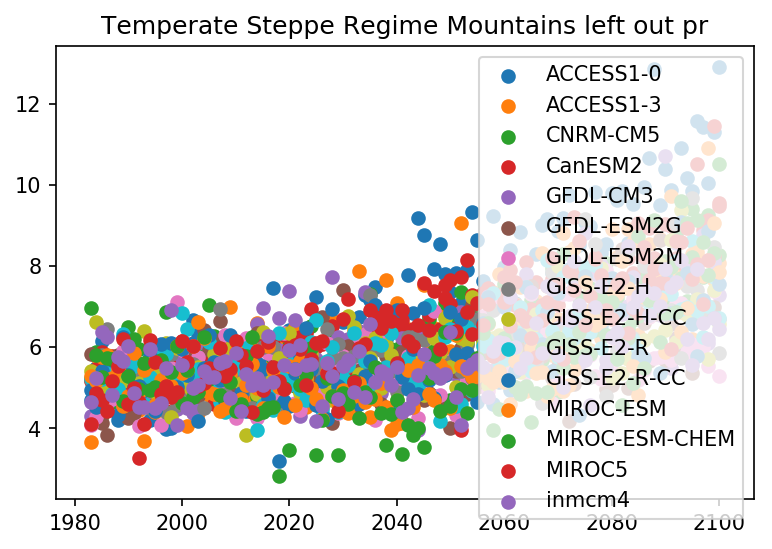

In [162]:
feature_left_out = 'pr'
div = 'Temperate Steppe Regime Mountains'

df = make_BA_dataframe(
    div=div, 
    lasso_lm=feature_left_out_model[div][feature_left_out], 
    z_pred=Z_lasso_var_out_cmip5_85_dict[div], 
    Z_features_used=features_used_by_model[div][feature_left_out]
)


plt.figure(dpi=150)
for i in range(df.shape[1]) : 
    plt.scatter(df.index.values, df.iloc[:,i], label=df.columns.values[i])
plt.legend()
plt.title("{} left out {}".format(div, feature_left_out))
plt.show()

In [163]:
features_used_by_model['Marine Regime Mountains']['pr']

array(['sfcWind_winter', 'sfcWind_spring', 'sfcWind_summer',
       'hurs_winter', 'hurs_spring', 'hurs_summer',
       'mrlsl.integrated_winter', 'mrlsl.integrated_spring',
       'mrlsl.integrated_summer', 'VPD_winter', 'VPD_spring',
       'VPD_summer'], dtype=object)

### New burn area predictions for var left out models 


In [164]:
feature_left_out_model['Marine Regime Mountains']['pr']

LassoCV(alphas=None, copy_X=True, cv=LeaveOneOut(), eps=0.001,
    fit_intercept=True, max_iter=100000, n_alphas=100, n_jobs=None,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.001, verbose=False)

In [165]:
def get_var_out_BA(model_dicts, Z_d, features_used_dict) :
    """
    Gets the burn area drivem by CMIP5 models for trained regressions
    where an environmental variable was left out, one at a time. 
    
    Parameters
    ----------
    model_dicts : {}
        Dictionary of dictionary holding fit lasso models. 
        The levels of the dictionarys are div then model, which is the
        base name of the variable that has been left out. In new wave of
        work this is probably 'feature_left_out_model'. =
    Z_d : {} 
        Dictionary of bias corrected CMIP5 data 
    features_used_dict : {}
        Features used for a given trained model stored at level
        [div][var_left_out]
    
    Return
    ------
    nested dictionary of burn area dataframes 
    dictionary[div][var_out_model] = pd.DataFrames.
    
    """

    BA_div_varOut_df_dict = {}
    
    for div in model_dicts.keys() :

        BA_div_varOut_df_dict[div] = {}
        
        for var_out_model in model_dicts[div].keys() : 
            
            print("getting BA for", div, var_out_model)
            
            df_temp = make_BA_dataframe(
                div=div, 
                lasso_lm=model_dicts[div][var_out_model], 
                z_pred=Z_d[div], 
                Z_features_used=features_used_dict[div][var_out_model]
            )
            
            BA_div_varOut_df_dict[div][var_out_model] = df_temp.copy()
            
    return BA_div_varOut_df_dict

In [166]:
BA_d_85 = get_var_out_BA(
    model_dicts=feature_left_out_model,
    Z_d = Z_lasso_var_out_cmip5_85_dict,
    features_used_dict=features_used_by_model
)

getting BA for Marine Regime Mountains None
Z_features_used ['pr_winter' 'pr_spring' 'pr_summer' 'sfcWind_winter' 'sfcWind_spring'
 'sfcWind_summer' 'hurs_winter' 'hurs_spring' 'hurs_summer'
 'mrlsl.integrated_winter' 'mrlsl.integrated_spring'
 'mrlsl.integrated_summer' 'VPD_winter' 'VPD_spring' 'VPD_summer']
lasso_lm.coef_ [ 0.         -0.15666557 -0.50695908  0.2433217  -0.03667485  0.18698675
  0.          0.         -0.         -0.47205046 -0.2257311  -0.39451497
  0.         -0.16875445  0.        ]
models_for_div ['ACCESS1-0', 'ACCESS1-3', 'CNRM-CM5', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC5', 'inmcm4']
z_years [1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024
 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035

getting BA for Marine Regime Mountains VPD
Z_features_used ['pr_winter' 'pr_spring' 'pr_summer' 'sfcWind_winter' 'sfcWind_spring'
 'sfcWind_summer' 'hurs_winter' 'hurs_spring' 'hurs_summer'
 'mrlsl.integrated_winter' 'mrlsl.integrated_spring'
 'mrlsl.integrated_summer']
lasso_lm.coef_ [ 0.         -0.14450792 -0.53731044  0.27326543 -0.          0.1633484
 -0.          0.10993574 -0.         -0.46534243 -0.27412594 -0.37035794]
models_for_div ['ACCESS1-0', 'ACCESS1-3', 'CNRM-CM5', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC5', 'inmcm4']
z_years [1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024
 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038
 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2

z_years [1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024
 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038
 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052
 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066
 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080
 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094
 2095 2096 2097 2098 2099 2100]
cmip5_model_name ACCESS1-0
cmip5_model_name ACCESS1-3
cmip5_model_name CNRM-CM5
cmip5_model_name CanESM2
cmip5_model_name GFDL-CM3
cmip5_model_name GFDL-ESM2G
cmip5_model_name GFDL-ESM2M
cmip5_model_name GISS-E2-H
cmip5_model_name GISS-E2-H-CC
cmip5_model_name GISS-E2-R
cmip5_model_name GISS-E2-R-CC
cmip5_model_name MIROC-ESM
cmip5_model_name MIROC-ESM-CHEM
cmip5_model_name MIROC5
cmip5_mo

cmip5_model_name inmcm4
getting BA for western_US hurs
Z_features_used ['pr_winter' 'pr_spring' 'pr_summer' 'sfcWind_winter' 'sfcWind_spring'
 'sfcWind_summer' 'mrlsl.integrated_winter' 'mrlsl.integrated_spring'
 'mrlsl.integrated_summer' 'VPD_winter' 'VPD_spring' 'VPD_summer']
lasso_lm.coef_ [-0.01758577 -0.00742161 -0.         -0.         -0.14592476  0.
  0.13202619 -0.         -0.21784339  0.03489165  0.06857326  0.09554199]
models_for_div ['ACCESS1-0', 'ACCESS1-3', 'CNRM-CM5', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC5', 'inmcm4']
z_years [1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024
 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038
 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 

In [167]:
BA_d_45 = get_var_out_BA(
    model_dicts=feature_left_out_model,
    Z_d = Z_lasso_var_out_cmip5_45_dict,
    features_used_dict=features_used_by_model
)

getting BA for Marine Regime Mountains None
Z_features_used ['pr_winter' 'pr_spring' 'pr_summer' 'sfcWind_winter' 'sfcWind_spring'
 'sfcWind_summer' 'hurs_winter' 'hurs_spring' 'hurs_summer'
 'mrlsl.integrated_winter' 'mrlsl.integrated_spring'
 'mrlsl.integrated_summer' 'VPD_winter' 'VPD_spring' 'VPD_summer']
lasso_lm.coef_ [ 0.         -0.15666557 -0.50695908  0.2433217  -0.03667485  0.18698675
  0.          0.         -0.         -0.47205046 -0.2257311  -0.39451497
  0.         -0.16875445  0.        ]
models_for_div ['ACCESS1-0', 'ACCESS1-3', 'CNRM-CM5', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC', 'HadGEM2-CC', 'HadGEM2-ES', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'inmcm4']
z_years [1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024
 2025 2026 2027 2028 2029 2030 2031 2

cmip5_model_name GFDL-ESM2M
cmip5_model_name GISS-E2-H
cmip5_model_name GISS-E2-H-CC
cmip5_model_name GISS-E2-R
cmip5_model_name GISS-E2-R-CC
cmip5_model_name HadGEM2-CC
cmip5_model_name HadGEM2-ES
cmip5_model_name MIROC-ESM
cmip5_model_name MIROC-ESM-CHEM
cmip5_model_name inmcm4
getting BA for Marine Regime Mountains VPD
Z_features_used ['pr_winter' 'pr_spring' 'pr_summer' 'sfcWind_winter' 'sfcWind_spring'
 'sfcWind_summer' 'hurs_winter' 'hurs_spring' 'hurs_summer'
 'mrlsl.integrated_winter' 'mrlsl.integrated_spring'
 'mrlsl.integrated_summer']
lasso_lm.coef_ [ 0.         -0.14450792 -0.53731044  0.27326543 -0.          0.1633484
 -0.          0.10993574 -0.         -0.46534243 -0.27412594 -0.37035794]
models_for_div ['ACCESS1-0', 'ACCESS1-3', 'CNRM-CM5', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC', 'HadGEM2-CC', 'HadGEM2-ES', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'inmcm4']
z_years [1983 1984 1985 1986 1987 1988 1989 1990 1991 1

cmip5_model_name GISS-E2-H
cmip5_model_name GISS-E2-H-CC
cmip5_model_name GISS-E2-R
cmip5_model_name GISS-E2-R-CC
cmip5_model_name HadGEM2-CC
cmip5_model_name HadGEM2-ES
cmip5_model_name MIROC-ESM
cmip5_model_name MIROC-ESM-CHEM
cmip5_model_name inmcm4
getting BA for Mediterranean Regime Mountains pr
Z_features_used ['sfcWind_winter' 'sfcWind_spring' 'sfcWind_summer' 'hurs_winter'
 'hurs_spring' 'hurs_summer' 'mrlsl.integrated_winter'
 'mrlsl.integrated_spring' 'mrlsl.integrated_summer' 'VPD_winter'
 'VPD_spring' 'VPD_summer']
lasso_lm.coef_ [ 0.10920858 -0.02023313 -0.03759726  0.         -0.         -0.22134657
  0.         -0.06795012 -0.          0.          0.08211975  0.        ]
models_for_div ['ACCESS1-0', 'ACCESS1-3', 'CNRM-CM5', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC', 'HadGEM2-CC', 'HadGEM2-ES', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'inmcm4']
z_years [1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995

cmip5_model_name GISS-E2-R-CC
cmip5_model_name HadGEM2-CC
cmip5_model_name HadGEM2-ES
cmip5_model_name MIROC-ESM
cmip5_model_name MIROC-ESM-CHEM
cmip5_model_name inmcm4
getting BA for western_US pr
Z_features_used ['sfcWind_winter' 'sfcWind_spring' 'sfcWind_summer' 'hurs_winter'
 'hurs_spring' 'hurs_summer' 'mrlsl.integrated_winter'
 'mrlsl.integrated_spring' 'mrlsl.integrated_summer' 'VPD_winter'
 'VPD_spring' 'VPD_summer']
lasso_lm.coef_ [-0.         -0.1986273  -0.02171947 -0.         -0.22112805 -0.18550644
  0.08158808  0.         -0.03221068  0.02704423 -0.          0.        ]
models_for_div ['ACCESS1-0', 'ACCESS1-3', 'CNRM-CM5', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC', 'HadGEM2-CC', 'HadGEM2-ES', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'inmcm4']
z_years [1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2

### steal code from orignal plotting notebook and plot spread of predictions here 

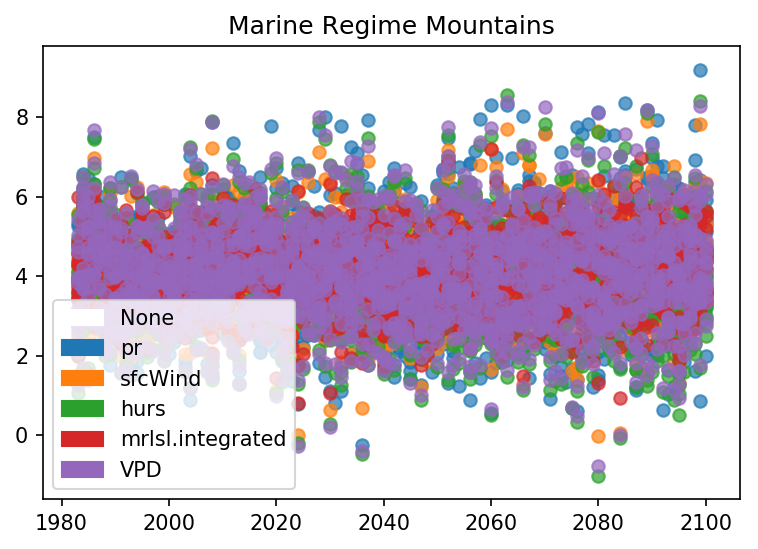

In [184]:
div = 'Marine Regime Mountains'

# legend stuffs 
colors = ['white','C0', 'C1', 'C2', 'C3', 'C4']

"""
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Line'),
                   Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='g', markersize=15),
                   Patch(facecolor='orange', edgecolor='r',
                         label='Color Patch')]
"""

legend_elements = []

fig = plt.figure(dpi=150)
ax = plt.subplot(111)
for c, variable_left_out in enumerate(BA_d_45[div].keys()) : 
    
    plot_df = BA_d_85[div][variable_left_out]
    
    legend_elements.append(
        Patch(facecolor=colors[c], edgecolor=colors[c], label=variable_left_out)
    )
    
    if True : 
        for i in range(plot_df.shape[1]) : 
            plt.scatter(
                plot_df.index.values, 
                plot_df.iloc[:, i], 
                c=colors[c], 
                alpha=0.7
            )
        
    # Add the mean across CMIP5 models 
    if False : 
        plt.plot(
            plot_df.index.values, 
            plot_df.mean(axis=1).values, 
            c=colors[c],
            linewidth=3
        )

ax.legend(handles=legend_elements)#, loc='center')
plt.title("{}".format(div))
plt.show()



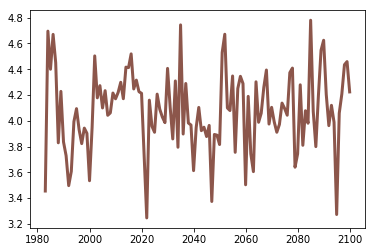

In [170]:
    plt.plot(
        plot_df.index.values, 
        plot_df.mean(axis=1).values, 
        c=colors[c],
        linewidth=3
    )

In [171]:
mtbs_BA_df = y_seanonal_df.copy()
mtbs_BA_df = mtbs_BA_df.drop(columns=['western_US'])
mtbs_BA_df

Marine Regime Mountains  Temperate Steppe Regime Mountains  \
1984                        0                              49397   
1985                    24869                             156596   
1986                    11087                             201099   
1987                    11903                              88488   
1988                    17386                            2396621   
1989                     5442                             217045   
1990                     9715                              40143   
1991                     2906                              26310   
1992                    34781                             330529   
1993                        0                              20857   
1994                   237159                             769146   
1995                     1025                               3271   
1996                   184233                             358777   
1997                        0                              15216   
1998                    15287                              70334   
1999                     1603                              59557   
2000                    11520                            1879491   
2001                   132107                             299346   
2002                   300801                             681846   
2003                   229588                             806010   
2004                    70235                              20838   
2005                    11726                             371805   
2006                   264635                             905726   
2007                    54706                            2162738   
2008                    75263                             208520   
2009                    21776                              49710   
2010                    60184                              50867   
2011                    76924                             386669   
2012                    35938                            1655697   
2013                    24018                             793511   
2014                   381799                             319670   
2015                   468612                            1459531   
2016                    17194                             620980   

      Mediterranean Regime Mountains  
1984                          104754  
1985                          230031  
1986                           26435  
1987                          860073  
1988                           77565  
1989                           97404  
1990                          282975  
1991                            2767  
1992                          145133  
1993                           48334  
1994                          217212  
1995                          105018  
1996                          429865  
1997                          131870  
1998                           60009  
1999                          330488  
2000                          178983  
2001                          230234  
2002                          844788  
2003                          146811  
2004                          112628  
2005                           78845  
2006                          309569  
2007                          355286  
2008                         1032287  
2009                          358541  
2010                           74538  
2011                           49919  
2012                          760739  
2013                          547298  
2014                          405986  
2015                          669190  
2016                          257101

In [172]:
div = 'Temperate Steppe Regime Mountains'


BA_d_45.keys()

dict_keys(['Marine Regime Mountains', 'Temperate Steppe Regime Mountains', 'Mediterranean Regime Mountains', 'western_US'])

In [185]:
def make_boxplot_df(BA_dict, mtbs_BA_df, div) : 
    """Function for tranforming the burn area dictionary data into a 
    format suitable for seaborn plotting.
    
    Parameters
    ----------
    BA_dict : dict of dict
        Levels, division, var out model estimates dataframes. 
    mtbs_BA_df : pd.DataFrame 
        The yearly aggregated mtbs burn area dataframe, where the 
        divisions are columns, years are rows. 
    div : str 
        The division to get transformed plot-able data for. 
    
    Assumes 'mtbs_BA_df' is global variable available. 
    """

    year_bounds = [(1984,2016), (2040,2060), (2080,2099)]
    vars_left_out = ['None', 'pr', 'sfcWind', 'hurs', 'mrlsl.integrated', 'VPD']

    # lists to append values to 
    var_out_list = []
    year_label_list = []
    value_list = []

    for var_out_name in vars_left_out : 
        print("var_left_out", var_out_name)

        for i in range(len(year_bounds)) : 

            y1, y2 = year_bounds[i][0], year_bounds[i][1]
            #print(y1, y2)

            # include the observed burn area for historical period 
            if y1 == 1984 : 
                #print("Getting observed BA")
                og_BA = mtbs_BA_df.loc[y1:y2, div].values
                # Make needed log10 transform to match predicted vals
                og_BA[og_BA==0] = 1 
                og_BA = np.log10(og_BA)

                year_label = np.repeat("{}-{}".format(y1, y2), len(og_BA) )

                value_list = np.append(value_list, og_BA)
                year_label_list = np.append(year_label_list, year_label)
                var_out_list = np.append(var_out_list, np.repeat("MTBS", len(og_BA)))

            # Append the regression estimate burn areas for these years 
            values = BA_dict[div][var_out_name].loc[y1:y2].values.ravel()
            year_label = np.repeat("{}-{}".format(y1, y2), len(values) )
            var_out = np.repeat(var_out_name, len(values))

            value_list = np.append(value_list, values)
            year_label_list = np.append(year_label_list, year_label)
            var_out_list = np.append(var_out_list, var_out)

    plot_df = pd.DataFrame({"Burn Area":value_list, 
                            "year": year_label_list, 
                            "Variable Out": var_out_list})
    return plot_df 

In [186]:
rocky_plot_df = make_boxplot_df(
    BA_dict=BA_d_85,
    mtbs_BA_df=y_seanonal_df,
    div='Temperate Steppe Regime Mountains')

PNW_plot_df = make_boxplot_df(
    BA_dict=BA_d_85,
    mtbs_BA_df=y_seanonal_df,
    div='Marine Regime Mountains')

cal_plot_df = make_boxplot_df(
    BA_dict=BA_d_85,
    mtbs_BA_df=y_seanonal_df,
    div='Mediterranean Regime Mountains')

var_left_out None
var_left_out pr
var_left_out sfcWind
var_left_out hurs
var_left_out mrlsl.integrated
var_left_out VPD
var_left_out None
var_left_out pr
var_left_out sfcWind
var_left_out hurs
var_left_out mrlsl.integrated
var_left_out VPD
var_left_out None
var_left_out pr
var_left_out sfcWind
var_left_out hurs
var_left_out mrlsl.integrated
var_left_out VPD


In [179]:
BA_d_85['Marine Regime Mountains']['pr'].shape

(118, 15)

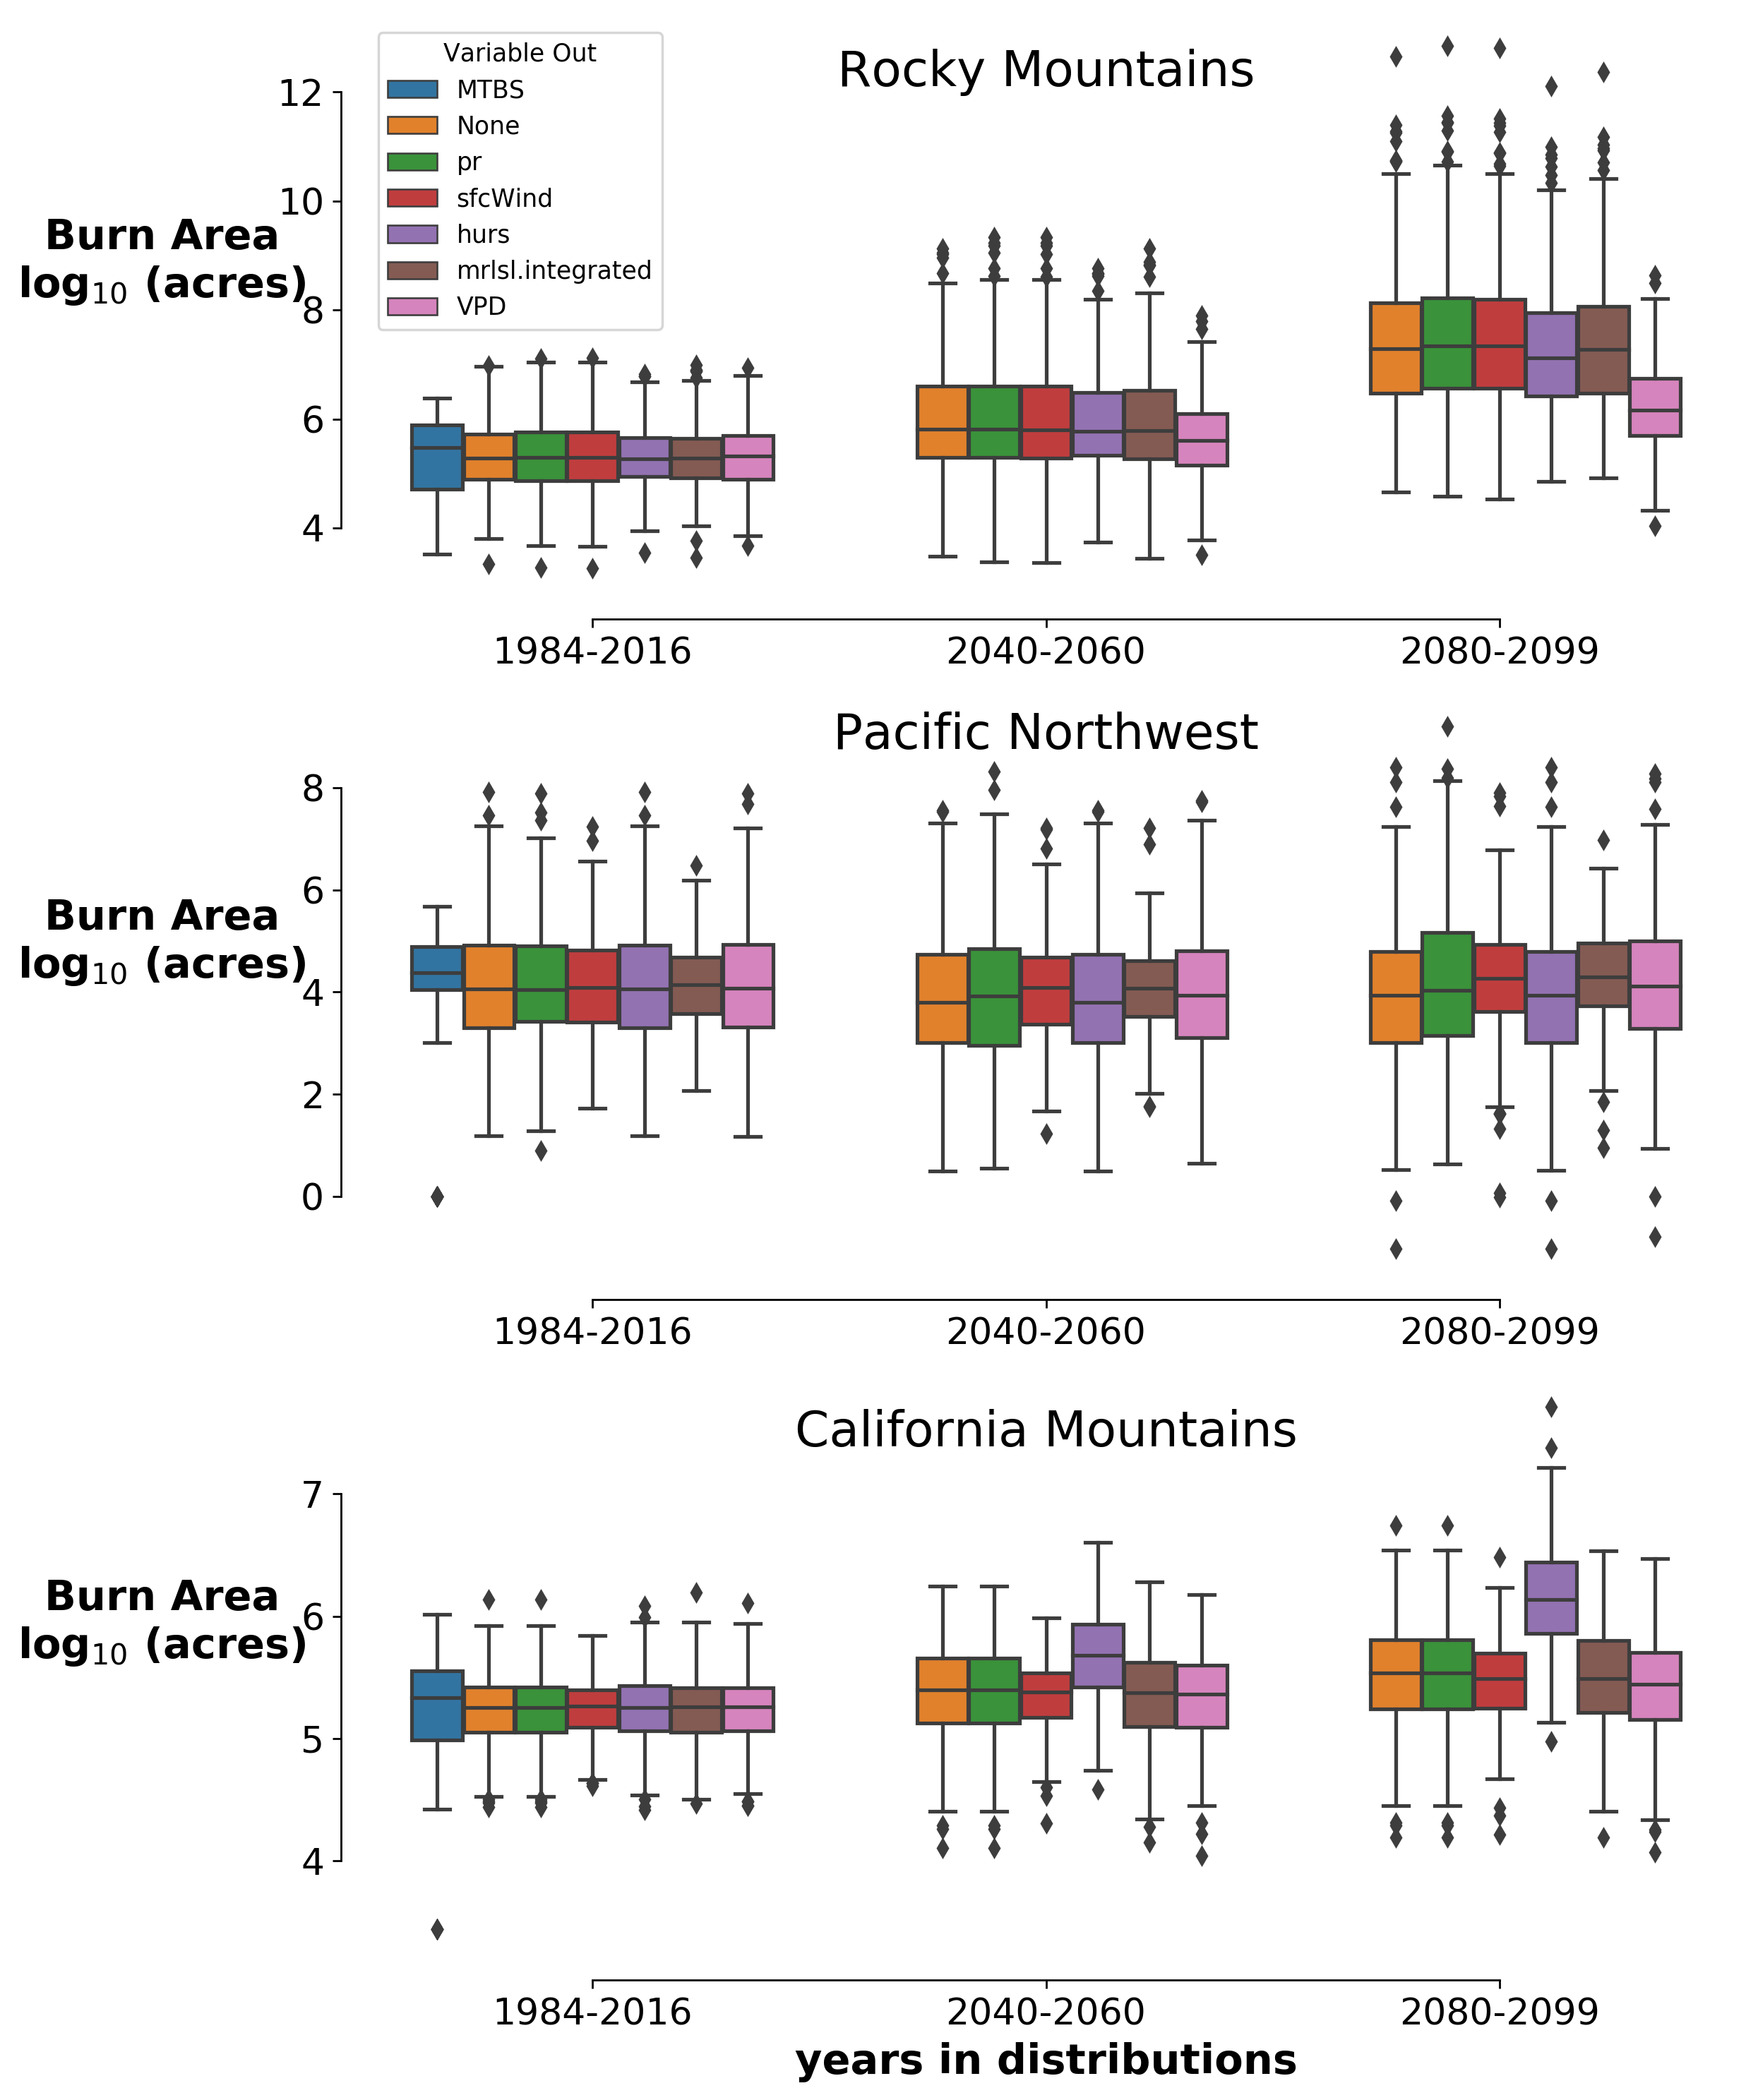

In [194]:
fig = plt.figure(dpi=250, figsize=(10,12))

ax1 = plt.subplot(311)
g = sns.boxplot(x="year", y="Burn Area", hue="Variable Out", 
                data=rocky_plot_df, ax=ax1)
sns.despine(offset=10, trim=True)
plt.title("Rocky Mountains", fontsize=20,  y=0.86)
plt.xlabel("")
h = plt.ylabel('Burn Area\nlog$_{10}$ (acres)', fontsize=17)
h.set_rotation(0)
ax1.yaxis.set_label_coords(-.15, 0.5)
ax1.tick_params(axis='both', which='major', labelsize=15)



ax2 = plt.subplot(312)
g = sns.boxplot(x="year", y="Burn Area", hue="Variable Out", 
                data=PNW_plot_df, ax=ax2)
ax2.get_legend().set_visible(False)
sns.despine(offset=10, trim=True)
plt.title("Pacific Northwest", fontsize=20,  y=0.89)
plt.xlabel("")
h = plt.ylabel('Burn Area\nlog$_{10}$ (acres)', fontsize=17)
h.set_rotation(0)
ax2.yaxis.set_label_coords(-.15, 0.5)
ax2.tick_params(axis='both', which='major', labelsize=15)


ax3 = plt.subplot(313)
g = sns.boxplot(x="year", y="Burn Area",
                hue="Variable Out", data=cal_plot_df, ax=ax3)
ax3.get_legend().set_visible(False)
sns.despine(offset=10, trim=True)
plt.title("California Mountains", fontsize=20, y=0.86)
h = plt.ylabel('Burn Area\nlog$_{10}$ (acres)', fontsize=17)
h.set_rotation(0)
ax3.yaxis.set_label_coords(-.15, 0.5)
ax3.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel("years in distributions", fontsize=17)


plt.tight_layout()


plt.savefig(os.path.join(save_dir_base, "var_out_burn_area_boxplots_rcp=85.png"), 
            bbox_inches='tight')

In [223]:
save_dir_base

'../Data/Fire_Analysis/not_my_job_no_tas_e_0_transofromation_log10'